This is Japanese notebook.

# EfficientGAN 評価 - MVTecAD - 64x64

この試験評価は、

[書籍「つくりながら学ぶ! PyTorchによる発展ディープラーニング」（小川雄太郎、マイナビ出版 、19/07/29)](https://www.amazon.co.jp/dp/4839970254/)

で実装されたサンプル「[第6章 GANによる異常検知（AnoGAN、Efficient GAN)](https://github.com/YutaroOgawa/pytorch_advanced/tree/master/6_gan_anomaly_detection)」を下記のように拡張したものです。

- データセットに[MVTecAD](https://www.mvtec.com/company/research/datasets/mvtec-ad/)を利用。
- その中からトランジスター画像を利用。
- 画像サイズを64x64に、更にカラー対応。

実行するには、下記を行ってください。

- /data/mvtecad/original/transistor を環境に合わせる。

In [1]:
from dlcliche.notebook import *
from dlcliche.utils import *
from dlcliche.math import *

import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms


def to_raw_image(img, denorm_tensor=True):
    if type(img) == torch.Tensor:
        # denormalize
        img = img.detach().cpu().numpy().transpose(1, 2, 0)
        if denorm_tensor:
            img = (img * 0.5) + 0.5
        img = (img * 255).astype(np.uint8)
    return img

In [2]:
# Setup seeds
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# Generatorの実装



In [3]:
class Generator(nn.Module):

    def __init__(self, z_dim=20):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.Linear(1024, 8*8*256),
            nn.BatchNorm1d(8*8*256),
            nn.ReLU(inplace=True))

        layers = []
        for k_in, k_out in [(256, 128), (128, 64)]:
            layers.append(nn.ConvTranspose2d(in_channels=k_in, out_channels=k_out,
                               kernel_size=4, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(k_out))
            layers.append(nn.ReLU(inplace=True))
        self.layer3 = nn.Sequential(*layers)

        self.last = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=3, # dl 3chへ変更
                               kernel_size=4, stride=2, padding=1),
            nn.Tanh())

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)

        # 転置畳み込み層に入れるためにテンソルの形を整形
        out = out.view(z.shape[0], 256, 8, 8)
        out = self.layer3(out)
        out = self.last(out)

        return out

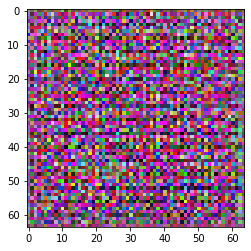

(64, 64, 3)


,count,mean,std,min,25%,50%,75%,max
0,12288.0,113.512044,74.155083,0.0,46.0,107.0,177.0,254.0


In [4]:
# 動作確認

G = Generator(z_dim=20)
G.train()

# 入力する乱数
# バッチノーマライゼーションがあるのでミニバッチ数は2以上
input_z = torch.randn(2, 20)

# 偽画像を出力
fake_images = G(input_z)  # torch.Size([2, 1, 64, 64])
img_transformed = to_raw_image(fake_images[0].detach())
plt.imshow(img_transformed, 'gray')
plt.show()
print(img_transformed.shape)
np_describe(img_transformed)

# Discriminatorの実装

In [5]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20):
        super(Discriminator, self).__init__()

        # 画像側の入力処理
        self.x_layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, # dl カラー対応
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.x_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=4,
                      stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))

        # 乱数側の入力処理
        self.z_layer1 = nn.Linear(z_dim, 512)

        # 最後の判定
        self.last1 = nn.Sequential(
            nn.Linear(16896, 1024), # 16896 = 16384 + 512
            nn.LeakyReLU(0.1, inplace=True))

        self.last2 = nn.Linear(1024, 1)

    def forward(self, x, z):

        # 画像側の入力処理
        x_out = self.x_layer1(x)
        x_out = self.x_layer2(x_out)

        # 乱数側の入力処理
        z = z.view(z.shape[0], -1)
        z_out = self.z_layer1(z)

        # x_outとz_outを結合し、全結合層で判定
        x_out = x_out.view(z.shape[0], -1)
        out = torch.cat([x_out, z_out], dim=1)
        out = self.last1(out)

        feature = out  # 最後にチャネルを1つに集約する手前の情報
        feature = feature.view(feature.size()[0], -1)  # 2次元に変換

        out = self.last2(out)

        return out, feature

In [6]:
# 動作確認
D = Discriminator(z_dim=20)

# 偽画像を生成
input_z = torch.randn(2, 20)
fake_images = G(input_z)

# 偽画像をDに入力
d_out, _ = D(fake_images, input_z)

# 出力d_outにSigmoidをかけて0から1に変換
print(nn.Sigmoid()(d_out))

tensor([[0.5777],
        [0.5560]], grad_fn=<SigmoidBackward>)


# Encoderの実装

画像をzに変換する

In [7]:
class Encoder(nn.Module):

    def __init__(self, z_dim=20):
        super(Encoder, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, # dl カラー対応
                      stride=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True))

        # ここまでで画像のサイズは16×16になっている
        self.last = nn.Linear(128 * 16 * 16, z_dim)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)

        # FCに入れるためにテンソルの形を整形
        out = out.view(-1, 128 * 16 * 16)
        out = self.last(out)

        return out


In [8]:
# 動作確認
E = Encoder(z_dim=20)

# 入力する画像データ
x = fake_images  # fake_imagesは上のGで作成したもの

# 画像からzをEncode
z = E(x)

print(z.shape)
print(z)

torch.Size([2, 20])
tensor([[-0.2298,  0.3835,  0.7564, -0.1375,  0.5728,  0.2550,  0.7604,  0.6218,
         -0.2937, -0.0586, -0.2283, -0.2187,  0.2862,  0.1545,  0.5273, -0.8486,
          0.2560,  0.0466, -0.3413, -0.1856],
        [-0.4202, -1.0587,  0.5273, -0.6505, -0.3256,  0.1541, -0.4869, -0.1623,
         -0.8211, -0.1099, -0.7859, -0.5699, -0.3043, -0.5191,  0.3383, -0.8247,
         -0.3779,  0.1235, -0.0649,  0.1105]], grad_fn=<AddmmBackward>)


# DataLoaderの作成

In [9]:
# pix2pix実装から移植、データを予めロードサイズにリサイズしたコピーを作成し、高速化する

import numpy as np
from dlcliche.utils import Path, ensure_delete, ensure_folder
from PIL import Image


class TrainPrep(object):
    def __init__(self, project_name, train_files, load_size, crop_size, suffix,
                 pre_crop_rect=None, extra='', skip_file_creation=False):
        self.project, self.load_size, self.crop_size = project_name, load_size, crop_size
        self.suffix, self.pre_crop_rect, self.extra = suffix, pre_crop_rect, extra
        self.root = Path(f'./tmp/{self.project}')
        self.train = self.root/'train'
        self.test = self.root/'test'
        self.prepare_train(train_files, skip_file_creation)

    def copy_files_pre_crop(self, dest, files, skip_file_creation):
        new_filenames = []
        for f in files:
            file_name = str((dest/f'{f.parent.name}-{f.name}').with_suffix(self.suffix))
            assert file_name not in new_filenames
            if not skip_file_creation:
                img = Image.open(f).convert('RGB')
                if self.pre_crop_rect is not None:
                    img = img.crop(self.pre_crop_rect)
                img = img.resize((self.load_size, self.load_size))
                img.save(file_name)
            new_filenames.append(file_name)
        return new_filenames

    def prepare_train(self, train_files, skip_file_creation):
        if not skip_file_creation:
            ensure_delete(self.train)
            ensure_folder(self.train)
        self.train_files = self.copy_files_pre_crop(self.train, train_files, skip_file_creation)

    def prepare_test(self, test_files, skip_file_creation=False):
        if not skip_file_creation:
            ensure_delete(self.test)
            ensure_folder(self.test)
        self.test_files = self.copy_files_pre_crop(self.test, test_files, skip_file_creation=skip_file_creation)

In [10]:
def make_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    # 画像ファイルパスを格納
    train_img_list = sorted(DATA_ROOT.glob(f'train/good/*{SUFFIX}'))

    return train_img_list


class ImageTransform():
    """画像の前処理クラス"""

    def __init__(self, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

In [11]:
def random_crop(opt, pil_img):
    w, h = pil_img.size
    if opt.random:
        x = random.randint(0, np.maximum(0, w - opt.crop_size))
        y = random.randint(0, np.maximum(0, h - opt.crop_size))
    else:
        x = (w - opt.crop_size) // 2
        y = (h - opt.crop_size) // 2
    return pil_img.crop((x, y, x+opt.crop_size, y+opt.crop_size))

class GAN_Img_Dataset(data.Dataset):
    """画像のDatasetクラス。PyTorchのDatasetクラスを継承"""

    def __init__(self, file_list, load_size, crop_size, transform, random, debug=None):
        self.file_list = file_list
        self.load_size, self.crop_size = load_size, crop_size
        self.transform, self.random, self.debug = transform, random, debug

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''前処理をした画像のTensor形式のデータを取得'''
        if self.debug is not None: print(f'{self.debug}[{index}]')

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色] # dl カラー対応
        img = img.resize((self.load_size, self.load_size))
        img = random_crop(self, img)

        # 画像の前処理
        img_transformed = self.transform(img)

        return img_transformed

In [12]:
# DataLoaderの作成と動作確認

DATA_ROOT = Path('/data/mvtec_ad/original/transistor')
SUFFIX = '.png'
SIZE = 64
batch_size = 64

# ファイルリストを作成
train_img_list=make_datapath_list()

# リサイズして準備
prep = TrainPrep('effgan-mvtrans64', train_img_list, load_size=SIZE+4, crop_size=SIZE, suffix=SUFFIX,
                #skip_file_creation=True
                )

# Datasetを作成
train_dataset = GAN_Img_Dataset(file_list=prep.train_files, load_size=SIZE + 4, crop_size=SIZE, transform=ImageTransform(), random=True)

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 動作の確認
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([64, 3, 64, 64])  # dl カラー対応

torch.Size([64, 3, 64, 64])


# 学習させる

In [13]:
# GPUが使えるかを確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

# モデルを学習させる関数を作成

def train_model(G, D, E, dataloader, num_epochs):

    # 最適化手法の設定
    lr_ge = 0.0001
    lr_d = 0.0001/4
    beta1, beta2 = 0.5, 0.999
    g_optimizer = torch.optim.Adam(G.parameters(), lr_ge, [beta1, beta2])
    e_optimizer = torch.optim.Adam(E.parameters(), lr_ge, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), lr_d, [beta1, beta2])

    # 誤差関数を定義
    # BCEWithLogitsLossは入力にシグモイド（logit）をかけてから、
    # バイナリークロスエントロピーを計算
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # パラメータをハードコーディング
    z_dim = 20
    mini_batch_size = 64

    # ネットワークをGPUへ
    G.to(device)
    E.to(device)
    D.to(device)

    G.train()  # モデルを訓練モードに
    E.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_e_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        print('Epoch {}/{}'.format(epoch, num_epochs))

        # データローダーからminibatchずつ取り出すループ
        for imges in dataloader:

            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            if imges.size()[0] == 1:
                continue

            # ミニバッチサイズの1もしくは0のラベル役のテンソルを作成
            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # GPUが使えるならGPUにデータを送る
            imges = imges.to(device)

            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            # 真の画像を判定　
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)

            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            # 誤差を計算
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # バックプロパゲーション
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # バックプロパゲーション
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. Encoderの学習
            # --------------------
            # 真の画像のzを推定
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)

            # 誤差を計算
            e_loss = criterion(d_out_real.view(-1), label_fake)

            # バックプロパゲーション
            e_optimizer.zero_grad()
            e_loss.backward()
            e_optimizer.step()

            # --------------------
            # 4. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            epoch_e_loss += e_loss.item()
            iteration += 1

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f} ||Epoch_E_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size, epoch_e_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    print("総イテレーション回数:", iteration)

    return G, D, E

使用デバイス： cuda:0


In [14]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        # 全結合層Linearの初期化
        m.bias.data.fill_(0)


# 初期化の実施
G.apply(weights_init)
E.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")

ネットワークの初期化完了


In [15]:
%%time
# 学習・検証を実行する 42-90分ほどかかる

num_epochs = 10000
G_update, D_update, E_update = train_model(
    G, D, E, dataloader=train_dataloader, num_epochs=num_epochs)

Epoch 0/10000
epoch 0 || Epoch_D_Loss:0.0858 ||Epoch_G_Loss:0.0432 ||Epoch_E_Loss:0.0451
timer:  0.5071 sec.
Epoch 1/10000
epoch 1 || Epoch_D_Loss:0.0827 ||Epoch_G_Loss:0.0438 ||Epoch_E_Loss:0.0481
timer:  0.2581 sec.
Epoch 2/10000
epoch 2 || Epoch_D_Loss:0.0792 ||Epoch_G_Loss:0.0442 ||Epoch_E_Loss:0.0520
timer:  0.2527 sec.
Epoch 3/10000
epoch 3 || Epoch_D_Loss:0.0757 ||Epoch_G_Loss:0.0446 ||Epoch_E_Loss:0.0561
timer:  0.2524 sec.
Epoch 4/10000
epoch 4 || Epoch_D_Loss:0.0735 ||Epoch_G_Loss:0.0446 ||Epoch_E_Loss:0.0595
timer:  0.2526 sec.
Epoch 5/10000
epoch 5 || Epoch_D_Loss:0.0719 ||Epoch_G_Loss:0.0444 ||Epoch_E_Loss:0.0632
timer:  0.2520 sec.
Epoch 6/10000
epoch 6 || Epoch_D_Loss:0.0694 ||Epoch_G_Loss:0.0442 ||Epoch_E_Loss:0.0685
timer:  0.2525 sec.
Epoch 7/10000
epoch 7 || Epoch_D_Loss:0.0670 ||Epoch_G_Loss:0.0447 ||Epoch_E_Loss:0.0721
timer:  0.2524 sec.
Epoch 8/10000
epoch 8 || Epoch_D_Loss:0.0657 ||Epoch_G_Loss:0.0452 ||Epoch_E_Loss:0.0720
timer:  0.2524 sec.
Epoch 9/10000
epoch

epoch 74 || Epoch_D_Loss:0.0219 ||Epoch_G_Loss:0.1318 ||Epoch_E_Loss:0.1366
timer:  0.2531 sec.
Epoch 75/10000
epoch 75 || Epoch_D_Loss:0.0214 ||Epoch_G_Loss:0.1254 ||Epoch_E_Loss:0.1418
timer:  0.2533 sec.
Epoch 76/10000
epoch 76 || Epoch_D_Loss:0.0264 ||Epoch_G_Loss:0.1247 ||Epoch_E_Loss:0.1360
timer:  0.2529 sec.
Epoch 77/10000
epoch 77 || Epoch_D_Loss:0.0244 ||Epoch_G_Loss:0.1215 ||Epoch_E_Loss:0.1356
timer:  0.2529 sec.
Epoch 78/10000
epoch 78 || Epoch_D_Loss:0.0288 ||Epoch_G_Loss:0.1130 ||Epoch_E_Loss:0.1364
timer:  0.2531 sec.
Epoch 79/10000
epoch 79 || Epoch_D_Loss:0.0406 ||Epoch_G_Loss:0.1188 ||Epoch_E_Loss:0.1183
timer:  0.2530 sec.
Epoch 80/10000
epoch 80 || Epoch_D_Loss:0.0330 ||Epoch_G_Loss:0.1090 ||Epoch_E_Loss:0.1254
timer:  0.2530 sec.
Epoch 81/10000
epoch 81 || Epoch_D_Loss:0.0335 ||Epoch_G_Loss:0.1197 ||Epoch_E_Loss:0.1188
timer:  0.2529 sec.
Epoch 82/10000
epoch 82 || Epoch_D_Loss:0.0258 ||Epoch_G_Loss:0.1237 ||Epoch_E_Loss:0.1345
timer:  0.2532 sec.
Epoch 83/10000
e

epoch 147 || Epoch_D_Loss:0.0807 ||Epoch_G_Loss:0.0588 ||Epoch_E_Loss:0.0610
timer:  0.2537 sec.
Epoch 148/10000
epoch 148 || Epoch_D_Loss:0.0778 ||Epoch_G_Loss:0.0514 ||Epoch_E_Loss:0.0662
timer:  0.2536 sec.
Epoch 149/10000
epoch 149 || Epoch_D_Loss:0.0804 ||Epoch_G_Loss:0.0563 ||Epoch_E_Loss:0.0632
timer:  0.2539 sec.
Epoch 150/10000
epoch 150 || Epoch_D_Loss:0.0748 ||Epoch_G_Loss:0.0602 ||Epoch_E_Loss:0.0668
timer:  0.2535 sec.
Epoch 151/10000
epoch 151 || Epoch_D_Loss:0.0776 ||Epoch_G_Loss:0.0575 ||Epoch_E_Loss:0.0647
timer:  0.2535 sec.
Epoch 152/10000
epoch 152 || Epoch_D_Loss:0.0799 ||Epoch_G_Loss:0.0556 ||Epoch_E_Loss:0.0643
timer:  0.2539 sec.
Epoch 153/10000
epoch 153 || Epoch_D_Loss:0.0817 ||Epoch_G_Loss:0.0552 ||Epoch_E_Loss:0.0603
timer:  0.2536 sec.
Epoch 154/10000
epoch 154 || Epoch_D_Loss:0.0847 ||Epoch_G_Loss:0.0488 ||Epoch_E_Loss:0.0587
timer:  0.2539 sec.
Epoch 155/10000
epoch 155 || Epoch_D_Loss:0.0807 ||Epoch_G_Loss:0.0522 ||Epoch_E_Loss:0.0588
timer:  0.2538 sec.

epoch 220 || Epoch_D_Loss:0.0842 ||Epoch_G_Loss:0.0480 ||Epoch_E_Loss:0.0577
timer:  0.2539 sec.
Epoch 221/10000
epoch 221 || Epoch_D_Loss:0.0968 ||Epoch_G_Loss:0.0414 ||Epoch_E_Loss:0.0502
timer:  0.2541 sec.
Epoch 222/10000
epoch 222 || Epoch_D_Loss:0.1055 ||Epoch_G_Loss:0.0417 ||Epoch_E_Loss:0.0463
timer:  0.2539 sec.
Epoch 223/10000
epoch 223 || Epoch_D_Loss:0.1150 ||Epoch_G_Loss:0.0347 ||Epoch_E_Loss:0.0438
timer:  0.2539 sec.
Epoch 224/10000
epoch 224 || Epoch_D_Loss:0.1167 ||Epoch_G_Loss:0.0369 ||Epoch_E_Loss:0.0422
timer:  0.2547 sec.
Epoch 225/10000
epoch 225 || Epoch_D_Loss:0.1085 ||Epoch_G_Loss:0.0381 ||Epoch_E_Loss:0.0459
timer:  0.2536 sec.
Epoch 226/10000
epoch 226 || Epoch_D_Loss:0.0959 ||Epoch_G_Loss:0.0483 ||Epoch_E_Loss:0.0529
timer:  0.2526 sec.
Epoch 227/10000
epoch 227 || Epoch_D_Loss:0.0804 ||Epoch_G_Loss:0.0521 ||Epoch_E_Loss:0.0607
timer:  0.2525 sec.
Epoch 228/10000
epoch 228 || Epoch_D_Loss:0.0733 ||Epoch_G_Loss:0.0560 ||Epoch_E_Loss:0.0648
timer:  0.2525 sec.

epoch 293 || Epoch_D_Loss:0.1047 ||Epoch_G_Loss:0.0426 ||Epoch_E_Loss:0.0539
timer:  0.2535 sec.
Epoch 294/10000
epoch 294 || Epoch_D_Loss:0.0984 ||Epoch_G_Loss:0.0412 ||Epoch_E_Loss:0.0562
timer:  0.2540 sec.
Epoch 295/10000
epoch 295 || Epoch_D_Loss:0.1086 ||Epoch_G_Loss:0.0392 ||Epoch_E_Loss:0.0539
timer:  0.2552 sec.
Epoch 296/10000
epoch 296 || Epoch_D_Loss:0.1001 ||Epoch_G_Loss:0.0444 ||Epoch_E_Loss:0.0564
timer:  0.2557 sec.
Epoch 297/10000
epoch 297 || Epoch_D_Loss:0.0991 ||Epoch_G_Loss:0.0465 ||Epoch_E_Loss:0.0574
timer:  0.2539 sec.
Epoch 298/10000
epoch 298 || Epoch_D_Loss:0.1005 ||Epoch_G_Loss:0.0426 ||Epoch_E_Loss:0.0554
timer:  0.2531 sec.
Epoch 299/10000
epoch 299 || Epoch_D_Loss:0.0949 ||Epoch_G_Loss:0.0427 ||Epoch_E_Loss:0.0573
timer:  0.2542 sec.
Epoch 300/10000
epoch 300 || Epoch_D_Loss:0.0969 ||Epoch_G_Loss:0.0423 ||Epoch_E_Loss:0.0565
timer:  0.2529 sec.
Epoch 301/10000
epoch 301 || Epoch_D_Loss:0.1023 ||Epoch_G_Loss:0.0439 ||Epoch_E_Loss:0.0552
timer:  0.2525 sec.

epoch 366 || Epoch_D_Loss:0.1002 ||Epoch_G_Loss:0.0415 ||Epoch_E_Loss:0.0408
timer:  0.2524 sec.
Epoch 367/10000
epoch 367 || Epoch_D_Loss:0.1084 ||Epoch_G_Loss:0.0378 ||Epoch_E_Loss:0.0366
timer:  0.2524 sec.
Epoch 368/10000
epoch 368 || Epoch_D_Loss:0.1092 ||Epoch_G_Loss:0.0355 ||Epoch_E_Loss:0.0369
timer:  0.2527 sec.
Epoch 369/10000
epoch 369 || Epoch_D_Loss:0.1055 ||Epoch_G_Loss:0.0353 ||Epoch_E_Loss:0.0389
timer:  0.2526 sec.
Epoch 370/10000
epoch 370 || Epoch_D_Loss:0.1029 ||Epoch_G_Loss:0.0380 ||Epoch_E_Loss:0.0409
timer:  0.2533 sec.
Epoch 371/10000
epoch 371 || Epoch_D_Loss:0.0976 ||Epoch_G_Loss:0.0383 ||Epoch_E_Loss:0.0421
timer:  0.2533 sec.
Epoch 372/10000
epoch 372 || Epoch_D_Loss:0.0991 ||Epoch_G_Loss:0.0402 ||Epoch_E_Loss:0.0419
timer:  0.2526 sec.
Epoch 373/10000
epoch 373 || Epoch_D_Loss:0.0935 ||Epoch_G_Loss:0.0427 ||Epoch_E_Loss:0.0448
timer:  0.2524 sec.
Epoch 374/10000
epoch 374 || Epoch_D_Loss:0.0891 ||Epoch_G_Loss:0.0414 ||Epoch_E_Loss:0.0479
timer:  0.2527 sec.

epoch 439 || Epoch_D_Loss:0.0875 ||Epoch_G_Loss:0.0449 ||Epoch_E_Loss:0.0472
timer:  0.2528 sec.
Epoch 440/10000
epoch 440 || Epoch_D_Loss:0.0854 ||Epoch_G_Loss:0.0458 ||Epoch_E_Loss:0.0493
timer:  0.2526 sec.
Epoch 441/10000
epoch 441 || Epoch_D_Loss:0.0818 ||Epoch_G_Loss:0.0462 ||Epoch_E_Loss:0.0516
timer:  0.2531 sec.
Epoch 442/10000
epoch 442 || Epoch_D_Loss:0.0786 ||Epoch_G_Loss:0.0481 ||Epoch_E_Loss:0.0538
timer:  0.2532 sec.
Epoch 443/10000
epoch 443 || Epoch_D_Loss:0.0781 ||Epoch_G_Loss:0.0493 ||Epoch_E_Loss:0.0533
timer:  0.2528 sec.
Epoch 444/10000
epoch 444 || Epoch_D_Loss:0.0808 ||Epoch_G_Loss:0.0475 ||Epoch_E_Loss:0.0514
timer:  0.2529 sec.
Epoch 445/10000
epoch 445 || Epoch_D_Loss:0.0837 ||Epoch_G_Loss:0.0478 ||Epoch_E_Loss:0.0493
timer:  0.2526 sec.
Epoch 446/10000
epoch 446 || Epoch_D_Loss:0.0864 ||Epoch_G_Loss:0.0458 ||Epoch_E_Loss:0.0477
timer:  0.2523 sec.
Epoch 447/10000
epoch 447 || Epoch_D_Loss:0.0902 ||Epoch_G_Loss:0.0434 ||Epoch_E_Loss:0.0451
timer:  0.2528 sec.

epoch 512 || Epoch_D_Loss:0.1028 ||Epoch_G_Loss:0.0367 ||Epoch_E_Loss:0.0403
timer:  0.2526 sec.
Epoch 513/10000
epoch 513 || Epoch_D_Loss:0.1017 ||Epoch_G_Loss:0.0377 ||Epoch_E_Loss:0.0403
timer:  0.2523 sec.
Epoch 514/10000
epoch 514 || Epoch_D_Loss:0.0984 ||Epoch_G_Loss:0.0392 ||Epoch_E_Loss:0.0426
timer:  0.2532 sec.
Epoch 515/10000
epoch 515 || Epoch_D_Loss:0.0962 ||Epoch_G_Loss:0.0409 ||Epoch_E_Loss:0.0433
timer:  0.2532 sec.
Epoch 516/10000
epoch 516 || Epoch_D_Loss:0.0916 ||Epoch_G_Loss:0.0414 ||Epoch_E_Loss:0.0452
timer:  0.2529 sec.
Epoch 517/10000
epoch 517 || Epoch_D_Loss:0.0904 ||Epoch_G_Loss:0.0424 ||Epoch_E_Loss:0.0458
timer:  0.2526 sec.
Epoch 518/10000
epoch 518 || Epoch_D_Loss:0.0937 ||Epoch_G_Loss:0.0424 ||Epoch_E_Loss:0.0433
timer:  0.2525 sec.
Epoch 519/10000
epoch 519 || Epoch_D_Loss:0.0929 ||Epoch_G_Loss:0.0419 ||Epoch_E_Loss:0.0436
timer:  0.2524 sec.
Epoch 520/10000
epoch 520 || Epoch_D_Loss:0.0922 ||Epoch_G_Loss:0.0416 ||Epoch_E_Loss:0.0454
timer:  0.2527 sec.

epoch 585 || Epoch_D_Loss:0.0972 ||Epoch_G_Loss:0.0387 ||Epoch_E_Loss:0.0412
timer:  0.2534 sec.
Epoch 586/10000
epoch 586 || Epoch_D_Loss:0.0966 ||Epoch_G_Loss:0.0371 ||Epoch_E_Loss:0.0421
timer:  0.2530 sec.
Epoch 587/10000
epoch 587 || Epoch_D_Loss:0.0943 ||Epoch_G_Loss:0.0399 ||Epoch_E_Loss:0.0433
timer:  0.2534 sec.
Epoch 588/10000
epoch 588 || Epoch_D_Loss:0.0932 ||Epoch_G_Loss:0.0406 ||Epoch_E_Loss:0.0435
timer:  0.2525 sec.
Epoch 589/10000
epoch 589 || Epoch_D_Loss:0.0931 ||Epoch_G_Loss:0.0404 ||Epoch_E_Loss:0.0434
timer:  0.2528 sec.
Epoch 590/10000
epoch 590 || Epoch_D_Loss:0.0906 ||Epoch_G_Loss:0.0412 ||Epoch_E_Loss:0.0448
timer:  0.2524 sec.
Epoch 591/10000
epoch 591 || Epoch_D_Loss:0.0890 ||Epoch_G_Loss:0.0421 ||Epoch_E_Loss:0.0451
timer:  0.2524 sec.
Epoch 592/10000
epoch 592 || Epoch_D_Loss:0.0879 ||Epoch_G_Loss:0.0440 ||Epoch_E_Loss:0.0460
timer:  0.2526 sec.
Epoch 593/10000
epoch 593 || Epoch_D_Loss:0.0875 ||Epoch_G_Loss:0.0445 ||Epoch_E_Loss:0.0458
timer:  0.2525 sec.

epoch 658 || Epoch_D_Loss:0.0891 ||Epoch_G_Loss:0.0433 ||Epoch_E_Loss:0.0439
timer:  0.2531 sec.
Epoch 659/10000
epoch 659 || Epoch_D_Loss:0.0898 ||Epoch_G_Loss:0.0426 ||Epoch_E_Loss:0.0428
timer:  0.2527 sec.
Epoch 660/10000
epoch 660 || Epoch_D_Loss:0.0907 ||Epoch_G_Loss:0.0431 ||Epoch_E_Loss:0.0425
timer:  0.2523 sec.
Epoch 661/10000
epoch 661 || Epoch_D_Loss:0.0903 ||Epoch_G_Loss:0.0427 ||Epoch_E_Loss:0.0429
timer:  0.2522 sec.
Epoch 662/10000
epoch 662 || Epoch_D_Loss:0.0903 ||Epoch_G_Loss:0.0422 ||Epoch_E_Loss:0.0425
timer:  0.2526 sec.
Epoch 663/10000
epoch 663 || Epoch_D_Loss:0.0918 ||Epoch_G_Loss:0.0420 ||Epoch_E_Loss:0.0417
timer:  0.2532 sec.
Epoch 664/10000
epoch 664 || Epoch_D_Loss:0.0940 ||Epoch_G_Loss:0.0402 ||Epoch_E_Loss:0.0408
timer:  0.2526 sec.
Epoch 665/10000
epoch 665 || Epoch_D_Loss:0.0935 ||Epoch_G_Loss:0.0407 ||Epoch_E_Loss:0.0418
timer:  0.2532 sec.
Epoch 666/10000
epoch 666 || Epoch_D_Loss:0.0918 ||Epoch_G_Loss:0.0413 ||Epoch_E_Loss:0.0436
timer:  0.2528 sec.

epoch 731 || Epoch_D_Loss:0.0900 ||Epoch_G_Loss:0.0442 ||Epoch_E_Loss:0.0448
timer:  0.2524 sec.
Epoch 732/10000
epoch 732 || Epoch_D_Loss:0.0925 ||Epoch_G_Loss:0.0433 ||Epoch_E_Loss:0.0435
timer:  0.2526 sec.
Epoch 733/10000
epoch 733 || Epoch_D_Loss:0.0911 ||Epoch_G_Loss:0.0420 ||Epoch_E_Loss:0.0444
timer:  0.2526 sec.
Epoch 734/10000
epoch 734 || Epoch_D_Loss:0.0905 ||Epoch_G_Loss:0.0434 ||Epoch_E_Loss:0.0446
timer:  0.2524 sec.
Epoch 735/10000
epoch 735 || Epoch_D_Loss:0.0886 ||Epoch_G_Loss:0.0441 ||Epoch_E_Loss:0.0445
timer:  0.2531 sec.
Epoch 736/10000
epoch 736 || Epoch_D_Loss:0.0907 ||Epoch_G_Loss:0.0441 ||Epoch_E_Loss:0.0439
timer:  0.2532 sec.
Epoch 737/10000
epoch 737 || Epoch_D_Loss:0.0909 ||Epoch_G_Loss:0.0424 ||Epoch_E_Loss:0.0428
timer:  0.2527 sec.
Epoch 738/10000
epoch 738 || Epoch_D_Loss:0.0921 ||Epoch_G_Loss:0.0425 ||Epoch_E_Loss:0.0430
timer:  0.2529 sec.
Epoch 739/10000
epoch 739 || Epoch_D_Loss:0.0910 ||Epoch_G_Loss:0.0426 ||Epoch_E_Loss:0.0431
timer:  0.2533 sec.

epoch 804 || Epoch_D_Loss:0.0911 ||Epoch_G_Loss:0.0427 ||Epoch_E_Loss:0.0445
timer:  0.2525 sec.
Epoch 805/10000
epoch 805 || Epoch_D_Loss:0.0902 ||Epoch_G_Loss:0.0422 ||Epoch_E_Loss:0.0452
timer:  0.2531 sec.
Epoch 806/10000
epoch 806 || Epoch_D_Loss:0.0904 ||Epoch_G_Loss:0.0425 ||Epoch_E_Loss:0.0453
timer:  0.2530 sec.
Epoch 807/10000
epoch 807 || Epoch_D_Loss:0.0936 ||Epoch_G_Loss:0.0416 ||Epoch_E_Loss:0.0432
timer:  0.2533 sec.
Epoch 808/10000
epoch 808 || Epoch_D_Loss:0.0943 ||Epoch_G_Loss:0.0409 ||Epoch_E_Loss:0.0427
timer:  0.2527 sec.
Epoch 809/10000
epoch 809 || Epoch_D_Loss:0.0933 ||Epoch_G_Loss:0.0407 ||Epoch_E_Loss:0.0436
timer:  0.2530 sec.
Epoch 810/10000
epoch 810 || Epoch_D_Loss:0.0933 ||Epoch_G_Loss:0.0432 ||Epoch_E_Loss:0.0432
timer:  0.2528 sec.
Epoch 811/10000
epoch 811 || Epoch_D_Loss:0.0910 ||Epoch_G_Loss:0.0426 ||Epoch_E_Loss:0.0440
timer:  0.2528 sec.
Epoch 812/10000
epoch 812 || Epoch_D_Loss:0.0903 ||Epoch_G_Loss:0.0420 ||Epoch_E_Loss:0.0441
timer:  0.2526 sec.

epoch 877 || Epoch_D_Loss:0.0824 ||Epoch_G_Loss:0.0455 ||Epoch_E_Loss:0.0478
timer:  0.2523 sec.
Epoch 878/10000
epoch 878 || Epoch_D_Loss:0.0847 ||Epoch_G_Loss:0.0455 ||Epoch_E_Loss:0.0462
timer:  0.2525 sec.
Epoch 879/10000
epoch 879 || Epoch_D_Loss:0.0865 ||Epoch_G_Loss:0.0444 ||Epoch_E_Loss:0.0449
timer:  0.2525 sec.
Epoch 880/10000
epoch 880 || Epoch_D_Loss:0.0891 ||Epoch_G_Loss:0.0433 ||Epoch_E_Loss:0.0437
timer:  0.2530 sec.
Epoch 881/10000
epoch 881 || Epoch_D_Loss:0.0899 ||Epoch_G_Loss:0.0430 ||Epoch_E_Loss:0.0432
timer:  0.2529 sec.
Epoch 882/10000
epoch 882 || Epoch_D_Loss:0.0925 ||Epoch_G_Loss:0.0416 ||Epoch_E_Loss:0.0415
timer:  0.2533 sec.
Epoch 883/10000
epoch 883 || Epoch_D_Loss:0.0946 ||Epoch_G_Loss:0.0403 ||Epoch_E_Loss:0.0407
timer:  0.2532 sec.
Epoch 884/10000
epoch 884 || Epoch_D_Loss:0.0958 ||Epoch_G_Loss:0.0400 ||Epoch_E_Loss:0.0402
timer:  0.2529 sec.
Epoch 885/10000
epoch 885 || Epoch_D_Loss:0.0945 ||Epoch_G_Loss:0.0399 ||Epoch_E_Loss:0.0411
timer:  0.2530 sec.

epoch 950 || Epoch_D_Loss:0.0840 ||Epoch_G_Loss:0.0452 ||Epoch_E_Loss:0.0477
timer:  0.2537 sec.
Epoch 951/10000
epoch 951 || Epoch_D_Loss:0.0812 ||Epoch_G_Loss:0.0464 ||Epoch_E_Loss:0.0495
timer:  0.2533 sec.
Epoch 952/10000
epoch 952 || Epoch_D_Loss:0.0791 ||Epoch_G_Loss:0.0470 ||Epoch_E_Loss:0.0505
timer:  0.2530 sec.
Epoch 953/10000
epoch 953 || Epoch_D_Loss:0.0784 ||Epoch_G_Loss:0.0479 ||Epoch_E_Loss:0.0509
timer:  0.2528 sec.
Epoch 954/10000
epoch 954 || Epoch_D_Loss:0.0783 ||Epoch_G_Loss:0.0474 ||Epoch_E_Loss:0.0513
timer:  0.2534 sec.
Epoch 955/10000
epoch 955 || Epoch_D_Loss:0.0786 ||Epoch_G_Loss:0.0468 ||Epoch_E_Loss:0.0506
timer:  0.2527 sec.
Epoch 956/10000
epoch 956 || Epoch_D_Loss:0.0808 ||Epoch_G_Loss:0.0467 ||Epoch_E_Loss:0.0491
timer:  0.2528 sec.
Epoch 957/10000
epoch 957 || Epoch_D_Loss:0.0825 ||Epoch_G_Loss:0.0458 ||Epoch_E_Loss:0.0474
timer:  0.2529 sec.
Epoch 958/10000
epoch 958 || Epoch_D_Loss:0.0846 ||Epoch_G_Loss:0.0452 ||Epoch_E_Loss:0.0469
timer:  0.2531 sec.

epoch 1023 || Epoch_D_Loss:0.0822 ||Epoch_G_Loss:0.0449 ||Epoch_E_Loss:0.0502
timer:  0.2530 sec.
Epoch 1024/10000
epoch 1024 || Epoch_D_Loss:0.0775 ||Epoch_G_Loss:0.0476 ||Epoch_E_Loss:0.0526
timer:  0.2525 sec.
Epoch 1025/10000
epoch 1025 || Epoch_D_Loss:0.0764 ||Epoch_G_Loss:0.0485 ||Epoch_E_Loss:0.0537
timer:  0.2534 sec.
Epoch 1026/10000
epoch 1026 || Epoch_D_Loss:0.0762 ||Epoch_G_Loss:0.0497 ||Epoch_E_Loss:0.0535
timer:  0.2531 sec.
Epoch 1027/10000
epoch 1027 || Epoch_D_Loss:0.0759 ||Epoch_G_Loss:0.0494 ||Epoch_E_Loss:0.0522
timer:  0.2532 sec.
Epoch 1028/10000
epoch 1028 || Epoch_D_Loss:0.0798 ||Epoch_G_Loss:0.0477 ||Epoch_E_Loss:0.0494
timer:  0.2528 sec.
Epoch 1029/10000
epoch 1029 || Epoch_D_Loss:0.0840 ||Epoch_G_Loss:0.0456 ||Epoch_E_Loss:0.0466
timer:  0.2523 sec.
Epoch 1030/10000
epoch 1030 || Epoch_D_Loss:0.0900 ||Epoch_G_Loss:0.0428 ||Epoch_E_Loss:0.0430
timer:  0.2531 sec.
Epoch 1031/10000
epoch 1031 || Epoch_D_Loss:0.0942 ||Epoch_G_Loss:0.0409 ||Epoch_E_Loss:0.0418
ti

epoch 1095 || Epoch_D_Loss:0.0912 ||Epoch_G_Loss:0.0418 ||Epoch_E_Loss:0.0438
timer:  0.2529 sec.
Epoch 1096/10000
epoch 1096 || Epoch_D_Loss:0.0901 ||Epoch_G_Loss:0.0421 ||Epoch_E_Loss:0.0445
timer:  0.2531 sec.
Epoch 1097/10000
epoch 1097 || Epoch_D_Loss:0.0893 ||Epoch_G_Loss:0.0421 ||Epoch_E_Loss:0.0451
timer:  0.2523 sec.
Epoch 1098/10000
epoch 1098 || Epoch_D_Loss:0.0886 ||Epoch_G_Loss:0.0425 ||Epoch_E_Loss:0.0452
timer:  0.2524 sec.
Epoch 1099/10000
epoch 1099 || Epoch_D_Loss:0.0889 ||Epoch_G_Loss:0.0423 ||Epoch_E_Loss:0.0453
timer:  0.2532 sec.
Epoch 1100/10000
epoch 1100 || Epoch_D_Loss:0.0877 ||Epoch_G_Loss:0.0434 ||Epoch_E_Loss:0.0454
timer:  0.2525 sec.
Epoch 1101/10000
epoch 1101 || Epoch_D_Loss:0.0872 ||Epoch_G_Loss:0.0425 ||Epoch_E_Loss:0.0459
timer:  0.2524 sec.
Epoch 1102/10000
epoch 1102 || Epoch_D_Loss:0.0872 ||Epoch_G_Loss:0.0435 ||Epoch_E_Loss:0.0456
timer:  0.2529 sec.
Epoch 1103/10000
epoch 1103 || Epoch_D_Loss:0.0860 ||Epoch_G_Loss:0.0436 ||Epoch_E_Loss:0.0462
ti

epoch 1167 || Epoch_D_Loss:0.0856 ||Epoch_G_Loss:0.0449 ||Epoch_E_Loss:0.0463
timer:  0.2532 sec.
Epoch 1168/10000
epoch 1168 || Epoch_D_Loss:0.0881 ||Epoch_G_Loss:0.0437 ||Epoch_E_Loss:0.0444
timer:  0.2533 sec.
Epoch 1169/10000
epoch 1169 || Epoch_D_Loss:0.0877 ||Epoch_G_Loss:0.0437 ||Epoch_E_Loss:0.0450
timer:  0.2531 sec.
Epoch 1170/10000
epoch 1170 || Epoch_D_Loss:0.0877 ||Epoch_G_Loss:0.0436 ||Epoch_E_Loss:0.0451
timer:  0.2529 sec.
Epoch 1171/10000
epoch 1171 || Epoch_D_Loss:0.0874 ||Epoch_G_Loss:0.0442 ||Epoch_E_Loss:0.0453
timer:  0.2524 sec.
Epoch 1172/10000
epoch 1172 || Epoch_D_Loss:0.0866 ||Epoch_G_Loss:0.0443 ||Epoch_E_Loss:0.0461
timer:  0.2533 sec.
Epoch 1173/10000
epoch 1173 || Epoch_D_Loss:0.0854 ||Epoch_G_Loss:0.0436 ||Epoch_E_Loss:0.0465
timer:  0.2534 sec.
Epoch 1174/10000
epoch 1174 || Epoch_D_Loss:0.0866 ||Epoch_G_Loss:0.0436 ||Epoch_E_Loss:0.0459
timer:  0.2526 sec.
Epoch 1175/10000
epoch 1175 || Epoch_D_Loss:0.0872 ||Epoch_G_Loss:0.0430 ||Epoch_E_Loss:0.0459
ti

epoch 1239 || Epoch_D_Loss:0.0765 ||Epoch_G_Loss:0.0493 ||Epoch_E_Loss:0.0518
timer:  0.2532 sec.
Epoch 1240/10000
epoch 1240 || Epoch_D_Loss:0.0788 ||Epoch_G_Loss:0.0481 ||Epoch_E_Loss:0.0498
timer:  0.2529 sec.
Epoch 1241/10000
epoch 1241 || Epoch_D_Loss:0.0819 ||Epoch_G_Loss:0.0457 ||Epoch_E_Loss:0.0481
timer:  0.2529 sec.
Epoch 1242/10000
epoch 1242 || Epoch_D_Loss:0.0860 ||Epoch_G_Loss:0.0444 ||Epoch_E_Loss:0.0458
timer:  0.2528 sec.
Epoch 1243/10000
epoch 1243 || Epoch_D_Loss:0.0884 ||Epoch_G_Loss:0.0431 ||Epoch_E_Loss:0.0442
timer:  0.2533 sec.
Epoch 1244/10000
epoch 1244 || Epoch_D_Loss:0.0923 ||Epoch_G_Loss:0.0420 ||Epoch_E_Loss:0.0425
timer:  0.2532 sec.
Epoch 1245/10000
epoch 1245 || Epoch_D_Loss:0.0943 ||Epoch_G_Loss:0.0404 ||Epoch_E_Loss:0.0421
timer:  0.2525 sec.
Epoch 1246/10000
epoch 1246 || Epoch_D_Loss:0.0941 ||Epoch_G_Loss:0.0414 ||Epoch_E_Loss:0.0424
timer:  0.2528 sec.
Epoch 1247/10000
epoch 1247 || Epoch_D_Loss:0.0900 ||Epoch_G_Loss:0.0422 ||Epoch_E_Loss:0.0452
ti

epoch 1311 || Epoch_D_Loss:0.0842 ||Epoch_G_Loss:0.0453 ||Epoch_E_Loss:0.0474
timer:  0.2530 sec.
Epoch 1312/10000
epoch 1312 || Epoch_D_Loss:0.0827 ||Epoch_G_Loss:0.0464 ||Epoch_E_Loss:0.0481
timer:  0.2525 sec.
Epoch 1313/10000
epoch 1313 || Epoch_D_Loss:0.0806 ||Epoch_G_Loss:0.0472 ||Epoch_E_Loss:0.0497
timer:  0.2530 sec.
Epoch 1314/10000
epoch 1314 || Epoch_D_Loss:0.0797 ||Epoch_G_Loss:0.0480 ||Epoch_E_Loss:0.0500
timer:  0.2527 sec.
Epoch 1315/10000
epoch 1315 || Epoch_D_Loss:0.0803 ||Epoch_G_Loss:0.0464 ||Epoch_E_Loss:0.0499
timer:  0.2531 sec.
Epoch 1316/10000
epoch 1316 || Epoch_D_Loss:0.0812 ||Epoch_G_Loss:0.0473 ||Epoch_E_Loss:0.0484
timer:  0.2521 sec.
Epoch 1317/10000
epoch 1317 || Epoch_D_Loss:0.0842 ||Epoch_G_Loss:0.0464 ||Epoch_E_Loss:0.0472
timer:  0.2524 sec.
Epoch 1318/10000
epoch 1318 || Epoch_D_Loss:0.0856 ||Epoch_G_Loss:0.0444 ||Epoch_E_Loss:0.0468
timer:  0.2530 sec.
Epoch 1319/10000
epoch 1319 || Epoch_D_Loss:0.0881 ||Epoch_G_Loss:0.0438 ||Epoch_E_Loss:0.0451
ti

epoch 1383 || Epoch_D_Loss:0.0877 ||Epoch_G_Loss:0.0451 ||Epoch_E_Loss:0.0455
timer:  0.2529 sec.
Epoch 1384/10000
epoch 1384 || Epoch_D_Loss:0.0881 ||Epoch_G_Loss:0.0440 ||Epoch_E_Loss:0.0455
timer:  0.2532 sec.
Epoch 1385/10000
epoch 1385 || Epoch_D_Loss:0.0868 ||Epoch_G_Loss:0.0445 ||Epoch_E_Loss:0.0469
timer:  0.2532 sec.
Epoch 1386/10000
epoch 1386 || Epoch_D_Loss:0.0829 ||Epoch_G_Loss:0.0478 ||Epoch_E_Loss:0.0487
timer:  0.2532 sec.
Epoch 1387/10000
epoch 1387 || Epoch_D_Loss:0.0805 ||Epoch_G_Loss:0.0486 ||Epoch_E_Loss:0.0504
timer:  0.2531 sec.
Epoch 1388/10000
epoch 1388 || Epoch_D_Loss:0.0773 ||Epoch_G_Loss:0.0496 ||Epoch_E_Loss:0.0526
timer:  0.2530 sec.
Epoch 1389/10000
epoch 1389 || Epoch_D_Loss:0.0759 ||Epoch_G_Loss:0.0498 ||Epoch_E_Loss:0.0530
timer:  0.2531 sec.
Epoch 1390/10000
epoch 1390 || Epoch_D_Loss:0.0753 ||Epoch_G_Loss:0.0494 ||Epoch_E_Loss:0.0535
timer:  0.2526 sec.
Epoch 1391/10000
epoch 1391 || Epoch_D_Loss:0.0781 ||Epoch_G_Loss:0.0494 ||Epoch_E_Loss:0.0516
ti

epoch 1455 || Epoch_D_Loss:0.0778 ||Epoch_G_Loss:0.0503 ||Epoch_E_Loss:0.0504
timer:  0.2528 sec.
Epoch 1456/10000
epoch 1456 || Epoch_D_Loss:0.0773 ||Epoch_G_Loss:0.0490 ||Epoch_E_Loss:0.0513
timer:  0.2533 sec.
Epoch 1457/10000
epoch 1457 || Epoch_D_Loss:0.0788 ||Epoch_G_Loss:0.0493 ||Epoch_E_Loss:0.0505
timer:  0.2529 sec.
Epoch 1458/10000
epoch 1458 || Epoch_D_Loss:0.0814 ||Epoch_G_Loss:0.0473 ||Epoch_E_Loss:0.0490
timer:  0.2524 sec.
Epoch 1459/10000
epoch 1459 || Epoch_D_Loss:0.0836 ||Epoch_G_Loss:0.0477 ||Epoch_E_Loss:0.0476
timer:  0.2524 sec.
Epoch 1460/10000
epoch 1460 || Epoch_D_Loss:0.0830 ||Epoch_G_Loss:0.0469 ||Epoch_E_Loss:0.0485
timer:  0.2536 sec.
Epoch 1461/10000
epoch 1461 || Epoch_D_Loss:0.0823 ||Epoch_G_Loss:0.0471 ||Epoch_E_Loss:0.0499
timer:  0.2526 sec.
Epoch 1462/10000
epoch 1462 || Epoch_D_Loss:0.0793 ||Epoch_G_Loss:0.0486 ||Epoch_E_Loss:0.0513
timer:  0.2532 sec.
Epoch 1463/10000
epoch 1463 || Epoch_D_Loss:0.0767 ||Epoch_G_Loss:0.0507 ||Epoch_E_Loss:0.0532
ti

epoch 1527 || Epoch_D_Loss:0.0867 ||Epoch_G_Loss:0.0458 ||Epoch_E_Loss:0.0482
timer:  0.2531 sec.
Epoch 1528/10000
epoch 1528 || Epoch_D_Loss:0.0901 ||Epoch_G_Loss:0.0449 ||Epoch_E_Loss:0.0462
timer:  0.2527 sec.
Epoch 1529/10000
epoch 1529 || Epoch_D_Loss:0.0885 ||Epoch_G_Loss:0.0474 ||Epoch_E_Loss:0.0464
timer:  0.2523 sec.
Epoch 1530/10000
epoch 1530 || Epoch_D_Loss:0.0855 ||Epoch_G_Loss:0.0461 ||Epoch_E_Loss:0.0508
timer:  0.2527 sec.
Epoch 1531/10000
epoch 1531 || Epoch_D_Loss:0.0790 ||Epoch_G_Loss:0.0506 ||Epoch_E_Loss:0.0534
timer:  0.2526 sec.
Epoch 1532/10000
epoch 1532 || Epoch_D_Loss:0.0720 ||Epoch_G_Loss:0.0571 ||Epoch_E_Loss:0.0571
timer:  0.2530 sec.
Epoch 1533/10000
epoch 1533 || Epoch_D_Loss:0.0701 ||Epoch_G_Loss:0.0547 ||Epoch_E_Loss:0.0603
timer:  0.2530 sec.
Epoch 1534/10000
epoch 1534 || Epoch_D_Loss:0.0709 ||Epoch_G_Loss:0.0552 ||Epoch_E_Loss:0.0587
timer:  0.2527 sec.
Epoch 1535/10000
epoch 1535 || Epoch_D_Loss:0.0724 ||Epoch_G_Loss:0.0516 ||Epoch_E_Loss:0.0590
ti

epoch 1599 || Epoch_D_Loss:0.0798 ||Epoch_G_Loss:0.0493 ||Epoch_E_Loss:0.0559
timer:  0.2533 sec.
Epoch 1600/10000
epoch 1600 || Epoch_D_Loss:0.0758 ||Epoch_G_Loss:0.0526 ||Epoch_E_Loss:0.0561
timer:  0.2527 sec.
Epoch 1601/10000
epoch 1601 || Epoch_D_Loss:0.0724 ||Epoch_G_Loss:0.0550 ||Epoch_E_Loss:0.0585
timer:  0.2533 sec.
Epoch 1602/10000
epoch 1602 || Epoch_D_Loss:0.0736 ||Epoch_G_Loss:0.0517 ||Epoch_E_Loss:0.0604
timer:  0.2528 sec.
Epoch 1603/10000
epoch 1603 || Epoch_D_Loss:0.0730 ||Epoch_G_Loss:0.0554 ||Epoch_E_Loss:0.0588
timer:  0.2525 sec.
Epoch 1604/10000
epoch 1604 || Epoch_D_Loss:0.0748 ||Epoch_G_Loss:0.0513 ||Epoch_E_Loss:0.0573
timer:  0.2524 sec.
Epoch 1605/10000
epoch 1605 || Epoch_D_Loss:0.0778 ||Epoch_G_Loss:0.0512 ||Epoch_E_Loss:0.0563
timer:  0.2535 sec.
Epoch 1606/10000
epoch 1606 || Epoch_D_Loss:0.0765 ||Epoch_G_Loss:0.0541 ||Epoch_E_Loss:0.0549
timer:  0.2526 sec.
Epoch 1607/10000
epoch 1607 || Epoch_D_Loss:0.0760 ||Epoch_G_Loss:0.0517 ||Epoch_E_Loss:0.0557
ti

epoch 1671 || Epoch_D_Loss:0.0825 ||Epoch_G_Loss:0.0507 ||Epoch_E_Loss:0.0515
timer:  0.2534 sec.
Epoch 1672/10000
epoch 1672 || Epoch_D_Loss:0.0804 ||Epoch_G_Loss:0.0489 ||Epoch_E_Loss:0.0544
timer:  0.2529 sec.
Epoch 1673/10000
epoch 1673 || Epoch_D_Loss:0.0778 ||Epoch_G_Loss:0.0534 ||Epoch_E_Loss:0.0540
timer:  0.2523 sec.
Epoch 1674/10000
epoch 1674 || Epoch_D_Loss:0.0758 ||Epoch_G_Loss:0.0535 ||Epoch_E_Loss:0.0573
timer:  0.2524 sec.
Epoch 1675/10000
epoch 1675 || Epoch_D_Loss:0.0732 ||Epoch_G_Loss:0.0571 ||Epoch_E_Loss:0.0588
timer:  0.2525 sec.
Epoch 1676/10000
epoch 1676 || Epoch_D_Loss:0.0691 ||Epoch_G_Loss:0.0571 ||Epoch_E_Loss:0.0623
timer:  0.2526 sec.
Epoch 1677/10000
epoch 1677 || Epoch_D_Loss:0.0703 ||Epoch_G_Loss:0.0563 ||Epoch_E_Loss:0.0606
timer:  0.2526 sec.
Epoch 1678/10000
epoch 1678 || Epoch_D_Loss:0.0706 ||Epoch_G_Loss:0.0596 ||Epoch_E_Loss:0.0584
timer:  0.2535 sec.
Epoch 1679/10000
epoch 1679 || Epoch_D_Loss:0.0721 ||Epoch_G_Loss:0.0551 ||Epoch_E_Loss:0.0615
ti

epoch 1743 || Epoch_D_Loss:0.0770 ||Epoch_G_Loss:0.0546 ||Epoch_E_Loss:0.0554
timer:  0.2527 sec.
Epoch 1744/10000
epoch 1744 || Epoch_D_Loss:0.0761 ||Epoch_G_Loss:0.0567 ||Epoch_E_Loss:0.0571
timer:  0.2531 sec.
Epoch 1745/10000
epoch 1745 || Epoch_D_Loss:0.0754 ||Epoch_G_Loss:0.0533 ||Epoch_E_Loss:0.0595
timer:  0.2529 sec.
Epoch 1746/10000
epoch 1746 || Epoch_D_Loss:0.0757 ||Epoch_G_Loss:0.0562 ||Epoch_E_Loss:0.0556
timer:  0.2529 sec.
Epoch 1747/10000
epoch 1747 || Epoch_D_Loss:0.0760 ||Epoch_G_Loss:0.0571 ||Epoch_E_Loss:0.0557
timer:  0.2526 sec.
Epoch 1748/10000
epoch 1748 || Epoch_D_Loss:0.0750 ||Epoch_G_Loss:0.0515 ||Epoch_E_Loss:0.0587
timer:  0.2523 sec.
Epoch 1749/10000
epoch 1749 || Epoch_D_Loss:0.0757 ||Epoch_G_Loss:0.0568 ||Epoch_E_Loss:0.0549
timer:  0.2524 sec.
Epoch 1750/10000
epoch 1750 || Epoch_D_Loss:0.0728 ||Epoch_G_Loss:0.0568 ||Epoch_E_Loss:0.0586
timer:  0.2529 sec.
Epoch 1751/10000
epoch 1751 || Epoch_D_Loss:0.0687 ||Epoch_G_Loss:0.0585 ||Epoch_E_Loss:0.0614
ti

epoch 1815 || Epoch_D_Loss:0.0745 ||Epoch_G_Loss:0.0496 ||Epoch_E_Loss:0.0601
timer:  0.2528 sec.
Epoch 1816/10000
epoch 1816 || Epoch_D_Loss:0.0736 ||Epoch_G_Loss:0.0604 ||Epoch_E_Loss:0.0559
timer:  0.2535 sec.
Epoch 1817/10000
epoch 1817 || Epoch_D_Loss:0.0717 ||Epoch_G_Loss:0.0562 ||Epoch_E_Loss:0.0607
timer:  0.2540 sec.
Epoch 1818/10000
epoch 1818 || Epoch_D_Loss:0.0682 ||Epoch_G_Loss:0.0592 ||Epoch_E_Loss:0.0619
timer:  0.2530 sec.
Epoch 1819/10000
epoch 1819 || Epoch_D_Loss:0.0665 ||Epoch_G_Loss:0.0601 ||Epoch_E_Loss:0.0617
timer:  0.2525 sec.
Epoch 1820/10000
epoch 1820 || Epoch_D_Loss:0.0683 ||Epoch_G_Loss:0.0556 ||Epoch_E_Loss:0.0622
timer:  0.2527 sec.
Epoch 1821/10000
epoch 1821 || Epoch_D_Loss:0.0743 ||Epoch_G_Loss:0.0565 ||Epoch_E_Loss:0.0567
timer:  0.2529 sec.
Epoch 1822/10000
epoch 1822 || Epoch_D_Loss:0.0791 ||Epoch_G_Loss:0.0537 ||Epoch_E_Loss:0.0552
timer:  0.2536 sec.
Epoch 1823/10000
epoch 1823 || Epoch_D_Loss:0.0765 ||Epoch_G_Loss:0.0511 ||Epoch_E_Loss:0.0580
ti

epoch 1887 || Epoch_D_Loss:0.0869 ||Epoch_G_Loss:0.0482 ||Epoch_E_Loss:0.0575
timer:  0.2532 sec.
Epoch 1888/10000
epoch 1888 || Epoch_D_Loss:0.0825 ||Epoch_G_Loss:0.0518 ||Epoch_E_Loss:0.0589
timer:  0.2527 sec.
Epoch 1889/10000
epoch 1889 || Epoch_D_Loss:0.0779 ||Epoch_G_Loss:0.0530 ||Epoch_E_Loss:0.0610
timer:  0.2533 sec.
Epoch 1890/10000
epoch 1890 || Epoch_D_Loss:0.0692 ||Epoch_G_Loss:0.0620 ||Epoch_E_Loss:0.0674
timer:  0.2529 sec.
Epoch 1891/10000
epoch 1891 || Epoch_D_Loss:0.0649 ||Epoch_G_Loss:0.0663 ||Epoch_E_Loss:0.0700
timer:  0.2529 sec.
Epoch 1892/10000
epoch 1892 || Epoch_D_Loss:0.0643 ||Epoch_G_Loss:0.0602 ||Epoch_E_Loss:0.0713
timer:  0.2526 sec.
Epoch 1893/10000
epoch 1893 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0605 ||Epoch_E_Loss:0.0722
timer:  0.2524 sec.
Epoch 1894/10000
epoch 1894 || Epoch_D_Loss:0.0680 ||Epoch_G_Loss:0.0583 ||Epoch_E_Loss:0.0681
timer:  0.2528 sec.
Epoch 1895/10000
epoch 1895 || Epoch_D_Loss:0.0791 ||Epoch_G_Loss:0.0547 ||Epoch_E_Loss:0.0592
ti

epoch 1959 || Epoch_D_Loss:0.0654 ||Epoch_G_Loss:0.0636 ||Epoch_E_Loss:0.0687
timer:  0.2530 sec.
Epoch 1960/10000
epoch 1960 || Epoch_D_Loss:0.0650 ||Epoch_G_Loss:0.0613 ||Epoch_E_Loss:0.0695
timer:  0.2529 sec.
Epoch 1961/10000
epoch 1961 || Epoch_D_Loss:0.0682 ||Epoch_G_Loss:0.0593 ||Epoch_E_Loss:0.0683
timer:  0.2529 sec.
Epoch 1962/10000
epoch 1962 || Epoch_D_Loss:0.0686 ||Epoch_G_Loss:0.0602 ||Epoch_E_Loss:0.0709
timer:  0.2531 sec.
Epoch 1963/10000
epoch 1963 || Epoch_D_Loss:0.0674 ||Epoch_G_Loss:0.0661 ||Epoch_E_Loss:0.0654
timer:  0.2530 sec.
Epoch 1964/10000
epoch 1964 || Epoch_D_Loss:0.0652 ||Epoch_G_Loss:0.0637 ||Epoch_E_Loss:0.0707
timer:  0.2532 sec.
Epoch 1965/10000
epoch 1965 || Epoch_D_Loss:0.0648 ||Epoch_G_Loss:0.0667 ||Epoch_E_Loss:0.0725
timer:  0.2525 sec.
Epoch 1966/10000
epoch 1966 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0642 ||Epoch_E_Loss:0.0722
timer:  0.2532 sec.
Epoch 1967/10000
epoch 1967 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0625 ||Epoch_E_Loss:0.0758
ti

epoch 2031 || Epoch_D_Loss:0.0671 ||Epoch_G_Loss:0.0598 ||Epoch_E_Loss:0.0701
timer:  0.2536 sec.
Epoch 2032/10000
epoch 2032 || Epoch_D_Loss:0.0674 ||Epoch_G_Loss:0.0599 ||Epoch_E_Loss:0.0674
timer:  0.2528 sec.
Epoch 2033/10000
epoch 2033 || Epoch_D_Loss:0.0642 ||Epoch_G_Loss:0.0643 ||Epoch_E_Loss:0.0679
timer:  0.2531 sec.
Epoch 2034/10000
epoch 2034 || Epoch_D_Loss:0.0660 ||Epoch_G_Loss:0.0569 ||Epoch_E_Loss:0.0728
timer:  0.2531 sec.
Epoch 2035/10000
epoch 2035 || Epoch_D_Loss:0.0660 ||Epoch_G_Loss:0.0641 ||Epoch_E_Loss:0.0688
timer:  0.2555 sec.
Epoch 2036/10000
epoch 2036 || Epoch_D_Loss:0.0708 ||Epoch_G_Loss:0.0607 ||Epoch_E_Loss:0.0668
timer:  0.2552 sec.
Epoch 2037/10000
epoch 2037 || Epoch_D_Loss:0.0754 ||Epoch_G_Loss:0.0591 ||Epoch_E_Loss:0.0663
timer:  0.2544 sec.
Epoch 2038/10000
epoch 2038 || Epoch_D_Loss:0.0712 ||Epoch_G_Loss:0.0649 ||Epoch_E_Loss:0.0646
timer:  0.2557 sec.
Epoch 2039/10000
epoch 2039 || Epoch_D_Loss:0.0742 ||Epoch_G_Loss:0.0620 ||Epoch_E_Loss:0.0610
ti

epoch 2103 || Epoch_D_Loss:0.0659 ||Epoch_G_Loss:0.0699 ||Epoch_E_Loss:0.0713
timer:  0.2527 sec.
Epoch 2104/10000
epoch 2104 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0637 ||Epoch_E_Loss:0.0725
timer:  0.2530 sec.
Epoch 2105/10000
epoch 2105 || Epoch_D_Loss:0.0674 ||Epoch_G_Loss:0.0645 ||Epoch_E_Loss:0.0662
timer:  0.2533 sec.
Epoch 2106/10000
epoch 2106 || Epoch_D_Loss:0.0681 ||Epoch_G_Loss:0.0627 ||Epoch_E_Loss:0.0708
timer:  0.2533 sec.
Epoch 2107/10000
epoch 2107 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0692 ||Epoch_E_Loss:0.0705
timer:  0.2533 sec.
Epoch 2108/10000
epoch 2108 || Epoch_D_Loss:0.0669 ||Epoch_G_Loss:0.0599 ||Epoch_E_Loss:0.0758
timer:  0.2527 sec.
Epoch 2109/10000
epoch 2109 || Epoch_D_Loss:0.0595 ||Epoch_G_Loss:0.0667 ||Epoch_E_Loss:0.0739
timer:  0.2529 sec.
Epoch 2110/10000
epoch 2110 || Epoch_D_Loss:0.0576 ||Epoch_G_Loss:0.0746 ||Epoch_E_Loss:0.0754
timer:  0.2530 sec.
Epoch 2111/10000
epoch 2111 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0658 ||Epoch_E_Loss:0.0803
ti

epoch 2175 || Epoch_D_Loss:0.0701 ||Epoch_G_Loss:0.0573 ||Epoch_E_Loss:0.0690
timer:  0.2529 sec.
Epoch 2176/10000
epoch 2176 || Epoch_D_Loss:0.0730 ||Epoch_G_Loss:0.0547 ||Epoch_E_Loss:0.0679
timer:  0.2536 sec.
Epoch 2177/10000
epoch 2177 || Epoch_D_Loss:0.0686 ||Epoch_G_Loss:0.0603 ||Epoch_E_Loss:0.0699
timer:  0.2534 sec.
Epoch 2178/10000
epoch 2178 || Epoch_D_Loss:0.0722 ||Epoch_G_Loss:0.0631 ||Epoch_E_Loss:0.0642
timer:  0.2524 sec.
Epoch 2179/10000
epoch 2179 || Epoch_D_Loss:0.0780 ||Epoch_G_Loss:0.0532 ||Epoch_E_Loss:0.0703
timer:  0.2532 sec.
Epoch 2180/10000
epoch 2180 || Epoch_D_Loss:0.0779 ||Epoch_G_Loss:0.0604 ||Epoch_E_Loss:0.0656
timer:  0.2530 sec.
Epoch 2181/10000
epoch 2181 || Epoch_D_Loss:0.0750 ||Epoch_G_Loss:0.0565 ||Epoch_E_Loss:0.0615
timer:  0.2534 sec.
Epoch 2182/10000
epoch 2182 || Epoch_D_Loss:0.0710 ||Epoch_G_Loss:0.0605 ||Epoch_E_Loss:0.0684
timer:  0.2529 sec.
Epoch 2183/10000
epoch 2183 || Epoch_D_Loss:0.0608 ||Epoch_G_Loss:0.0633 ||Epoch_E_Loss:0.0791
ti

epoch 2247 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0669 ||Epoch_E_Loss:0.0775
timer:  0.2536 sec.
Epoch 2248/10000
epoch 2248 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0618 ||Epoch_E_Loss:0.0761
timer:  0.2534 sec.
Epoch 2249/10000
epoch 2249 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0654 ||Epoch_E_Loss:0.0779
timer:  0.2530 sec.
Epoch 2250/10000
epoch 2250 || Epoch_D_Loss:0.0710 ||Epoch_G_Loss:0.0635 ||Epoch_E_Loss:0.0706
timer:  0.2525 sec.
Epoch 2251/10000
epoch 2251 || Epoch_D_Loss:0.0664 ||Epoch_G_Loss:0.0587 ||Epoch_E_Loss:0.0770
timer:  0.2528 sec.
Epoch 2252/10000
epoch 2252 || Epoch_D_Loss:0.0696 ||Epoch_G_Loss:0.0627 ||Epoch_E_Loss:0.0706
timer:  0.2529 sec.
Epoch 2253/10000
epoch 2253 || Epoch_D_Loss:0.0669 ||Epoch_G_Loss:0.0633 ||Epoch_E_Loss:0.0727
timer:  0.2529 sec.
Epoch 2254/10000
epoch 2254 || Epoch_D_Loss:0.0663 ||Epoch_G_Loss:0.0657 ||Epoch_E_Loss:0.0750
timer:  0.2530 sec.
Epoch 2255/10000
epoch 2255 || Epoch_D_Loss:0.0655 ||Epoch_G_Loss:0.0595 ||Epoch_E_Loss:0.0797
ti

epoch 2319 || Epoch_D_Loss:0.0742 ||Epoch_G_Loss:0.0597 ||Epoch_E_Loss:0.0723
timer:  0.2531 sec.
Epoch 2320/10000
epoch 2320 || Epoch_D_Loss:0.0664 ||Epoch_G_Loss:0.0699 ||Epoch_E_Loss:0.0753
timer:  0.2528 sec.
Epoch 2321/10000
epoch 2321 || Epoch_D_Loss:0.0606 ||Epoch_G_Loss:0.0674 ||Epoch_E_Loss:0.0809
timer:  0.2532 sec.
Epoch 2322/10000
epoch 2322 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0655 ||Epoch_E_Loss:0.0810
timer:  0.2528 sec.
Epoch 2323/10000
epoch 2323 || Epoch_D_Loss:0.0635 ||Epoch_G_Loss:0.0661 ||Epoch_E_Loss:0.0771
timer:  0.2534 sec.
Epoch 2324/10000
epoch 2324 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0646 ||Epoch_E_Loss:0.0812
timer:  0.2531 sec.
Epoch 2325/10000
epoch 2325 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0618 ||Epoch_E_Loss:0.0795
timer:  0.2533 sec.
Epoch 2326/10000
epoch 2326 || Epoch_D_Loss:0.0645 ||Epoch_G_Loss:0.0705 ||Epoch_E_Loss:0.0731
timer:  0.2525 sec.
Epoch 2327/10000
epoch 2327 || Epoch_D_Loss:0.0685 ||Epoch_G_Loss:0.0583 ||Epoch_E_Loss:0.0716
ti

epoch 2391 || Epoch_D_Loss:0.0719 ||Epoch_G_Loss:0.0588 ||Epoch_E_Loss:0.0723
timer:  0.2524 sec.
Epoch 2392/10000
epoch 2392 || Epoch_D_Loss:0.0686 ||Epoch_G_Loss:0.0615 ||Epoch_E_Loss:0.0745
timer:  0.2529 sec.
Epoch 2393/10000
epoch 2393 || Epoch_D_Loss:0.0724 ||Epoch_G_Loss:0.0580 ||Epoch_E_Loss:0.0749
timer:  0.2526 sec.
Epoch 2394/10000
epoch 2394 || Epoch_D_Loss:0.0715 ||Epoch_G_Loss:0.0590 ||Epoch_E_Loss:0.0721
timer:  0.2529 sec.
Epoch 2395/10000
epoch 2395 || Epoch_D_Loss:0.0609 ||Epoch_G_Loss:0.0720 ||Epoch_E_Loss:0.0813
timer:  0.2533 sec.
Epoch 2396/10000
epoch 2396 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0636 ||Epoch_E_Loss:0.0813
timer:  0.2531 sec.
Epoch 2397/10000
epoch 2397 || Epoch_D_Loss:0.0657 ||Epoch_G_Loss:0.0669 ||Epoch_E_Loss:0.0819
timer:  0.2527 sec.
Epoch 2398/10000
epoch 2398 || Epoch_D_Loss:0.0668 ||Epoch_G_Loss:0.0651 ||Epoch_E_Loss:0.0828
timer:  0.2526 sec.
Epoch 2399/10000
epoch 2399 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0681 ||Epoch_E_Loss:0.0862
ti

epoch 2463 || Epoch_D_Loss:0.0670 ||Epoch_G_Loss:0.0628 ||Epoch_E_Loss:0.0745
timer:  0.2531 sec.
Epoch 2464/10000
epoch 2464 || Epoch_D_Loss:0.0708 ||Epoch_G_Loss:0.0651 ||Epoch_E_Loss:0.0731
timer:  0.2530 sec.
Epoch 2465/10000
epoch 2465 || Epoch_D_Loss:0.0707 ||Epoch_G_Loss:0.0632 ||Epoch_E_Loss:0.0782
timer:  0.2531 sec.
Epoch 2466/10000
epoch 2466 || Epoch_D_Loss:0.0727 ||Epoch_G_Loss:0.0557 ||Epoch_E_Loss:0.0732
timer:  0.2527 sec.
Epoch 2467/10000
epoch 2467 || Epoch_D_Loss:0.0684 ||Epoch_G_Loss:0.0647 ||Epoch_E_Loss:0.0717
timer:  0.2527 sec.
Epoch 2468/10000
epoch 2468 || Epoch_D_Loss:0.0710 ||Epoch_G_Loss:0.0571 ||Epoch_E_Loss:0.0781
timer:  0.2529 sec.
Epoch 2469/10000
epoch 2469 || Epoch_D_Loss:0.0655 ||Epoch_G_Loss:0.0674 ||Epoch_E_Loss:0.0737
timer:  0.2536 sec.
Epoch 2470/10000
epoch 2470 || Epoch_D_Loss:0.0684 ||Epoch_G_Loss:0.0599 ||Epoch_E_Loss:0.0765
timer:  0.2530 sec.
Epoch 2471/10000
epoch 2471 || Epoch_D_Loss:0.0676 ||Epoch_G_Loss:0.0629 ||Epoch_E_Loss:0.0776
ti

epoch 2535 || Epoch_D_Loss:0.0560 ||Epoch_G_Loss:0.0752 ||Epoch_E_Loss:0.0986
timer:  0.2527 sec.
Epoch 2536/10000
epoch 2536 || Epoch_D_Loss:0.0597 ||Epoch_G_Loss:0.0701 ||Epoch_E_Loss:0.0904
timer:  0.2530 sec.
Epoch 2537/10000
epoch 2537 || Epoch_D_Loss:0.0602 ||Epoch_G_Loss:0.0687 ||Epoch_E_Loss:0.0940
timer:  0.2525 sec.
Epoch 2538/10000
epoch 2538 || Epoch_D_Loss:0.0697 ||Epoch_G_Loss:0.0585 ||Epoch_E_Loss:0.0865
timer:  0.2525 sec.
Epoch 2539/10000
epoch 2539 || Epoch_D_Loss:0.0675 ||Epoch_G_Loss:0.0716 ||Epoch_E_Loss:0.0849
timer:  0.2534 sec.
Epoch 2540/10000
epoch 2540 || Epoch_D_Loss:0.0665 ||Epoch_G_Loss:0.0645 ||Epoch_E_Loss:0.0912
timer:  0.2526 sec.
Epoch 2541/10000
epoch 2541 || Epoch_D_Loss:0.0690 ||Epoch_G_Loss:0.0591 ||Epoch_E_Loss:0.0804
timer:  0.2533 sec.
Epoch 2542/10000
epoch 2542 || Epoch_D_Loss:0.0764 ||Epoch_G_Loss:0.0578 ||Epoch_E_Loss:0.0819
timer:  0.2527 sec.
Epoch 2543/10000
epoch 2543 || Epoch_D_Loss:0.0695 ||Epoch_G_Loss:0.0677 ||Epoch_E_Loss:0.0887
ti

epoch 2607 || Epoch_D_Loss:0.0695 ||Epoch_G_Loss:0.0560 ||Epoch_E_Loss:0.0895
timer:  0.2528 sec.
Epoch 2608/10000
epoch 2608 || Epoch_D_Loss:0.0707 ||Epoch_G_Loss:0.0562 ||Epoch_E_Loss:0.0816
timer:  0.2531 sec.
Epoch 2609/10000
epoch 2609 || Epoch_D_Loss:0.0695 ||Epoch_G_Loss:0.0707 ||Epoch_E_Loss:0.0846
timer:  0.2526 sec.
Epoch 2610/10000
epoch 2610 || Epoch_D_Loss:0.0750 ||Epoch_G_Loss:0.0599 ||Epoch_E_Loss:0.0786
timer:  0.2538 sec.
Epoch 2611/10000
epoch 2611 || Epoch_D_Loss:0.0736 ||Epoch_G_Loss:0.0681 ||Epoch_E_Loss:0.0791
timer:  0.2537 sec.
Epoch 2612/10000
epoch 2612 || Epoch_D_Loss:0.0693 ||Epoch_G_Loss:0.0625 ||Epoch_E_Loss:0.0842
timer:  0.2530 sec.
Epoch 2613/10000
epoch 2613 || Epoch_D_Loss:0.0706 ||Epoch_G_Loss:0.0656 ||Epoch_E_Loss:0.0831
timer:  0.2525 sec.
Epoch 2614/10000
epoch 2614 || Epoch_D_Loss:0.0726 ||Epoch_G_Loss:0.0569 ||Epoch_E_Loss:0.0814
timer:  0.2529 sec.
Epoch 2615/10000
epoch 2615 || Epoch_D_Loss:0.0748 ||Epoch_G_Loss:0.0567 ||Epoch_E_Loss:0.0859
ti

epoch 2679 || Epoch_D_Loss:0.0586 ||Epoch_G_Loss:0.0694 ||Epoch_E_Loss:0.0954
timer:  0.2529 sec.
Epoch 2680/10000
epoch 2680 || Epoch_D_Loss:0.0661 ||Epoch_G_Loss:0.0646 ||Epoch_E_Loss:0.0783
timer:  0.2531 sec.
Epoch 2681/10000
epoch 2681 || Epoch_D_Loss:0.0714 ||Epoch_G_Loss:0.0598 ||Epoch_E_Loss:0.0820
timer:  0.2524 sec.
Epoch 2682/10000
epoch 2682 || Epoch_D_Loss:0.0670 ||Epoch_G_Loss:0.0657 ||Epoch_E_Loss:0.0856
timer:  0.2529 sec.
Epoch 2683/10000
epoch 2683 || Epoch_D_Loss:0.0676 ||Epoch_G_Loss:0.0618 ||Epoch_E_Loss:0.0853
timer:  0.2523 sec.
Epoch 2684/10000
epoch 2684 || Epoch_D_Loss:0.0678 ||Epoch_G_Loss:0.0553 ||Epoch_E_Loss:0.0832
timer:  0.2529 sec.
Epoch 2685/10000
epoch 2685 || Epoch_D_Loss:0.0604 ||Epoch_G_Loss:0.0695 ||Epoch_E_Loss:0.0857
timer:  0.2530 sec.
Epoch 2686/10000
epoch 2686 || Epoch_D_Loss:0.0600 ||Epoch_G_Loss:0.0685 ||Epoch_E_Loss:0.0822
timer:  0.2529 sec.
Epoch 2687/10000
epoch 2687 || Epoch_D_Loss:0.0599 ||Epoch_G_Loss:0.0718 ||Epoch_E_Loss:0.0902
ti

epoch 2751 || Epoch_D_Loss:0.0741 ||Epoch_G_Loss:0.0553 ||Epoch_E_Loss:0.0754
timer:  0.2525 sec.
Epoch 2752/10000
epoch 2752 || Epoch_D_Loss:0.0680 ||Epoch_G_Loss:0.0582 ||Epoch_E_Loss:0.0821
timer:  0.2533 sec.
Epoch 2753/10000
epoch 2753 || Epoch_D_Loss:0.0687 ||Epoch_G_Loss:0.0655 ||Epoch_E_Loss:0.0864
timer:  0.2533 sec.
Epoch 2754/10000
epoch 2754 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0678 ||Epoch_E_Loss:0.0881
timer:  0.2535 sec.
Epoch 2755/10000
epoch 2755 || Epoch_D_Loss:0.0589 ||Epoch_G_Loss:0.0672 ||Epoch_E_Loss:0.0987
timer:  0.2529 sec.
Epoch 2756/10000
epoch 2756 || Epoch_D_Loss:0.0604 ||Epoch_G_Loss:0.0619 ||Epoch_E_Loss:0.0981
timer:  0.2529 sec.
Epoch 2757/10000
epoch 2757 || Epoch_D_Loss:0.0539 ||Epoch_G_Loss:0.0761 ||Epoch_E_Loss:0.1006
timer:  0.2536 sec.
Epoch 2758/10000
epoch 2758 || Epoch_D_Loss:0.0554 ||Epoch_G_Loss:0.0711 ||Epoch_E_Loss:0.0998
timer:  0.2528 sec.
Epoch 2759/10000
epoch 2759 || Epoch_D_Loss:0.0607 ||Epoch_G_Loss:0.0719 ||Epoch_E_Loss:0.0943
ti

epoch 2823 || Epoch_D_Loss:0.0731 ||Epoch_G_Loss:0.0605 ||Epoch_E_Loss:0.0809
timer:  0.2525 sec.
Epoch 2824/10000
epoch 2824 || Epoch_D_Loss:0.0667 ||Epoch_G_Loss:0.0613 ||Epoch_E_Loss:0.0817
timer:  0.2527 sec.
Epoch 2825/10000
epoch 2825 || Epoch_D_Loss:0.0682 ||Epoch_G_Loss:0.0614 ||Epoch_E_Loss:0.0850
timer:  0.2531 sec.
Epoch 2826/10000
epoch 2826 || Epoch_D_Loss:0.0688 ||Epoch_G_Loss:0.0651 ||Epoch_E_Loss:0.0784
timer:  0.2525 sec.
Epoch 2827/10000
epoch 2827 || Epoch_D_Loss:0.0647 ||Epoch_G_Loss:0.0593 ||Epoch_E_Loss:0.0916
timer:  0.2533 sec.
Epoch 2828/10000
epoch 2828 || Epoch_D_Loss:0.0731 ||Epoch_G_Loss:0.0585 ||Epoch_E_Loss:0.0772
timer:  0.2532 sec.
Epoch 2829/10000
epoch 2829 || Epoch_D_Loss:0.0753 ||Epoch_G_Loss:0.0593 ||Epoch_E_Loss:0.0784
timer:  0.2531 sec.
Epoch 2830/10000
epoch 2830 || Epoch_D_Loss:0.0740 ||Epoch_G_Loss:0.0610 ||Epoch_E_Loss:0.0723
timer:  0.2529 sec.
Epoch 2831/10000
epoch 2831 || Epoch_D_Loss:0.0697 ||Epoch_G_Loss:0.0603 ||Epoch_E_Loss:0.0827
ti

epoch 2895 || Epoch_D_Loss:0.0663 ||Epoch_G_Loss:0.0590 ||Epoch_E_Loss:0.0924
timer:  0.2539 sec.
Epoch 2896/10000
epoch 2896 || Epoch_D_Loss:0.0733 ||Epoch_G_Loss:0.0578 ||Epoch_E_Loss:0.0877
timer:  0.2537 sec.
Epoch 2897/10000
epoch 2897 || Epoch_D_Loss:0.0697 ||Epoch_G_Loss:0.0617 ||Epoch_E_Loss:0.1005
timer:  0.2538 sec.
Epoch 2898/10000
epoch 2898 || Epoch_D_Loss:0.0738 ||Epoch_G_Loss:0.0625 ||Epoch_E_Loss:0.0808
timer:  0.2531 sec.
Epoch 2899/10000
epoch 2899 || Epoch_D_Loss:0.0664 ||Epoch_G_Loss:0.0714 ||Epoch_E_Loss:0.0933
timer:  0.2532 sec.
Epoch 2900/10000
epoch 2900 || Epoch_D_Loss:0.0632 ||Epoch_G_Loss:0.0653 ||Epoch_E_Loss:0.0935
timer:  0.2533 sec.
Epoch 2901/10000
epoch 2901 || Epoch_D_Loss:0.0681 ||Epoch_G_Loss:0.0666 ||Epoch_E_Loss:0.0948
timer:  0.2541 sec.
Epoch 2902/10000
epoch 2902 || Epoch_D_Loss:0.0658 ||Epoch_G_Loss:0.0643 ||Epoch_E_Loss:0.1026
timer:  0.2534 sec.
Epoch 2903/10000
epoch 2903 || Epoch_D_Loss:0.0667 ||Epoch_G_Loss:0.0640 ||Epoch_E_Loss:0.0941
ti

epoch 2967 || Epoch_D_Loss:0.0660 ||Epoch_G_Loss:0.0615 ||Epoch_E_Loss:0.0815
timer:  0.2537 sec.
Epoch 2968/10000
epoch 2968 || Epoch_D_Loss:0.0744 ||Epoch_G_Loss:0.0585 ||Epoch_E_Loss:0.0756
timer:  0.2535 sec.
Epoch 2969/10000
epoch 2969 || Epoch_D_Loss:0.0784 ||Epoch_G_Loss:0.0556 ||Epoch_E_Loss:0.0703
timer:  0.2531 sec.
Epoch 2970/10000
epoch 2970 || Epoch_D_Loss:0.0676 ||Epoch_G_Loss:0.0655 ||Epoch_E_Loss:0.0795
timer:  0.2531 sec.
Epoch 2971/10000
epoch 2971 || Epoch_D_Loss:0.0679 ||Epoch_G_Loss:0.0601 ||Epoch_E_Loss:0.0837
timer:  0.2540 sec.
Epoch 2972/10000
epoch 2972 || Epoch_D_Loss:0.0665 ||Epoch_G_Loss:0.0670 ||Epoch_E_Loss:0.0849
timer:  0.2538 sec.
Epoch 2973/10000
epoch 2973 || Epoch_D_Loss:0.0628 ||Epoch_G_Loss:0.0703 ||Epoch_E_Loss:0.0843
timer:  0.2536 sec.
Epoch 2974/10000
epoch 2974 || Epoch_D_Loss:0.0610 ||Epoch_G_Loss:0.0641 ||Epoch_E_Loss:0.0914
timer:  0.2536 sec.
Epoch 2975/10000
epoch 2975 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0626 ||Epoch_E_Loss:0.0937
ti

epoch 3039 || Epoch_D_Loss:0.0669 ||Epoch_G_Loss:0.0626 ||Epoch_E_Loss:0.0810
timer:  0.2544 sec.
Epoch 3040/10000
epoch 3040 || Epoch_D_Loss:0.0708 ||Epoch_G_Loss:0.0563 ||Epoch_E_Loss:0.0786
timer:  0.2541 sec.
Epoch 3041/10000
epoch 3041 || Epoch_D_Loss:0.0749 ||Epoch_G_Loss:0.0610 ||Epoch_E_Loss:0.0670
timer:  0.2545 sec.
Epoch 3042/10000
epoch 3042 || Epoch_D_Loss:0.0672 ||Epoch_G_Loss:0.0608 ||Epoch_E_Loss:0.0777
timer:  0.2547 sec.
Epoch 3043/10000
epoch 3043 || Epoch_D_Loss:0.0637 ||Epoch_G_Loss:0.0656 ||Epoch_E_Loss:0.0742
timer:  0.2563 sec.
Epoch 3044/10000
epoch 3044 || Epoch_D_Loss:0.0679 ||Epoch_G_Loss:0.0646 ||Epoch_E_Loss:0.0825
timer:  0.2546 sec.
Epoch 3045/10000
epoch 3045 || Epoch_D_Loss:0.0730 ||Epoch_G_Loss:0.0571 ||Epoch_E_Loss:0.0753
timer:  0.2544 sec.
Epoch 3046/10000
epoch 3046 || Epoch_D_Loss:0.0720 ||Epoch_G_Loss:0.0613 ||Epoch_E_Loss:0.0778
timer:  0.2546 sec.
Epoch 3047/10000
epoch 3047 || Epoch_D_Loss:0.0765 ||Epoch_G_Loss:0.0587 ||Epoch_E_Loss:0.0758
ti

epoch 3111 || Epoch_D_Loss:0.0738 ||Epoch_G_Loss:0.0617 ||Epoch_E_Loss:0.0811
timer:  0.2545 sec.
Epoch 3112/10000
epoch 3112 || Epoch_D_Loss:0.0653 ||Epoch_G_Loss:0.0630 ||Epoch_E_Loss:0.0914
timer:  0.2544 sec.
Epoch 3113/10000
epoch 3113 || Epoch_D_Loss:0.0603 ||Epoch_G_Loss:0.0657 ||Epoch_E_Loss:0.0877
timer:  0.2545 sec.
Epoch 3114/10000
epoch 3114 || Epoch_D_Loss:0.0594 ||Epoch_G_Loss:0.0649 ||Epoch_E_Loss:0.0927
timer:  0.2543 sec.
Epoch 3115/10000
epoch 3115 || Epoch_D_Loss:0.0609 ||Epoch_G_Loss:0.0682 ||Epoch_E_Loss:0.0911
timer:  0.2546 sec.
Epoch 3116/10000
epoch 3116 || Epoch_D_Loss:0.0640 ||Epoch_G_Loss:0.0586 ||Epoch_E_Loss:0.0881
timer:  0.2544 sec.
Epoch 3117/10000
epoch 3117 || Epoch_D_Loss:0.0681 ||Epoch_G_Loss:0.0633 ||Epoch_E_Loss:0.0854
timer:  0.2545 sec.
Epoch 3118/10000
epoch 3118 || Epoch_D_Loss:0.0762 ||Epoch_G_Loss:0.0588 ||Epoch_E_Loss:0.0730
timer:  0.2543 sec.
Epoch 3119/10000
epoch 3119 || Epoch_D_Loss:0.0707 ||Epoch_G_Loss:0.0592 ||Epoch_E_Loss:0.0908
ti

epoch 3183 || Epoch_D_Loss:0.0683 ||Epoch_G_Loss:0.0650 ||Epoch_E_Loss:0.0947
timer:  0.2542 sec.
Epoch 3184/10000
epoch 3184 || Epoch_D_Loss:0.0686 ||Epoch_G_Loss:0.0605 ||Epoch_E_Loss:0.0906
timer:  0.2542 sec.
Epoch 3185/10000
epoch 3185 || Epoch_D_Loss:0.0715 ||Epoch_G_Loss:0.0665 ||Epoch_E_Loss:0.0887
timer:  0.2542 sec.
Epoch 3186/10000
epoch 3186 || Epoch_D_Loss:0.0747 ||Epoch_G_Loss:0.0556 ||Epoch_E_Loss:0.0865
timer:  0.2544 sec.
Epoch 3187/10000
epoch 3187 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0731 ||Epoch_E_Loss:0.0964
timer:  0.2541 sec.
Epoch 3188/10000
epoch 3188 || Epoch_D_Loss:0.0665 ||Epoch_G_Loss:0.0617 ||Epoch_E_Loss:0.0889
timer:  0.2548 sec.
Epoch 3189/10000
epoch 3189 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0663 ||Epoch_E_Loss:0.1061
timer:  0.2546 sec.
Epoch 3190/10000
epoch 3190 || Epoch_D_Loss:0.0662 ||Epoch_G_Loss:0.0643 ||Epoch_E_Loss:0.0928
timer:  0.2542 sec.
Epoch 3191/10000
epoch 3191 || Epoch_D_Loss:0.0661 ||Epoch_G_Loss:0.0621 ||Epoch_E_Loss:0.0957
ti

epoch 3255 || Epoch_D_Loss:0.0716 ||Epoch_G_Loss:0.0568 ||Epoch_E_Loss:0.0765
timer:  0.2533 sec.
Epoch 3256/10000
epoch 3256 || Epoch_D_Loss:0.0657 ||Epoch_G_Loss:0.0644 ||Epoch_E_Loss:0.0821
timer:  0.2531 sec.
Epoch 3257/10000
epoch 3257 || Epoch_D_Loss:0.0689 ||Epoch_G_Loss:0.0637 ||Epoch_E_Loss:0.0804
timer:  0.2528 sec.
Epoch 3258/10000
epoch 3258 || Epoch_D_Loss:0.0681 ||Epoch_G_Loss:0.0661 ||Epoch_E_Loss:0.0863
timer:  0.2527 sec.
Epoch 3259/10000
epoch 3259 || Epoch_D_Loss:0.0702 ||Epoch_G_Loss:0.0624 ||Epoch_E_Loss:0.0818
timer:  0.2534 sec.
Epoch 3260/10000
epoch 3260 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0690 ||Epoch_E_Loss:0.0923
timer:  0.2533 sec.
Epoch 3261/10000
epoch 3261 || Epoch_D_Loss:0.0637 ||Epoch_G_Loss:0.0642 ||Epoch_E_Loss:0.0920
timer:  0.2524 sec.
Epoch 3262/10000
epoch 3262 || Epoch_D_Loss:0.0683 ||Epoch_G_Loss:0.0564 ||Epoch_E_Loss:0.0828
timer:  0.2523 sec.
Epoch 3263/10000
epoch 3263 || Epoch_D_Loss:0.0764 ||Epoch_G_Loss:0.0520 ||Epoch_E_Loss:0.0791
ti

epoch 3327 || Epoch_D_Loss:0.0651 ||Epoch_G_Loss:0.0593 ||Epoch_E_Loss:0.0827
timer:  0.2524 sec.
Epoch 3328/10000
epoch 3328 || Epoch_D_Loss:0.0642 ||Epoch_G_Loss:0.0582 ||Epoch_E_Loss:0.0891
timer:  0.2531 sec.
Epoch 3329/10000
epoch 3329 || Epoch_D_Loss:0.0706 ||Epoch_G_Loss:0.0613 ||Epoch_E_Loss:0.0794
timer:  0.2531 sec.
Epoch 3330/10000
epoch 3330 || Epoch_D_Loss:0.0646 ||Epoch_G_Loss:0.0734 ||Epoch_E_Loss:0.0877
timer:  0.2531 sec.
Epoch 3331/10000
epoch 3331 || Epoch_D_Loss:0.0682 ||Epoch_G_Loss:0.0617 ||Epoch_E_Loss:0.0807
timer:  0.2528 sec.
Epoch 3332/10000
epoch 3332 || Epoch_D_Loss:0.0696 ||Epoch_G_Loss:0.0581 ||Epoch_E_Loss:0.0763
timer:  0.2528 sec.
Epoch 3333/10000
epoch 3333 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0635 ||Epoch_E_Loss:0.0808
timer:  0.2528 sec.
Epoch 3334/10000
epoch 3334 || Epoch_D_Loss:0.0677 ||Epoch_G_Loss:0.0575 ||Epoch_E_Loss:0.0826
timer:  0.2527 sec.
Epoch 3335/10000
epoch 3335 || Epoch_D_Loss:0.0689 ||Epoch_G_Loss:0.0610 ||Epoch_E_Loss:0.0823
ti

epoch 3399 || Epoch_D_Loss:0.0598 ||Epoch_G_Loss:0.0724 ||Epoch_E_Loss:0.1021
timer:  0.2526 sec.
Epoch 3400/10000
epoch 3400 || Epoch_D_Loss:0.0635 ||Epoch_G_Loss:0.0601 ||Epoch_E_Loss:0.0980
timer:  0.2534 sec.
Epoch 3401/10000
epoch 3401 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0696 ||Epoch_E_Loss:0.0983
timer:  0.2537 sec.
Epoch 3402/10000
epoch 3402 || Epoch_D_Loss:0.0666 ||Epoch_G_Loss:0.0618 ||Epoch_E_Loss:0.0856
timer:  0.2531 sec.
Epoch 3403/10000
epoch 3403 || Epoch_D_Loss:0.0671 ||Epoch_G_Loss:0.0628 ||Epoch_E_Loss:0.0913
timer:  0.2527 sec.
Epoch 3404/10000
epoch 3404 || Epoch_D_Loss:0.0684 ||Epoch_G_Loss:0.0617 ||Epoch_E_Loss:0.0930
timer:  0.2525 sec.
Epoch 3405/10000
epoch 3405 || Epoch_D_Loss:0.0697 ||Epoch_G_Loss:0.0684 ||Epoch_E_Loss:0.0948
timer:  0.2526 sec.
Epoch 3406/10000
epoch 3406 || Epoch_D_Loss:0.0747 ||Epoch_G_Loss:0.0532 ||Epoch_E_Loss:0.0858
timer:  0.2531 sec.
Epoch 3407/10000
epoch 3407 || Epoch_D_Loss:0.0692 ||Epoch_G_Loss:0.0693 ||Epoch_E_Loss:0.0909
ti

epoch 3471 || Epoch_D_Loss:0.0719 ||Epoch_G_Loss:0.0647 ||Epoch_E_Loss:0.0842
timer:  0.2529 sec.
Epoch 3472/10000
epoch 3472 || Epoch_D_Loss:0.0652 ||Epoch_G_Loss:0.0585 ||Epoch_E_Loss:0.0963
timer:  0.2526 sec.
Epoch 3473/10000
epoch 3473 || Epoch_D_Loss:0.0712 ||Epoch_G_Loss:0.0596 ||Epoch_E_Loss:0.0857
timer:  0.2530 sec.
Epoch 3474/10000
epoch 3474 || Epoch_D_Loss:0.0700 ||Epoch_G_Loss:0.0652 ||Epoch_E_Loss:0.0878
timer:  0.2537 sec.
Epoch 3475/10000
epoch 3475 || Epoch_D_Loss:0.0651 ||Epoch_G_Loss:0.0658 ||Epoch_E_Loss:0.0984
timer:  0.2525 sec.
Epoch 3476/10000
epoch 3476 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0686 ||Epoch_E_Loss:0.0977
timer:  0.2536 sec.
Epoch 3477/10000
epoch 3477 || Epoch_D_Loss:0.0642 ||Epoch_G_Loss:0.0693 ||Epoch_E_Loss:0.0878
timer:  0.2536 sec.
Epoch 3478/10000
epoch 3478 || Epoch_D_Loss:0.0671 ||Epoch_G_Loss:0.0650 ||Epoch_E_Loss:0.0860
timer:  0.2532 sec.
Epoch 3479/10000
epoch 3479 || Epoch_D_Loss:0.0651 ||Epoch_G_Loss:0.0675 ||Epoch_E_Loss:0.0863
ti

epoch 3543 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0654 ||Epoch_E_Loss:0.0800
timer:  0.2530 sec.
Epoch 3544/10000
epoch 3544 || Epoch_D_Loss:0.0672 ||Epoch_G_Loss:0.0622 ||Epoch_E_Loss:0.0784
timer:  0.2534 sec.
Epoch 3545/10000
epoch 3545 || Epoch_D_Loss:0.0674 ||Epoch_G_Loss:0.0655 ||Epoch_E_Loss:0.0731
timer:  0.2538 sec.
Epoch 3546/10000
epoch 3546 || Epoch_D_Loss:0.0706 ||Epoch_G_Loss:0.0558 ||Epoch_E_Loss:0.0754
timer:  0.2529 sec.
Epoch 3547/10000
epoch 3547 || Epoch_D_Loss:0.0753 ||Epoch_G_Loss:0.0585 ||Epoch_E_Loss:0.0704
timer:  0.2529 sec.
Epoch 3548/10000
epoch 3548 || Epoch_D_Loss:0.0716 ||Epoch_G_Loss:0.0599 ||Epoch_E_Loss:0.0760
timer:  0.2531 sec.
Epoch 3549/10000
epoch 3549 || Epoch_D_Loss:0.0664 ||Epoch_G_Loss:0.0683 ||Epoch_E_Loss:0.0788
timer:  0.2528 sec.
Epoch 3550/10000
epoch 3550 || Epoch_D_Loss:0.0678 ||Epoch_G_Loss:0.0587 ||Epoch_E_Loss:0.0761
timer:  0.2529 sec.
Epoch 3551/10000
epoch 3551 || Epoch_D_Loss:0.0645 ||Epoch_G_Loss:0.0632 ||Epoch_E_Loss:0.0800
ti

epoch 3615 || Epoch_D_Loss:0.0656 ||Epoch_G_Loss:0.0604 ||Epoch_E_Loss:0.0836
timer:  0.2531 sec.
Epoch 3616/10000
epoch 3616 || Epoch_D_Loss:0.0710 ||Epoch_G_Loss:0.0636 ||Epoch_E_Loss:0.0768
timer:  0.2530 sec.
Epoch 3617/10000
epoch 3617 || Epoch_D_Loss:0.0683 ||Epoch_G_Loss:0.0607 ||Epoch_E_Loss:0.0723
timer:  0.2534 sec.
Epoch 3618/10000
epoch 3618 || Epoch_D_Loss:0.0645 ||Epoch_G_Loss:0.0646 ||Epoch_E_Loss:0.0784
timer:  0.2528 sec.
Epoch 3619/10000
epoch 3619 || Epoch_D_Loss:0.0628 ||Epoch_G_Loss:0.0619 ||Epoch_E_Loss:0.0815
timer:  0.2528 sec.
Epoch 3620/10000
epoch 3620 || Epoch_D_Loss:0.0692 ||Epoch_G_Loss:0.0657 ||Epoch_E_Loss:0.0729
timer:  0.2532 sec.
Epoch 3621/10000
epoch 3621 || Epoch_D_Loss:0.0692 ||Epoch_G_Loss:0.0627 ||Epoch_E_Loss:0.0842
timer:  0.2533 sec.
Epoch 3622/10000
epoch 3622 || Epoch_D_Loss:0.0698 ||Epoch_G_Loss:0.0614 ||Epoch_E_Loss:0.0765
timer:  0.2535 sec.
Epoch 3623/10000
epoch 3623 || Epoch_D_Loss:0.0685 ||Epoch_G_Loss:0.0566 ||Epoch_E_Loss:0.0769
ti

epoch 3687 || Epoch_D_Loss:0.0690 ||Epoch_G_Loss:0.0668 ||Epoch_E_Loss:0.0757
timer:  0.2524 sec.
Epoch 3688/10000
epoch 3688 || Epoch_D_Loss:0.0742 ||Epoch_G_Loss:0.0565 ||Epoch_E_Loss:0.0851
timer:  0.2532 sec.
Epoch 3689/10000
epoch 3689 || Epoch_D_Loss:0.0687 ||Epoch_G_Loss:0.0582 ||Epoch_E_Loss:0.0816
timer:  0.2536 sec.
Epoch 3690/10000
epoch 3690 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0674 ||Epoch_E_Loss:0.0849
timer:  0.2526 sec.
Epoch 3691/10000
epoch 3691 || Epoch_D_Loss:0.0694 ||Epoch_G_Loss:0.0622 ||Epoch_E_Loss:0.0807
timer:  0.2524 sec.
Epoch 3692/10000
epoch 3692 || Epoch_D_Loss:0.0653 ||Epoch_G_Loss:0.0636 ||Epoch_E_Loss:0.0808
timer:  0.2530 sec.
Epoch 3693/10000
epoch 3693 || Epoch_D_Loss:0.0659 ||Epoch_G_Loss:0.0630 ||Epoch_E_Loss:0.0829
timer:  0.2527 sec.
Epoch 3694/10000
epoch 3694 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0697 ||Epoch_E_Loss:0.0821
timer:  0.2534 sec.
Epoch 3695/10000
epoch 3695 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0617 ||Epoch_E_Loss:0.0902
ti

epoch 3759 || Epoch_D_Loss:0.0547 ||Epoch_G_Loss:0.0795 ||Epoch_E_Loss:0.1057
timer:  0.2532 sec.
Epoch 3760/10000
epoch 3760 || Epoch_D_Loss:0.0631 ||Epoch_G_Loss:0.0700 ||Epoch_E_Loss:0.1031
timer:  0.2528 sec.
Epoch 3761/10000
epoch 3761 || Epoch_D_Loss:0.0635 ||Epoch_G_Loss:0.0614 ||Epoch_E_Loss:0.1026
timer:  0.2528 sec.
Epoch 3762/10000
epoch 3762 || Epoch_D_Loss:0.0640 ||Epoch_G_Loss:0.0659 ||Epoch_E_Loss:0.0880
timer:  0.2530 sec.
Epoch 3763/10000
epoch 3763 || Epoch_D_Loss:0.0683 ||Epoch_G_Loss:0.0598 ||Epoch_E_Loss:0.0915
timer:  0.2531 sec.
Epoch 3764/10000
epoch 3764 || Epoch_D_Loss:0.0646 ||Epoch_G_Loss:0.0646 ||Epoch_E_Loss:0.0920
timer:  0.2526 sec.
Epoch 3765/10000
epoch 3765 || Epoch_D_Loss:0.0666 ||Epoch_G_Loss:0.0569 ||Epoch_E_Loss:0.0830
timer:  0.2530 sec.
Epoch 3766/10000
epoch 3766 || Epoch_D_Loss:0.0635 ||Epoch_G_Loss:0.0702 ||Epoch_E_Loss:0.0888
timer:  0.2533 sec.
Epoch 3767/10000
epoch 3767 || Epoch_D_Loss:0.0573 ||Epoch_G_Loss:0.0650 ||Epoch_E_Loss:0.0961
ti

epoch 3831 || Epoch_D_Loss:0.0696 ||Epoch_G_Loss:0.0697 ||Epoch_E_Loss:0.0840
timer:  0.2526 sec.
Epoch 3832/10000
epoch 3832 || Epoch_D_Loss:0.0643 ||Epoch_G_Loss:0.0619 ||Epoch_E_Loss:0.0981
timer:  0.2528 sec.
Epoch 3833/10000
epoch 3833 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0684 ||Epoch_E_Loss:0.0930
timer:  0.2532 sec.
Epoch 3834/10000
epoch 3834 || Epoch_D_Loss:0.0674 ||Epoch_G_Loss:0.0645 ||Epoch_E_Loss:0.1025
timer:  0.2533 sec.
Epoch 3835/10000
epoch 3835 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0579 ||Epoch_E_Loss:0.1026
timer:  0.2528 sec.
Epoch 3836/10000
epoch 3836 || Epoch_D_Loss:0.0720 ||Epoch_G_Loss:0.0548 ||Epoch_E_Loss:0.0934
timer:  0.2533 sec.
Epoch 3837/10000
epoch 3837 || Epoch_D_Loss:0.0672 ||Epoch_G_Loss:0.0717 ||Epoch_E_Loss:0.0966
timer:  0.2527 sec.
Epoch 3838/10000
epoch 3838 || Epoch_D_Loss:0.0694 ||Epoch_G_Loss:0.0615 ||Epoch_E_Loss:0.0913
timer:  0.2525 sec.
Epoch 3839/10000
epoch 3839 || Epoch_D_Loss:0.0597 ||Epoch_G_Loss:0.0625 ||Epoch_E_Loss:0.0998
ti

epoch 3903 || Epoch_D_Loss:0.0649 ||Epoch_G_Loss:0.0587 ||Epoch_E_Loss:0.0943
timer:  0.2530 sec.
Epoch 3904/10000
epoch 3904 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0640 ||Epoch_E_Loss:0.0976
timer:  0.2530 sec.
Epoch 3905/10000
epoch 3905 || Epoch_D_Loss:0.0641 ||Epoch_G_Loss:0.0652 ||Epoch_E_Loss:0.0952
timer:  0.2530 sec.
Epoch 3906/10000
epoch 3906 || Epoch_D_Loss:0.0604 ||Epoch_G_Loss:0.0734 ||Epoch_E_Loss:0.0990
timer:  0.2525 sec.
Epoch 3907/10000
epoch 3907 || Epoch_D_Loss:0.0605 ||Epoch_G_Loss:0.0649 ||Epoch_E_Loss:0.1003
timer:  0.2528 sec.
Epoch 3908/10000
epoch 3908 || Epoch_D_Loss:0.0587 ||Epoch_G_Loss:0.0750 ||Epoch_E_Loss:0.0975
timer:  0.2531 sec.
Epoch 3909/10000
epoch 3909 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0695 ||Epoch_E_Loss:0.0932
timer:  0.2530 sec.
Epoch 3910/10000
epoch 3910 || Epoch_D_Loss:0.0662 ||Epoch_G_Loss:0.0608 ||Epoch_E_Loss:0.1018
timer:  0.2533 sec.
Epoch 3911/10000
epoch 3911 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0642 ||Epoch_E_Loss:0.0943
ti

epoch 3975 || Epoch_D_Loss:0.0689 ||Epoch_G_Loss:0.0672 ||Epoch_E_Loss:0.0975
timer:  0.2529 sec.
Epoch 3976/10000
epoch 3976 || Epoch_D_Loss:0.0602 ||Epoch_G_Loss:0.0679 ||Epoch_E_Loss:0.1006
timer:  0.2536 sec.
Epoch 3977/10000
epoch 3977 || Epoch_D_Loss:0.0635 ||Epoch_G_Loss:0.0669 ||Epoch_E_Loss:0.0995
timer:  0.2527 sec.
Epoch 3978/10000
epoch 3978 || Epoch_D_Loss:0.0637 ||Epoch_G_Loss:0.0744 ||Epoch_E_Loss:0.0912
timer:  0.2531 sec.
Epoch 3979/10000
epoch 3979 || Epoch_D_Loss:0.0699 ||Epoch_G_Loss:0.0574 ||Epoch_E_Loss:0.1077
timer:  0.2529 sec.
Epoch 3980/10000
epoch 3980 || Epoch_D_Loss:0.0731 ||Epoch_G_Loss:0.0658 ||Epoch_E_Loss:0.0968
timer:  0.2532 sec.
Epoch 3981/10000
epoch 3981 || Epoch_D_Loss:0.0683 ||Epoch_G_Loss:0.0648 ||Epoch_E_Loss:0.0919
timer:  0.2538 sec.
Epoch 3982/10000
epoch 3982 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0608 ||Epoch_E_Loss:0.1054
timer:  0.2532 sec.
Epoch 3983/10000
epoch 3983 || Epoch_D_Loss:0.0712 ||Epoch_G_Loss:0.0611 ||Epoch_E_Loss:0.0950
ti

epoch 4047 || Epoch_D_Loss:0.0716 ||Epoch_G_Loss:0.0728 ||Epoch_E_Loss:0.0831
timer:  0.2533 sec.
Epoch 4048/10000
epoch 4048 || Epoch_D_Loss:0.0717 ||Epoch_G_Loss:0.0553 ||Epoch_E_Loss:0.0905
timer:  0.2530 sec.
Epoch 4049/10000
epoch 4049 || Epoch_D_Loss:0.0723 ||Epoch_G_Loss:0.0616 ||Epoch_E_Loss:0.0842
timer:  0.2524 sec.
Epoch 4050/10000
epoch 4050 || Epoch_D_Loss:0.0725 ||Epoch_G_Loss:0.0738 ||Epoch_E_Loss:0.0828
timer:  0.2530 sec.
Epoch 4051/10000
epoch 4051 || Epoch_D_Loss:0.0675 ||Epoch_G_Loss:0.0584 ||Epoch_E_Loss:0.0916
timer:  0.2536 sec.
Epoch 4052/10000
epoch 4052 || Epoch_D_Loss:0.0658 ||Epoch_G_Loss:0.0696 ||Epoch_E_Loss:0.0899
timer:  0.2532 sec.
Epoch 4053/10000
epoch 4053 || Epoch_D_Loss:0.0646 ||Epoch_G_Loss:0.0695 ||Epoch_E_Loss:0.0883
timer:  0.2531 sec.
Epoch 4054/10000
epoch 4054 || Epoch_D_Loss:0.0605 ||Epoch_G_Loss:0.0634 ||Epoch_E_Loss:0.0950
timer:  0.2531 sec.
Epoch 4055/10000
epoch 4055 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0739 ||Epoch_E_Loss:0.0826
ti

epoch 4119 || Epoch_D_Loss:0.0675 ||Epoch_G_Loss:0.0658 ||Epoch_E_Loss:0.0862
timer:  0.2527 sec.
Epoch 4120/10000
epoch 4120 || Epoch_D_Loss:0.0634 ||Epoch_G_Loss:0.0691 ||Epoch_E_Loss:0.0880
timer:  0.2527 sec.
Epoch 4121/10000
epoch 4121 || Epoch_D_Loss:0.0662 ||Epoch_G_Loss:0.0719 ||Epoch_E_Loss:0.0807
timer:  0.2525 sec.
Epoch 4122/10000
epoch 4122 || Epoch_D_Loss:0.0693 ||Epoch_G_Loss:0.0638 ||Epoch_E_Loss:0.0882
timer:  0.2529 sec.
Epoch 4123/10000
epoch 4123 || Epoch_D_Loss:0.0692 ||Epoch_G_Loss:0.0605 ||Epoch_E_Loss:0.0885
timer:  0.2531 sec.
Epoch 4124/10000
epoch 4124 || Epoch_D_Loss:0.0691 ||Epoch_G_Loss:0.0677 ||Epoch_E_Loss:0.0835
timer:  0.2535 sec.
Epoch 4125/10000
epoch 4125 || Epoch_D_Loss:0.0708 ||Epoch_G_Loss:0.0631 ||Epoch_E_Loss:0.0832
timer:  0.2530 sec.
Epoch 4126/10000
epoch 4126 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0685 ||Epoch_E_Loss:0.1009
timer:  0.2529 sec.
Epoch 4127/10000
epoch 4127 || Epoch_D_Loss:0.0629 ||Epoch_G_Loss:0.0676 ||Epoch_E_Loss:0.0899
ti

epoch 4191 || Epoch_D_Loss:0.0704 ||Epoch_G_Loss:0.0640 ||Epoch_E_Loss:0.0867
timer:  0.2528 sec.
Epoch 4192/10000
epoch 4192 || Epoch_D_Loss:0.0674 ||Epoch_G_Loss:0.0699 ||Epoch_E_Loss:0.0821
timer:  0.2530 sec.
Epoch 4193/10000
epoch 4193 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0683 ||Epoch_E_Loss:0.0828
timer:  0.2529 sec.
Epoch 4194/10000
epoch 4194 || Epoch_D_Loss:0.0645 ||Epoch_G_Loss:0.0667 ||Epoch_E_Loss:0.0816
timer:  0.2524 sec.
Epoch 4195/10000
epoch 4195 || Epoch_D_Loss:0.0652 ||Epoch_G_Loss:0.0618 ||Epoch_E_Loss:0.0799
timer:  0.2521 sec.
Epoch 4196/10000
epoch 4196 || Epoch_D_Loss:0.0670 ||Epoch_G_Loss:0.0735 ||Epoch_E_Loss:0.0802
timer:  0.2530 sec.
Epoch 4197/10000
epoch 4197 || Epoch_D_Loss:0.0631 ||Epoch_G_Loss:0.0628 ||Epoch_E_Loss:0.0861
timer:  0.2528 sec.
Epoch 4198/10000
epoch 4198 || Epoch_D_Loss:0.0615 ||Epoch_G_Loss:0.0715 ||Epoch_E_Loss:0.0851
timer:  0.2537 sec.
Epoch 4199/10000
epoch 4199 || Epoch_D_Loss:0.0648 ||Epoch_G_Loss:0.0667 ||Epoch_E_Loss:0.0806
ti

epoch 4263 || Epoch_D_Loss:0.0683 ||Epoch_G_Loss:0.0668 ||Epoch_E_Loss:0.0859
timer:  0.2532 sec.
Epoch 4264/10000
epoch 4264 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0642 ||Epoch_E_Loss:0.0924
timer:  0.2534 sec.
Epoch 4265/10000
epoch 4265 || Epoch_D_Loss:0.0608 ||Epoch_G_Loss:0.0732 ||Epoch_E_Loss:0.0992
timer:  0.2528 sec.
Epoch 4266/10000
epoch 4266 || Epoch_D_Loss:0.0564 ||Epoch_G_Loss:0.0728 ||Epoch_E_Loss:0.1000
timer:  0.2529 sec.
Epoch 4267/10000
epoch 4267 || Epoch_D_Loss:0.0465 ||Epoch_G_Loss:0.0786 ||Epoch_E_Loss:0.1139
timer:  0.2527 sec.
Epoch 4268/10000
epoch 4268 || Epoch_D_Loss:0.0536 ||Epoch_G_Loss:0.0740 ||Epoch_E_Loss:0.1073
timer:  0.2538 sec.
Epoch 4269/10000
epoch 4269 || Epoch_D_Loss:0.0528 ||Epoch_G_Loss:0.0727 ||Epoch_E_Loss:0.1020
timer:  0.2534 sec.
Epoch 4270/10000
epoch 4270 || Epoch_D_Loss:0.0556 ||Epoch_G_Loss:0.0788 ||Epoch_E_Loss:0.1034
timer:  0.2522 sec.
Epoch 4271/10000
epoch 4271 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0678 ||Epoch_E_Loss:0.0960
ti

epoch 4335 || Epoch_D_Loss:0.0582 ||Epoch_G_Loss:0.0735 ||Epoch_E_Loss:0.1071
timer:  0.2523 sec.
Epoch 4336/10000
epoch 4336 || Epoch_D_Loss:0.0533 ||Epoch_G_Loss:0.0755 ||Epoch_E_Loss:0.1117
timer:  0.2533 sec.
Epoch 4337/10000
epoch 4337 || Epoch_D_Loss:0.0568 ||Epoch_G_Loss:0.0723 ||Epoch_E_Loss:0.1136
timer:  0.2530 sec.
Epoch 4338/10000
epoch 4338 || Epoch_D_Loss:0.0604 ||Epoch_G_Loss:0.0799 ||Epoch_E_Loss:0.1071
timer:  0.2529 sec.
Epoch 4339/10000
epoch 4339 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0679 ||Epoch_E_Loss:0.1029
timer:  0.2526 sec.
Epoch 4340/10000
epoch 4340 || Epoch_D_Loss:0.0671 ||Epoch_G_Loss:0.0693 ||Epoch_E_Loss:0.1101
timer:  0.2527 sec.
Epoch 4341/10000
epoch 4341 || Epoch_D_Loss:0.0599 ||Epoch_G_Loss:0.0776 ||Epoch_E_Loss:0.1048
timer:  0.2527 sec.
Epoch 4342/10000
epoch 4342 || Epoch_D_Loss:0.0585 ||Epoch_G_Loss:0.0799 ||Epoch_E_Loss:0.1148
timer:  0.2527 sec.
Epoch 4343/10000
epoch 4343 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0701 ||Epoch_E_Loss:0.1183
ti

epoch 4407 || Epoch_D_Loss:0.0546 ||Epoch_G_Loss:0.0835 ||Epoch_E_Loss:0.1242
timer:  0.2521 sec.
Epoch 4408/10000
epoch 4408 || Epoch_D_Loss:0.0558 ||Epoch_G_Loss:0.0785 ||Epoch_E_Loss:0.1206
timer:  0.2531 sec.
Epoch 4409/10000
epoch 4409 || Epoch_D_Loss:0.0546 ||Epoch_G_Loss:0.0802 ||Epoch_E_Loss:0.1208
timer:  0.2531 sec.
Epoch 4410/10000
epoch 4410 || Epoch_D_Loss:0.0497 ||Epoch_G_Loss:0.0817 ||Epoch_E_Loss:0.1410
timer:  0.2526 sec.
Epoch 4411/10000
epoch 4411 || Epoch_D_Loss:0.0568 ||Epoch_G_Loss:0.0731 ||Epoch_E_Loss:0.1253
timer:  0.2532 sec.
Epoch 4412/10000
epoch 4412 || Epoch_D_Loss:0.0540 ||Epoch_G_Loss:0.0706 ||Epoch_E_Loss:0.1327
timer:  0.2531 sec.
Epoch 4413/10000
epoch 4413 || Epoch_D_Loss:0.0633 ||Epoch_G_Loss:0.0779 ||Epoch_E_Loss:0.1179
timer:  0.2528 sec.
Epoch 4414/10000
epoch 4414 || Epoch_D_Loss:0.0658 ||Epoch_G_Loss:0.0712 ||Epoch_E_Loss:0.1128
timer:  0.2532 sec.
Epoch 4415/10000
epoch 4415 || Epoch_D_Loss:0.0629 ||Epoch_G_Loss:0.0732 ||Epoch_E_Loss:0.1182
ti

epoch 4479 || Epoch_D_Loss:0.0566 ||Epoch_G_Loss:0.0815 ||Epoch_E_Loss:0.1124
timer:  0.2526 sec.
Epoch 4480/10000
epoch 4480 || Epoch_D_Loss:0.0576 ||Epoch_G_Loss:0.0704 ||Epoch_E_Loss:0.1218
timer:  0.2524 sec.
Epoch 4481/10000
epoch 4481 || Epoch_D_Loss:0.0572 ||Epoch_G_Loss:0.0750 ||Epoch_E_Loss:0.1264
timer:  0.2531 sec.
Epoch 4482/10000
epoch 4482 || Epoch_D_Loss:0.0548 ||Epoch_G_Loss:0.0757 ||Epoch_E_Loss:0.1209
timer:  0.2529 sec.
Epoch 4483/10000
epoch 4483 || Epoch_D_Loss:0.0583 ||Epoch_G_Loss:0.0772 ||Epoch_E_Loss:0.1212
timer:  0.2526 sec.
Epoch 4484/10000
epoch 4484 || Epoch_D_Loss:0.0546 ||Epoch_G_Loss:0.0754 ||Epoch_E_Loss:0.1282
timer:  0.2532 sec.
Epoch 4485/10000
epoch 4485 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0686 ||Epoch_E_Loss:0.1148
timer:  0.2535 sec.
Epoch 4486/10000
epoch 4486 || Epoch_D_Loss:0.0572 ||Epoch_G_Loss:0.0812 ||Epoch_E_Loss:0.1220
timer:  0.2525 sec.
Epoch 4487/10000
epoch 4487 || Epoch_D_Loss:0.0633 ||Epoch_G_Loss:0.0737 ||Epoch_E_Loss:0.1250
ti

epoch 4551 || Epoch_D_Loss:0.0547 ||Epoch_G_Loss:0.0777 ||Epoch_E_Loss:0.1066
timer:  0.2526 sec.
Epoch 4552/10000
epoch 4552 || Epoch_D_Loss:0.0481 ||Epoch_G_Loss:0.0814 ||Epoch_E_Loss:0.1120
timer:  0.2528 sec.
Epoch 4553/10000
epoch 4553 || Epoch_D_Loss:0.0496 ||Epoch_G_Loss:0.0871 ||Epoch_E_Loss:0.1179
timer:  0.2528 sec.
Epoch 4554/10000
epoch 4554 || Epoch_D_Loss:0.0548 ||Epoch_G_Loss:0.0759 ||Epoch_E_Loss:0.1068
timer:  0.2527 sec.
Epoch 4555/10000
epoch 4555 || Epoch_D_Loss:0.0648 ||Epoch_G_Loss:0.0733 ||Epoch_E_Loss:0.1024
timer:  0.2531 sec.
Epoch 4556/10000
epoch 4556 || Epoch_D_Loss:0.0678 ||Epoch_G_Loss:0.0595 ||Epoch_E_Loss:0.0973
timer:  0.2535 sec.
Epoch 4557/10000
epoch 4557 || Epoch_D_Loss:0.0653 ||Epoch_G_Loss:0.0742 ||Epoch_E_Loss:0.0963
timer:  0.2530 sec.
Epoch 4558/10000
epoch 4558 || Epoch_D_Loss:0.0649 ||Epoch_G_Loss:0.0693 ||Epoch_E_Loss:0.0957
timer:  0.2528 sec.
Epoch 4559/10000
epoch 4559 || Epoch_D_Loss:0.0652 ||Epoch_G_Loss:0.0676 ||Epoch_E_Loss:0.0972
ti

epoch 4623 || Epoch_D_Loss:0.0593 ||Epoch_G_Loss:0.0756 ||Epoch_E_Loss:0.1158
timer:  0.2532 sec.
Epoch 4624/10000
epoch 4624 || Epoch_D_Loss:0.0558 ||Epoch_G_Loss:0.0752 ||Epoch_E_Loss:0.1160
timer:  0.2528 sec.
Epoch 4625/10000
epoch 4625 || Epoch_D_Loss:0.0610 ||Epoch_G_Loss:0.0690 ||Epoch_E_Loss:0.1114
timer:  0.2529 sec.
Epoch 4626/10000
epoch 4626 || Epoch_D_Loss:0.0659 ||Epoch_G_Loss:0.0610 ||Epoch_E_Loss:0.1001
timer:  0.2529 sec.
Epoch 4627/10000
epoch 4627 || Epoch_D_Loss:0.0574 ||Epoch_G_Loss:0.0765 ||Epoch_E_Loss:0.1058
timer:  0.2525 sec.
Epoch 4628/10000
epoch 4628 || Epoch_D_Loss:0.0634 ||Epoch_G_Loss:0.0689 ||Epoch_E_Loss:0.1026
timer:  0.2527 sec.
Epoch 4629/10000
epoch 4629 || Epoch_D_Loss:0.0615 ||Epoch_G_Loss:0.0703 ||Epoch_E_Loss:0.1059
timer:  0.2526 sec.
Epoch 4630/10000
epoch 4630 || Epoch_D_Loss:0.0652 ||Epoch_G_Loss:0.0674 ||Epoch_E_Loss:0.1133
timer:  0.2528 sec.
Epoch 4631/10000
epoch 4631 || Epoch_D_Loss:0.0655 ||Epoch_G_Loss:0.0664 ||Epoch_E_Loss:0.0991
ti

epoch 4695 || Epoch_D_Loss:0.0628 ||Epoch_G_Loss:0.0672 ||Epoch_E_Loss:0.0970
timer:  0.2528 sec.
Epoch 4696/10000
epoch 4696 || Epoch_D_Loss:0.0582 ||Epoch_G_Loss:0.0852 ||Epoch_E_Loss:0.0961
timer:  0.2527 sec.
Epoch 4697/10000
epoch 4697 || Epoch_D_Loss:0.0590 ||Epoch_G_Loss:0.0719 ||Epoch_E_Loss:0.1068
timer:  0.2530 sec.
Epoch 4698/10000
epoch 4698 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0653 ||Epoch_E_Loss:0.1066
timer:  0.2529 sec.
Epoch 4699/10000
epoch 4699 || Epoch_D_Loss:0.0689 ||Epoch_G_Loss:0.0690 ||Epoch_E_Loss:0.0958
timer:  0.2529 sec.
Epoch 4700/10000
epoch 4700 || Epoch_D_Loss:0.0683 ||Epoch_G_Loss:0.0741 ||Epoch_E_Loss:0.0922
timer:  0.2530 sec.
Epoch 4701/10000
epoch 4701 || Epoch_D_Loss:0.0587 ||Epoch_G_Loss:0.0725 ||Epoch_E_Loss:0.0986
timer:  0.2531 sec.
Epoch 4702/10000
epoch 4702 || Epoch_D_Loss:0.0589 ||Epoch_G_Loss:0.0700 ||Epoch_E_Loss:0.0983
timer:  0.2535 sec.
Epoch 4703/10000
epoch 4703 || Epoch_D_Loss:0.0543 ||Epoch_G_Loss:0.0750 ||Epoch_E_Loss:0.1096
ti

epoch 4767 || Epoch_D_Loss:0.0596 ||Epoch_G_Loss:0.0785 ||Epoch_E_Loss:0.1202
timer:  0.2529 sec.
Epoch 4768/10000
epoch 4768 || Epoch_D_Loss:0.0579 ||Epoch_G_Loss:0.0666 ||Epoch_E_Loss:0.1310
timer:  0.2527 sec.
Epoch 4769/10000
epoch 4769 || Epoch_D_Loss:0.0530 ||Epoch_G_Loss:0.0829 ||Epoch_E_Loss:0.1423
timer:  0.2524 sec.
Epoch 4770/10000
epoch 4770 || Epoch_D_Loss:0.0520 ||Epoch_G_Loss:0.0802 ||Epoch_E_Loss:0.1300
timer:  0.2530 sec.
Epoch 4771/10000
epoch 4771 || Epoch_D_Loss:0.0486 ||Epoch_G_Loss:0.0807 ||Epoch_E_Loss:0.1450
timer:  0.2523 sec.
Epoch 4772/10000
epoch 4772 || Epoch_D_Loss:0.0559 ||Epoch_G_Loss:0.0789 ||Epoch_E_Loss:0.1273
timer:  0.2529 sec.
Epoch 4773/10000
epoch 4773 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0714 ||Epoch_E_Loss:0.1239
timer:  0.2532 sec.
Epoch 4774/10000
epoch 4774 || Epoch_D_Loss:0.0647 ||Epoch_G_Loss:0.0700 ||Epoch_E_Loss:0.1227
timer:  0.2529 sec.
Epoch 4775/10000
epoch 4775 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0725 ||Epoch_E_Loss:0.1129
ti

epoch 4839 || Epoch_D_Loss:0.0500 ||Epoch_G_Loss:0.0760 ||Epoch_E_Loss:0.1327
timer:  0.2535 sec.
Epoch 4840/10000
epoch 4840 || Epoch_D_Loss:0.0597 ||Epoch_G_Loss:0.0857 ||Epoch_E_Loss:0.1176
timer:  0.2531 sec.
Epoch 4841/10000
epoch 4841 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0690 ||Epoch_E_Loss:0.1122
timer:  0.2527 sec.
Epoch 4842/10000
epoch 4842 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0823 ||Epoch_E_Loss:0.1188
timer:  0.2531 sec.
Epoch 4843/10000
epoch 4843 || Epoch_D_Loss:0.0517 ||Epoch_G_Loss:0.0799 ||Epoch_E_Loss:0.1191
timer:  0.2528 sec.
Epoch 4844/10000
epoch 4844 || Epoch_D_Loss:0.0572 ||Epoch_G_Loss:0.0696 ||Epoch_E_Loss:0.1278
timer:  0.2527 sec.
Epoch 4845/10000
epoch 4845 || Epoch_D_Loss:0.0603 ||Epoch_G_Loss:0.0841 ||Epoch_E_Loss:0.1135
timer:  0.2521 sec.
Epoch 4846/10000
epoch 4846 || Epoch_D_Loss:0.0553 ||Epoch_G_Loss:0.0773 ||Epoch_E_Loss:0.1394
timer:  0.2526 sec.
Epoch 4847/10000
epoch 4847 || Epoch_D_Loss:0.0582 ||Epoch_G_Loss:0.0830 ||Epoch_E_Loss:0.1233
ti

epoch 4911 || Epoch_D_Loss:0.0500 ||Epoch_G_Loss:0.0699 ||Epoch_E_Loss:0.1184
timer:  0.2531 sec.
Epoch 4912/10000
epoch 4912 || Epoch_D_Loss:0.0506 ||Epoch_G_Loss:0.0819 ||Epoch_E_Loss:0.1106
timer:  0.2524 sec.
Epoch 4913/10000
epoch 4913 || Epoch_D_Loss:0.0628 ||Epoch_G_Loss:0.0654 ||Epoch_E_Loss:0.1095
timer:  0.2527 sec.
Epoch 4914/10000
epoch 4914 || Epoch_D_Loss:0.0643 ||Epoch_G_Loss:0.0738 ||Epoch_E_Loss:0.0986
timer:  0.2529 sec.
Epoch 4915/10000
epoch 4915 || Epoch_D_Loss:0.0590 ||Epoch_G_Loss:0.0714 ||Epoch_E_Loss:0.1070
timer:  0.2532 sec.
Epoch 4916/10000
epoch 4916 || Epoch_D_Loss:0.0578 ||Epoch_G_Loss:0.0789 ||Epoch_E_Loss:0.1109
timer:  0.2530 sec.
Epoch 4917/10000
epoch 4917 || Epoch_D_Loss:0.0561 ||Epoch_G_Loss:0.0802 ||Epoch_E_Loss:0.1137
timer:  0.2530 sec.
Epoch 4918/10000
epoch 4918 || Epoch_D_Loss:0.0543 ||Epoch_G_Loss:0.0816 ||Epoch_E_Loss:0.1251
timer:  0.2526 sec.
Epoch 4919/10000
epoch 4919 || Epoch_D_Loss:0.0546 ||Epoch_G_Loss:0.0841 ||Epoch_E_Loss:0.1248
ti

epoch 4983 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0716 ||Epoch_E_Loss:0.1045
timer:  0.2528 sec.
Epoch 4984/10000
epoch 4984 || Epoch_D_Loss:0.0590 ||Epoch_G_Loss:0.0771 ||Epoch_E_Loss:0.1046
timer:  0.2523 sec.
Epoch 4985/10000
epoch 4985 || Epoch_D_Loss:0.0500 ||Epoch_G_Loss:0.0786 ||Epoch_E_Loss:0.1058
timer:  0.2520 sec.
Epoch 4986/10000
epoch 4986 || Epoch_D_Loss:0.0449 ||Epoch_G_Loss:0.0835 ||Epoch_E_Loss:0.1212
timer:  0.2523 sec.
Epoch 4987/10000
epoch 4987 || Epoch_D_Loss:0.0457 ||Epoch_G_Loss:0.0804 ||Epoch_E_Loss:0.1121
timer:  0.2527 sec.
Epoch 4988/10000
epoch 4988 || Epoch_D_Loss:0.0587 ||Epoch_G_Loss:0.0728 ||Epoch_E_Loss:0.1029
timer:  0.2528 sec.
Epoch 4989/10000
epoch 4989 || Epoch_D_Loss:0.0609 ||Epoch_G_Loss:0.0761 ||Epoch_E_Loss:0.1048
timer:  0.2523 sec.
Epoch 4990/10000
epoch 4990 || Epoch_D_Loss:0.0596 ||Epoch_G_Loss:0.0875 ||Epoch_E_Loss:0.0981
timer:  0.2525 sec.
Epoch 4991/10000
epoch 4991 || Epoch_D_Loss:0.0598 ||Epoch_G_Loss:0.0764 ||Epoch_E_Loss:0.1013
ti

epoch 5055 || Epoch_D_Loss:0.0582 ||Epoch_G_Loss:0.0824 ||Epoch_E_Loss:0.0994
timer:  0.2533 sec.
Epoch 5056/10000
epoch 5056 || Epoch_D_Loss:0.0654 ||Epoch_G_Loss:0.0689 ||Epoch_E_Loss:0.0967
timer:  0.2524 sec.
Epoch 5057/10000
epoch 5057 || Epoch_D_Loss:0.0577 ||Epoch_G_Loss:0.0651 ||Epoch_E_Loss:0.1088
timer:  0.2524 sec.
Epoch 5058/10000
epoch 5058 || Epoch_D_Loss:0.0666 ||Epoch_G_Loss:0.0718 ||Epoch_E_Loss:0.1005
timer:  0.2529 sec.
Epoch 5059/10000
epoch 5059 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0664 ||Epoch_E_Loss:0.1060
timer:  0.2524 sec.
Epoch 5060/10000
epoch 5060 || Epoch_D_Loss:0.0532 ||Epoch_G_Loss:0.0708 ||Epoch_E_Loss:0.1225
timer:  0.2528 sec.
Epoch 5061/10000
epoch 5061 || Epoch_D_Loss:0.0555 ||Epoch_G_Loss:0.0810 ||Epoch_E_Loss:0.1072
timer:  0.2532 sec.
Epoch 5062/10000
epoch 5062 || Epoch_D_Loss:0.0540 ||Epoch_G_Loss:0.0788 ||Epoch_E_Loss:0.1173
timer:  0.2528 sec.
Epoch 5063/10000
epoch 5063 || Epoch_D_Loss:0.0577 ||Epoch_G_Loss:0.0776 ||Epoch_E_Loss:0.1051
ti

epoch 5127 || Epoch_D_Loss:0.0584 ||Epoch_G_Loss:0.0831 ||Epoch_E_Loss:0.1121
timer:  0.2528 sec.
Epoch 5128/10000
epoch 5128 || Epoch_D_Loss:0.0608 ||Epoch_G_Loss:0.0726 ||Epoch_E_Loss:0.1154
timer:  0.2530 sec.
Epoch 5129/10000
epoch 5129 || Epoch_D_Loss:0.0606 ||Epoch_G_Loss:0.0830 ||Epoch_E_Loss:0.1174
timer:  0.2530 sec.
Epoch 5130/10000
epoch 5130 || Epoch_D_Loss:0.0510 ||Epoch_G_Loss:0.0807 ||Epoch_E_Loss:0.1288
timer:  0.2522 sec.
Epoch 5131/10000
epoch 5131 || Epoch_D_Loss:0.0553 ||Epoch_G_Loss:0.0731 ||Epoch_E_Loss:0.1265
timer:  0.2524 sec.
Epoch 5132/10000
epoch 5132 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0765 ||Epoch_E_Loss:0.1157
timer:  0.2528 sec.
Epoch 5133/10000
epoch 5133 || Epoch_D_Loss:0.0570 ||Epoch_G_Loss:0.0868 ||Epoch_E_Loss:0.1161
timer:  0.2526 sec.
Epoch 5134/10000
epoch 5134 || Epoch_D_Loss:0.0567 ||Epoch_G_Loss:0.0846 ||Epoch_E_Loss:0.1121
timer:  0.2526 sec.
Epoch 5135/10000
epoch 5135 || Epoch_D_Loss:0.0554 ||Epoch_G_Loss:0.0789 ||Epoch_E_Loss:0.1176
ti

epoch 5199 || Epoch_D_Loss:0.0604 ||Epoch_G_Loss:0.0684 ||Epoch_E_Loss:0.1114
timer:  0.2522 sec.
Epoch 5200/10000
epoch 5200 || Epoch_D_Loss:0.0672 ||Epoch_G_Loss:0.0684 ||Epoch_E_Loss:0.1147
timer:  0.2526 sec.
Epoch 5201/10000
epoch 5201 || Epoch_D_Loss:0.0560 ||Epoch_G_Loss:0.0822 ||Epoch_E_Loss:0.1351
timer:  0.2528 sec.
Epoch 5202/10000
epoch 5202 || Epoch_D_Loss:0.0572 ||Epoch_G_Loss:0.0778 ||Epoch_E_Loss:0.1129
timer:  0.2538 sec.
Epoch 5203/10000
epoch 5203 || Epoch_D_Loss:0.0602 ||Epoch_G_Loss:0.0695 ||Epoch_E_Loss:0.1249
timer:  0.2525 sec.
Epoch 5204/10000
epoch 5204 || Epoch_D_Loss:0.0664 ||Epoch_G_Loss:0.0693 ||Epoch_E_Loss:0.1064
timer:  0.2522 sec.
Epoch 5205/10000
epoch 5205 || Epoch_D_Loss:0.0687 ||Epoch_G_Loss:0.0695 ||Epoch_E_Loss:0.1107
timer:  0.2523 sec.
Epoch 5206/10000
epoch 5206 || Epoch_D_Loss:0.0628 ||Epoch_G_Loss:0.0801 ||Epoch_E_Loss:0.1170
timer:  0.2531 sec.
Epoch 5207/10000
epoch 5207 || Epoch_D_Loss:0.0667 ||Epoch_G_Loss:0.0715 ||Epoch_E_Loss:0.1072
ti

epoch 5271 || Epoch_D_Loss:0.0536 ||Epoch_G_Loss:0.0816 ||Epoch_E_Loss:0.1066
timer:  0.2532 sec.
Epoch 5272/10000
epoch 5272 || Epoch_D_Loss:0.0615 ||Epoch_G_Loss:0.0702 ||Epoch_E_Loss:0.0986
timer:  0.2523 sec.
Epoch 5273/10000
epoch 5273 || Epoch_D_Loss:0.0631 ||Epoch_G_Loss:0.0714 ||Epoch_E_Loss:0.0976
timer:  0.2528 sec.
Epoch 5274/10000
epoch 5274 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0645 ||Epoch_E_Loss:0.1045
timer:  0.2529 sec.
Epoch 5275/10000
epoch 5275 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0803 ||Epoch_E_Loss:0.1060
timer:  0.2524 sec.
Epoch 5276/10000
epoch 5276 || Epoch_D_Loss:0.0580 ||Epoch_G_Loss:0.0782 ||Epoch_E_Loss:0.1057
timer:  0.2531 sec.
Epoch 5277/10000
epoch 5277 || Epoch_D_Loss:0.0561 ||Epoch_G_Loss:0.0710 ||Epoch_E_Loss:0.1107
timer:  0.2528 sec.
Epoch 5278/10000
epoch 5278 || Epoch_D_Loss:0.0538 ||Epoch_G_Loss:0.0844 ||Epoch_E_Loss:0.1047
timer:  0.2530 sec.
Epoch 5279/10000
epoch 5279 || Epoch_D_Loss:0.0499 ||Epoch_G_Loss:0.0777 ||Epoch_E_Loss:0.1152
ti

epoch 5343 || Epoch_D_Loss:0.0597 ||Epoch_G_Loss:0.0810 ||Epoch_E_Loss:0.1028
timer:  0.2534 sec.
Epoch 5344/10000
epoch 5344 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0709 ||Epoch_E_Loss:0.1103
timer:  0.2535 sec.
Epoch 5345/10000
epoch 5345 || Epoch_D_Loss:0.0573 ||Epoch_G_Loss:0.0845 ||Epoch_E_Loss:0.1078
timer:  0.2534 sec.
Epoch 5346/10000
epoch 5346 || Epoch_D_Loss:0.0594 ||Epoch_G_Loss:0.0615 ||Epoch_E_Loss:0.1072
timer:  0.2530 sec.
Epoch 5347/10000
epoch 5347 || Epoch_D_Loss:0.0603 ||Epoch_G_Loss:0.0822 ||Epoch_E_Loss:0.0940
timer:  0.2538 sec.
Epoch 5348/10000
epoch 5348 || Epoch_D_Loss:0.0634 ||Epoch_G_Loss:0.0684 ||Epoch_E_Loss:0.1031
timer:  0.2534 sec.
Epoch 5349/10000
epoch 5349 || Epoch_D_Loss:0.0579 ||Epoch_G_Loss:0.0724 ||Epoch_E_Loss:0.1011
timer:  0.2537 sec.
Epoch 5350/10000
epoch 5350 || Epoch_D_Loss:0.0563 ||Epoch_G_Loss:0.0744 ||Epoch_E_Loss:0.1145
timer:  0.2538 sec.
Epoch 5351/10000
epoch 5351 || Epoch_D_Loss:0.0606 ||Epoch_G_Loss:0.0680 ||Epoch_E_Loss:0.1048
ti

epoch 5415 || Epoch_D_Loss:0.0552 ||Epoch_G_Loss:0.0740 ||Epoch_E_Loss:0.1328
timer:  0.2543 sec.
Epoch 5416/10000
epoch 5416 || Epoch_D_Loss:0.0571 ||Epoch_G_Loss:0.0712 ||Epoch_E_Loss:0.1198
timer:  0.2540 sec.
Epoch 5417/10000
epoch 5417 || Epoch_D_Loss:0.0535 ||Epoch_G_Loss:0.0873 ||Epoch_E_Loss:0.1394
timer:  0.2549 sec.
Epoch 5418/10000
epoch 5418 || Epoch_D_Loss:0.0494 ||Epoch_G_Loss:0.0908 ||Epoch_E_Loss:0.1380
timer:  0.2546 sec.
Epoch 5419/10000
epoch 5419 || Epoch_D_Loss:0.0528 ||Epoch_G_Loss:0.0752 ||Epoch_E_Loss:0.1466
timer:  0.2539 sec.
Epoch 5420/10000
epoch 5420 || Epoch_D_Loss:0.0541 ||Epoch_G_Loss:0.0817 ||Epoch_E_Loss:0.1477
timer:  0.2539 sec.
Epoch 5421/10000
epoch 5421 || Epoch_D_Loss:0.0526 ||Epoch_G_Loss:0.0811 ||Epoch_E_Loss:0.1334
timer:  0.2542 sec.
Epoch 5422/10000
epoch 5422 || Epoch_D_Loss:0.0581 ||Epoch_G_Loss:0.0733 ||Epoch_E_Loss:0.1289
timer:  0.2540 sec.
Epoch 5423/10000
epoch 5423 || Epoch_D_Loss:0.0600 ||Epoch_G_Loss:0.0777 ||Epoch_E_Loss:0.1256
ti

epoch 5487 || Epoch_D_Loss:0.0575 ||Epoch_G_Loss:0.0764 ||Epoch_E_Loss:0.1055
timer:  0.2538 sec.
Epoch 5488/10000
epoch 5488 || Epoch_D_Loss:0.0677 ||Epoch_G_Loss:0.0895 ||Epoch_E_Loss:0.0919
timer:  0.2541 sec.
Epoch 5489/10000
epoch 5489 || Epoch_D_Loss:0.0499 ||Epoch_G_Loss:0.0800 ||Epoch_E_Loss:0.1183
timer:  0.2539 sec.
Epoch 5490/10000
epoch 5490 || Epoch_D_Loss:0.0591 ||Epoch_G_Loss:0.0773 ||Epoch_E_Loss:0.1056
timer:  0.2540 sec.
Epoch 5491/10000
epoch 5491 || Epoch_D_Loss:0.0539 ||Epoch_G_Loss:0.0893 ||Epoch_E_Loss:0.1042
timer:  0.2540 sec.
Epoch 5492/10000
epoch 5492 || Epoch_D_Loss:0.0539 ||Epoch_G_Loss:0.0871 ||Epoch_E_Loss:0.1054
timer:  0.2544 sec.
Epoch 5493/10000
epoch 5493 || Epoch_D_Loss:0.0580 ||Epoch_G_Loss:0.0810 ||Epoch_E_Loss:0.1206
timer:  0.2544 sec.
Epoch 5494/10000
epoch 5494 || Epoch_D_Loss:0.0559 ||Epoch_G_Loss:0.0753 ||Epoch_E_Loss:0.1050
timer:  0.2540 sec.
Epoch 5495/10000
epoch 5495 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0746 ||Epoch_E_Loss:0.1036
ti

epoch 5559 || Epoch_D_Loss:0.0587 ||Epoch_G_Loss:0.0807 ||Epoch_E_Loss:0.1270
timer:  0.2539 sec.
Epoch 5560/10000
epoch 5560 || Epoch_D_Loss:0.0588 ||Epoch_G_Loss:0.0779 ||Epoch_E_Loss:0.1234
timer:  0.2545 sec.
Epoch 5561/10000
epoch 5561 || Epoch_D_Loss:0.0635 ||Epoch_G_Loss:0.0787 ||Epoch_E_Loss:0.1208
timer:  0.2538 sec.
Epoch 5562/10000
epoch 5562 || Epoch_D_Loss:0.0596 ||Epoch_G_Loss:0.0842 ||Epoch_E_Loss:0.1235
timer:  0.2537 sec.
Epoch 5563/10000
epoch 5563 || Epoch_D_Loss:0.0575 ||Epoch_G_Loss:0.0828 ||Epoch_E_Loss:0.1233
timer:  0.2536 sec.
Epoch 5564/10000
epoch 5564 || Epoch_D_Loss:0.0568 ||Epoch_G_Loss:0.0774 ||Epoch_E_Loss:0.1246
timer:  0.2549 sec.
Epoch 5565/10000
epoch 5565 || Epoch_D_Loss:0.0560 ||Epoch_G_Loss:0.0796 ||Epoch_E_Loss:0.1199
timer:  0.2536 sec.
Epoch 5566/10000
epoch 5566 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.0754 ||Epoch_E_Loss:0.1263
timer:  0.2544 sec.
Epoch 5567/10000
epoch 5567 || Epoch_D_Loss:0.0514 ||Epoch_G_Loss:0.0835 ||Epoch_E_Loss:0.1237
ti

epoch 5631 || Epoch_D_Loss:0.0774 ||Epoch_G_Loss:0.0646 ||Epoch_E_Loss:0.0879
timer:  0.2538 sec.
Epoch 5632/10000
epoch 5632 || Epoch_D_Loss:0.0721 ||Epoch_G_Loss:0.0572 ||Epoch_E_Loss:0.0956
timer:  0.2537 sec.
Epoch 5633/10000
epoch 5633 || Epoch_D_Loss:0.0720 ||Epoch_G_Loss:0.0775 ||Epoch_E_Loss:0.0892
timer:  0.2546 sec.
Epoch 5634/10000
epoch 5634 || Epoch_D_Loss:0.0589 ||Epoch_G_Loss:0.0744 ||Epoch_E_Loss:0.0991
timer:  0.2542 sec.
Epoch 5635/10000
epoch 5635 || Epoch_D_Loss:0.0669 ||Epoch_G_Loss:0.0614 ||Epoch_E_Loss:0.1050
timer:  0.2539 sec.
Epoch 5636/10000
epoch 5636 || Epoch_D_Loss:0.0721 ||Epoch_G_Loss:0.0793 ||Epoch_E_Loss:0.0885
timer:  0.2544 sec.
Epoch 5637/10000
epoch 5637 || Epoch_D_Loss:0.0641 ||Epoch_G_Loss:0.0592 ||Epoch_E_Loss:0.1129
timer:  0.2542 sec.
Epoch 5638/10000
epoch 5638 || Epoch_D_Loss:0.0756 ||Epoch_G_Loss:0.0670 ||Epoch_E_Loss:0.0907
timer:  0.2536 sec.
Epoch 5639/10000
epoch 5639 || Epoch_D_Loss:0.0755 ||Epoch_G_Loss:0.0720 ||Epoch_E_Loss:0.0763
ti

epoch 5703 || Epoch_D_Loss:0.0543 ||Epoch_G_Loss:0.0788 ||Epoch_E_Loss:0.1220
timer:  0.2544 sec.
Epoch 5704/10000
epoch 5704 || Epoch_D_Loss:0.0461 ||Epoch_G_Loss:0.0948 ||Epoch_E_Loss:0.1389
timer:  0.2536 sec.
Epoch 5705/10000
epoch 5705 || Epoch_D_Loss:0.0542 ||Epoch_G_Loss:0.0891 ||Epoch_E_Loss:0.1262
timer:  0.2541 sec.
Epoch 5706/10000
epoch 5706 || Epoch_D_Loss:0.0554 ||Epoch_G_Loss:0.0763 ||Epoch_E_Loss:0.1326
timer:  0.2544 sec.
Epoch 5707/10000
epoch 5707 || Epoch_D_Loss:0.0605 ||Epoch_G_Loss:0.0691 ||Epoch_E_Loss:0.1191
timer:  0.2538 sec.
Epoch 5708/10000
epoch 5708 || Epoch_D_Loss:0.0590 ||Epoch_G_Loss:0.0757 ||Epoch_E_Loss:0.1176
timer:  0.2543 sec.
Epoch 5709/10000
epoch 5709 || Epoch_D_Loss:0.0579 ||Epoch_G_Loss:0.0751 ||Epoch_E_Loss:0.1245
timer:  0.2539 sec.
Epoch 5710/10000
epoch 5710 || Epoch_D_Loss:0.0555 ||Epoch_G_Loss:0.0807 ||Epoch_E_Loss:0.1369
timer:  0.2538 sec.
Epoch 5711/10000
epoch 5711 || Epoch_D_Loss:0.0497 ||Epoch_G_Loss:0.0927 ||Epoch_E_Loss:0.1281
ti

epoch 5775 || Epoch_D_Loss:0.0541 ||Epoch_G_Loss:0.0872 ||Epoch_E_Loss:0.1414
timer:  0.2538 sec.
Epoch 5776/10000
epoch 5776 || Epoch_D_Loss:0.0582 ||Epoch_G_Loss:0.0778 ||Epoch_E_Loss:0.1416
timer:  0.2545 sec.
Epoch 5777/10000
epoch 5777 || Epoch_D_Loss:0.0499 ||Epoch_G_Loss:0.1001 ||Epoch_E_Loss:0.1400
timer:  0.2540 sec.
Epoch 5778/10000
epoch 5778 || Epoch_D_Loss:0.0520 ||Epoch_G_Loss:0.0883 ||Epoch_E_Loss:0.1635
timer:  0.2542 sec.
Epoch 5779/10000
epoch 5779 || Epoch_D_Loss:0.0589 ||Epoch_G_Loss:0.0724 ||Epoch_E_Loss:0.1537
timer:  0.2544 sec.
Epoch 5780/10000
epoch 5780 || Epoch_D_Loss:0.0531 ||Epoch_G_Loss:0.0925 ||Epoch_E_Loss:0.1474
timer:  0.2542 sec.
Epoch 5781/10000
epoch 5781 || Epoch_D_Loss:0.0574 ||Epoch_G_Loss:0.0779 ||Epoch_E_Loss:0.1432
timer:  0.2538 sec.
Epoch 5782/10000
epoch 5782 || Epoch_D_Loss:0.0523 ||Epoch_G_Loss:0.0807 ||Epoch_E_Loss:0.1511
timer:  0.2537 sec.
Epoch 5783/10000
epoch 5783 || Epoch_D_Loss:0.0546 ||Epoch_G_Loss:0.0744 ||Epoch_E_Loss:0.1449
ti

epoch 5847 || Epoch_D_Loss:0.0504 ||Epoch_G_Loss:0.0892 ||Epoch_E_Loss:0.1472
timer:  0.2542 sec.
Epoch 5848/10000
epoch 5848 || Epoch_D_Loss:0.0530 ||Epoch_G_Loss:0.0884 ||Epoch_E_Loss:0.1500
timer:  0.2542 sec.
Epoch 5849/10000
epoch 5849 || Epoch_D_Loss:0.0453 ||Epoch_G_Loss:0.0949 ||Epoch_E_Loss:0.1500
timer:  0.2539 sec.
Epoch 5850/10000
epoch 5850 || Epoch_D_Loss:0.0546 ||Epoch_G_Loss:0.0779 ||Epoch_E_Loss:0.1462
timer:  0.2544 sec.
Epoch 5851/10000
epoch 5851 || Epoch_D_Loss:0.0577 ||Epoch_G_Loss:0.0829 ||Epoch_E_Loss:0.1318
timer:  0.2549 sec.
Epoch 5852/10000
epoch 5852 || Epoch_D_Loss:0.0577 ||Epoch_G_Loss:0.0741 ||Epoch_E_Loss:0.1379
timer:  0.2540 sec.
Epoch 5853/10000
epoch 5853 || Epoch_D_Loss:0.0610 ||Epoch_G_Loss:0.0797 ||Epoch_E_Loss:0.1273
timer:  0.2544 sec.
Epoch 5854/10000
epoch 5854 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0771 ||Epoch_E_Loss:0.1209
timer:  0.2536 sec.
Epoch 5855/10000
epoch 5855 || Epoch_D_Loss:0.0525 ||Epoch_G_Loss:0.0787 ||Epoch_E_Loss:0.1404
ti

epoch 5919 || Epoch_D_Loss:0.0526 ||Epoch_G_Loss:0.0872 ||Epoch_E_Loss:0.1920
timer:  0.2543 sec.
Epoch 5920/10000
epoch 5920 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.0845 ||Epoch_E_Loss:0.1689
timer:  0.2546 sec.
Epoch 5921/10000
epoch 5921 || Epoch_D_Loss:0.0581 ||Epoch_G_Loss:0.0764 ||Epoch_E_Loss:0.1718
timer:  0.2545 sec.
Epoch 5922/10000
epoch 5922 || Epoch_D_Loss:0.0554 ||Epoch_G_Loss:0.0815 ||Epoch_E_Loss:0.1752
timer:  0.2541 sec.
Epoch 5923/10000
epoch 5923 || Epoch_D_Loss:0.0567 ||Epoch_G_Loss:0.0844 ||Epoch_E_Loss:0.1722
timer:  0.2541 sec.
Epoch 5924/10000
epoch 5924 || Epoch_D_Loss:0.0486 ||Epoch_G_Loss:0.0871 ||Epoch_E_Loss:0.1968
timer:  0.2547 sec.
Epoch 5925/10000
epoch 5925 || Epoch_D_Loss:0.0421 ||Epoch_G_Loss:0.1046 ||Epoch_E_Loss:0.2034
timer:  0.2545 sec.
Epoch 5926/10000
epoch 5926 || Epoch_D_Loss:0.0461 ||Epoch_G_Loss:0.0886 ||Epoch_E_Loss:0.2104
timer:  0.2541 sec.
Epoch 5927/10000
epoch 5927 || Epoch_D_Loss:0.0466 ||Epoch_G_Loss:0.0907 ||Epoch_E_Loss:0.1957
ti

epoch 5991 || Epoch_D_Loss:0.0563 ||Epoch_G_Loss:0.0757 ||Epoch_E_Loss:0.1218
timer:  0.2527 sec.
Epoch 5992/10000
epoch 5992 || Epoch_D_Loss:0.0485 ||Epoch_G_Loss:0.0808 ||Epoch_E_Loss:0.1277
timer:  0.2532 sec.
Epoch 5993/10000
epoch 5993 || Epoch_D_Loss:0.0552 ||Epoch_G_Loss:0.0958 ||Epoch_E_Loss:0.1204
timer:  0.2528 sec.
Epoch 5994/10000
epoch 5994 || Epoch_D_Loss:0.0495 ||Epoch_G_Loss:0.0839 ||Epoch_E_Loss:0.1201
timer:  0.2528 sec.
Epoch 5995/10000
epoch 5995 || Epoch_D_Loss:0.0557 ||Epoch_G_Loss:0.0791 ||Epoch_E_Loss:0.1260
timer:  0.2527 sec.
Epoch 5996/10000
epoch 5996 || Epoch_D_Loss:0.0589 ||Epoch_G_Loss:0.0844 ||Epoch_E_Loss:0.1026
timer:  0.2525 sec.
Epoch 5997/10000
epoch 5997 || Epoch_D_Loss:0.0574 ||Epoch_G_Loss:0.0739 ||Epoch_E_Loss:0.1199
timer:  0.2523 sec.
Epoch 5998/10000
epoch 5998 || Epoch_D_Loss:0.0632 ||Epoch_G_Loss:0.0852 ||Epoch_E_Loss:0.1219
timer:  0.2525 sec.
Epoch 5999/10000
epoch 5999 || Epoch_D_Loss:0.0628 ||Epoch_G_Loss:0.0757 ||Epoch_E_Loss:0.1144
ti

epoch 6063 || Epoch_D_Loss:0.0707 ||Epoch_G_Loss:0.0659 ||Epoch_E_Loss:0.1132
timer:  0.2528 sec.
Epoch 6064/10000
epoch 6064 || Epoch_D_Loss:0.0693 ||Epoch_G_Loss:0.0740 ||Epoch_E_Loss:0.1211
timer:  0.2526 sec.
Epoch 6065/10000
epoch 6065 || Epoch_D_Loss:0.0577 ||Epoch_G_Loss:0.0756 ||Epoch_E_Loss:0.1255
timer:  0.2529 sec.
Epoch 6066/10000
epoch 6066 || Epoch_D_Loss:0.0603 ||Epoch_G_Loss:0.0674 ||Epoch_E_Loss:0.1440
timer:  0.2526 sec.
Epoch 6067/10000
epoch 6067 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0895 ||Epoch_E_Loss:0.1212
timer:  0.2523 sec.
Epoch 6068/10000
epoch 6068 || Epoch_D_Loss:0.0601 ||Epoch_G_Loss:0.0696 ||Epoch_E_Loss:0.1198
timer:  0.2533 sec.
Epoch 6069/10000
epoch 6069 || Epoch_D_Loss:0.0628 ||Epoch_G_Loss:0.0721 ||Epoch_E_Loss:0.1273
timer:  0.2532 sec.
Epoch 6070/10000
epoch 6070 || Epoch_D_Loss:0.0548 ||Epoch_G_Loss:0.0917 ||Epoch_E_Loss:0.1283
timer:  0.2529 sec.
Epoch 6071/10000
epoch 6071 || Epoch_D_Loss:0.0541 ||Epoch_G_Loss:0.0806 ||Epoch_E_Loss:0.1382
ti

epoch 6135 || Epoch_D_Loss:0.0615 ||Epoch_G_Loss:0.0750 ||Epoch_E_Loss:0.1366
timer:  0.2523 sec.
Epoch 6136/10000
epoch 6136 || Epoch_D_Loss:0.0537 ||Epoch_G_Loss:0.0892 ||Epoch_E_Loss:0.1395
timer:  0.2528 sec.
Epoch 6137/10000
epoch 6137 || Epoch_D_Loss:0.0522 ||Epoch_G_Loss:0.0866 ||Epoch_E_Loss:0.1544
timer:  0.2531 sec.
Epoch 6138/10000
epoch 6138 || Epoch_D_Loss:0.0529 ||Epoch_G_Loss:0.0895 ||Epoch_E_Loss:0.1422
timer:  0.2521 sec.
Epoch 6139/10000
epoch 6139 || Epoch_D_Loss:0.0532 ||Epoch_G_Loss:0.0878 ||Epoch_E_Loss:0.1405
timer:  0.2526 sec.
Epoch 6140/10000
epoch 6140 || Epoch_D_Loss:0.0519 ||Epoch_G_Loss:0.0886 ||Epoch_E_Loss:0.1284
timer:  0.2531 sec.
Epoch 6141/10000
epoch 6141 || Epoch_D_Loss:0.0563 ||Epoch_G_Loss:0.0700 ||Epoch_E_Loss:0.1369
timer:  0.2528 sec.
Epoch 6142/10000
epoch 6142 || Epoch_D_Loss:0.0566 ||Epoch_G_Loss:0.0853 ||Epoch_E_Loss:0.1254
timer:  0.2530 sec.
Epoch 6143/10000
epoch 6143 || Epoch_D_Loss:0.0597 ||Epoch_G_Loss:0.0776 ||Epoch_E_Loss:0.1231
ti

epoch 6207 || Epoch_D_Loss:0.0474 ||Epoch_G_Loss:0.0889 ||Epoch_E_Loss:0.1325
timer:  0.2529 sec.
Epoch 6208/10000
epoch 6208 || Epoch_D_Loss:0.0579 ||Epoch_G_Loss:0.0674 ||Epoch_E_Loss:0.1258
timer:  0.2524 sec.
Epoch 6209/10000
epoch 6209 || Epoch_D_Loss:0.0608 ||Epoch_G_Loss:0.0821 ||Epoch_E_Loss:0.1077
timer:  0.2522 sec.
Epoch 6210/10000
epoch 6210 || Epoch_D_Loss:0.0566 ||Epoch_G_Loss:0.0857 ||Epoch_E_Loss:0.1169
timer:  0.2526 sec.
Epoch 6211/10000
epoch 6211 || Epoch_D_Loss:0.0723 ||Epoch_G_Loss:0.0704 ||Epoch_E_Loss:0.1022
timer:  0.2530 sec.
Epoch 6212/10000
epoch 6212 || Epoch_D_Loss:0.0575 ||Epoch_G_Loss:0.0839 ||Epoch_E_Loss:0.1110
timer:  0.2523 sec.
Epoch 6213/10000
epoch 6213 || Epoch_D_Loss:0.0520 ||Epoch_G_Loss:0.0827 ||Epoch_E_Loss:0.1266
timer:  0.2519 sec.
Epoch 6214/10000
epoch 6214 || Epoch_D_Loss:0.0537 ||Epoch_G_Loss:0.0866 ||Epoch_E_Loss:0.1142
timer:  0.2530 sec.
Epoch 6215/10000
epoch 6215 || Epoch_D_Loss:0.0561 ||Epoch_G_Loss:0.0774 ||Epoch_E_Loss:0.1167
ti

epoch 6279 || Epoch_D_Loss:0.0542 ||Epoch_G_Loss:0.0751 ||Epoch_E_Loss:0.1238
timer:  0.2525 sec.
Epoch 6280/10000
epoch 6280 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0770 ||Epoch_E_Loss:0.1173
timer:  0.2530 sec.
Epoch 6281/10000
epoch 6281 || Epoch_D_Loss:0.0530 ||Epoch_G_Loss:0.0826 ||Epoch_E_Loss:0.1336
timer:  0.2524 sec.
Epoch 6282/10000
epoch 6282 || Epoch_D_Loss:0.0552 ||Epoch_G_Loss:0.0728 ||Epoch_E_Loss:0.1222
timer:  0.2529 sec.
Epoch 6283/10000
epoch 6283 || Epoch_D_Loss:0.0650 ||Epoch_G_Loss:0.0764 ||Epoch_E_Loss:0.1050
timer:  0.2529 sec.
Epoch 6284/10000
epoch 6284 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0767 ||Epoch_E_Loss:0.1145
timer:  0.2526 sec.
Epoch 6285/10000
epoch 6285 || Epoch_D_Loss:0.0680 ||Epoch_G_Loss:0.0720 ||Epoch_E_Loss:0.1149
timer:  0.2529 sec.
Epoch 6286/10000
epoch 6286 || Epoch_D_Loss:0.0649 ||Epoch_G_Loss:0.0667 ||Epoch_E_Loss:0.1060
timer:  0.2531 sec.
Epoch 6287/10000
epoch 6287 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0799 ||Epoch_E_Loss:0.1108
ti

epoch 6351 || Epoch_D_Loss:0.0600 ||Epoch_G_Loss:0.0683 ||Epoch_E_Loss:0.1133
timer:  0.2535 sec.
Epoch 6352/10000
epoch 6352 || Epoch_D_Loss:0.0660 ||Epoch_G_Loss:0.0739 ||Epoch_E_Loss:0.1111
timer:  0.2533 sec.
Epoch 6353/10000
epoch 6353 || Epoch_D_Loss:0.0563 ||Epoch_G_Loss:0.0768 ||Epoch_E_Loss:0.1112
timer:  0.2533 sec.
Epoch 6354/10000
epoch 6354 || Epoch_D_Loss:0.0573 ||Epoch_G_Loss:0.0763 ||Epoch_E_Loss:0.1216
timer:  0.2537 sec.
Epoch 6355/10000
epoch 6355 || Epoch_D_Loss:0.0594 ||Epoch_G_Loss:0.0818 ||Epoch_E_Loss:0.1168
timer:  0.2534 sec.
Epoch 6356/10000
epoch 6356 || Epoch_D_Loss:0.0575 ||Epoch_G_Loss:0.0748 ||Epoch_E_Loss:0.1309
timer:  0.2536 sec.
Epoch 6357/10000
epoch 6357 || Epoch_D_Loss:0.0501 ||Epoch_G_Loss:0.0868 ||Epoch_E_Loss:0.1295
timer:  0.2526 sec.
Epoch 6358/10000
epoch 6358 || Epoch_D_Loss:0.0576 ||Epoch_G_Loss:0.0724 ||Epoch_E_Loss:0.1196
timer:  0.2535 sec.
Epoch 6359/10000
epoch 6359 || Epoch_D_Loss:0.0589 ||Epoch_G_Loss:0.0762 ||Epoch_E_Loss:0.1126
ti

epoch 6423 || Epoch_D_Loss:0.0643 ||Epoch_G_Loss:0.0665 ||Epoch_E_Loss:0.1134
timer:  0.2537 sec.
Epoch 6424/10000
epoch 6424 || Epoch_D_Loss:0.0569 ||Epoch_G_Loss:0.0752 ||Epoch_E_Loss:0.1223
timer:  0.2540 sec.
Epoch 6425/10000
epoch 6425 || Epoch_D_Loss:0.0656 ||Epoch_G_Loss:0.0617 ||Epoch_E_Loss:0.1199
timer:  0.2532 sec.
Epoch 6426/10000
epoch 6426 || Epoch_D_Loss:0.0667 ||Epoch_G_Loss:0.0791 ||Epoch_E_Loss:0.1191
timer:  0.2539 sec.
Epoch 6427/10000
epoch 6427 || Epoch_D_Loss:0.0545 ||Epoch_G_Loss:0.0842 ||Epoch_E_Loss:0.1376
timer:  0.2537 sec.
Epoch 6428/10000
epoch 6428 || Epoch_D_Loss:0.0502 ||Epoch_G_Loss:0.0802 ||Epoch_E_Loss:0.1222
timer:  0.2531 sec.
Epoch 6429/10000
epoch 6429 || Epoch_D_Loss:0.0544 ||Epoch_G_Loss:0.0851 ||Epoch_E_Loss:0.1239
timer:  0.2528 sec.
Epoch 6430/10000
epoch 6430 || Epoch_D_Loss:0.0543 ||Epoch_G_Loss:0.0822 ||Epoch_E_Loss:0.1321
timer:  0.2530 sec.
Epoch 6431/10000
epoch 6431 || Epoch_D_Loss:0.0563 ||Epoch_G_Loss:0.0774 ||Epoch_E_Loss:0.1247
ti

epoch 6495 || Epoch_D_Loss:0.0594 ||Epoch_G_Loss:0.0830 ||Epoch_E_Loss:0.1255
timer:  0.2533 sec.
Epoch 6496/10000
epoch 6496 || Epoch_D_Loss:0.0596 ||Epoch_G_Loss:0.0834 ||Epoch_E_Loss:0.1247
timer:  0.2532 sec.
Epoch 6497/10000
epoch 6497 || Epoch_D_Loss:0.0548 ||Epoch_G_Loss:0.0819 ||Epoch_E_Loss:0.1302
timer:  0.2532 sec.
Epoch 6498/10000
epoch 6498 || Epoch_D_Loss:0.0505 ||Epoch_G_Loss:0.0798 ||Epoch_E_Loss:0.1344
timer:  0.2542 sec.
Epoch 6499/10000
epoch 6499 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0825 ||Epoch_E_Loss:0.1200
timer:  0.2535 sec.
Epoch 6500/10000
epoch 6500 || Epoch_D_Loss:0.0518 ||Epoch_G_Loss:0.0865 ||Epoch_E_Loss:0.1440
timer:  0.2533 sec.
Epoch 6501/10000
epoch 6501 || Epoch_D_Loss:0.0615 ||Epoch_G_Loss:0.0758 ||Epoch_E_Loss:0.1392
timer:  0.2532 sec.
Epoch 6502/10000
epoch 6502 || Epoch_D_Loss:0.0609 ||Epoch_G_Loss:0.0860 ||Epoch_E_Loss:0.1261
timer:  0.2540 sec.
Epoch 6503/10000
epoch 6503 || Epoch_D_Loss:0.0561 ||Epoch_G_Loss:0.0848 ||Epoch_E_Loss:0.1341
ti

epoch 6567 || Epoch_D_Loss:0.0523 ||Epoch_G_Loss:0.0905 ||Epoch_E_Loss:0.1244
timer:  0.2536 sec.
Epoch 6568/10000
epoch 6568 || Epoch_D_Loss:0.0570 ||Epoch_G_Loss:0.0736 ||Epoch_E_Loss:0.1182
timer:  0.2529 sec.
Epoch 6569/10000
epoch 6569 || Epoch_D_Loss:0.0520 ||Epoch_G_Loss:0.0749 ||Epoch_E_Loss:0.1350
timer:  0.2531 sec.
Epoch 6570/10000
epoch 6570 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0644 ||Epoch_E_Loss:0.1201
timer:  0.2535 sec.
Epoch 6571/10000
epoch 6571 || Epoch_D_Loss:0.0628 ||Epoch_G_Loss:0.0747 ||Epoch_E_Loss:0.1074
timer:  0.2535 sec.
Epoch 6572/10000
epoch 6572 || Epoch_D_Loss:0.0563 ||Epoch_G_Loss:0.0799 ||Epoch_E_Loss:0.1274
timer:  0.2538 sec.
Epoch 6573/10000
epoch 6573 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0934 ||Epoch_E_Loss:0.1048
timer:  0.2538 sec.
Epoch 6574/10000
epoch 6574 || Epoch_D_Loss:0.0491 ||Epoch_G_Loss:0.0818 ||Epoch_E_Loss:0.1236
timer:  0.2533 sec.
Epoch 6575/10000
epoch 6575 || Epoch_D_Loss:0.0651 ||Epoch_G_Loss:0.0565 ||Epoch_E_Loss:0.1103
ti

epoch 6639 || Epoch_D_Loss:0.0669 ||Epoch_G_Loss:0.0714 ||Epoch_E_Loss:0.1326
timer:  0.2535 sec.
Epoch 6640/10000
epoch 6640 || Epoch_D_Loss:0.0644 ||Epoch_G_Loss:0.0705 ||Epoch_E_Loss:0.1301
timer:  0.2532 sec.
Epoch 6641/10000
epoch 6641 || Epoch_D_Loss:0.0760 ||Epoch_G_Loss:0.0787 ||Epoch_E_Loss:0.1206
timer:  0.2535 sec.
Epoch 6642/10000
epoch 6642 || Epoch_D_Loss:0.0628 ||Epoch_G_Loss:0.0767 ||Epoch_E_Loss:0.1307
timer:  0.2548 sec.
Epoch 6643/10000
epoch 6643 || Epoch_D_Loss:0.0615 ||Epoch_G_Loss:0.0776 ||Epoch_E_Loss:0.1294
timer:  0.2540 sec.
Epoch 6644/10000
epoch 6644 || Epoch_D_Loss:0.0557 ||Epoch_G_Loss:0.0880 ||Epoch_E_Loss:0.1378
timer:  0.2535 sec.
Epoch 6645/10000
epoch 6645 || Epoch_D_Loss:0.0522 ||Epoch_G_Loss:0.0774 ||Epoch_E_Loss:0.1474
timer:  0.2532 sec.
Epoch 6646/10000
epoch 6646 || Epoch_D_Loss:0.0545 ||Epoch_G_Loss:0.0839 ||Epoch_E_Loss:0.1488
timer:  0.2536 sec.
Epoch 6647/10000
epoch 6647 || Epoch_D_Loss:0.0562 ||Epoch_G_Loss:0.0816 ||Epoch_E_Loss:0.1454
ti

epoch 6711 || Epoch_D_Loss:0.0628 ||Epoch_G_Loss:0.0833 ||Epoch_E_Loss:0.1185
timer:  0.2540 sec.
Epoch 6712/10000
epoch 6712 || Epoch_D_Loss:0.0584 ||Epoch_G_Loss:0.0754 ||Epoch_E_Loss:0.1347
timer:  0.2539 sec.
Epoch 6713/10000
epoch 6713 || Epoch_D_Loss:0.0498 ||Epoch_G_Loss:0.0814 ||Epoch_E_Loss:0.1361
timer:  0.2538 sec.
Epoch 6714/10000
epoch 6714 || Epoch_D_Loss:0.0528 ||Epoch_G_Loss:0.0900 ||Epoch_E_Loss:0.1271
timer:  0.2531 sec.
Epoch 6715/10000
epoch 6715 || Epoch_D_Loss:0.0536 ||Epoch_G_Loss:0.0837 ||Epoch_E_Loss:0.1350
timer:  0.2534 sec.
Epoch 6716/10000
epoch 6716 || Epoch_D_Loss:0.0514 ||Epoch_G_Loss:0.0847 ||Epoch_E_Loss:0.1398
timer:  0.2538 sec.
Epoch 6717/10000
epoch 6717 || Epoch_D_Loss:0.0502 ||Epoch_G_Loss:0.0766 ||Epoch_E_Loss:0.1374
timer:  0.2536 sec.
Epoch 6718/10000
epoch 6718 || Epoch_D_Loss:0.0550 ||Epoch_G_Loss:0.0797 ||Epoch_E_Loss:0.1357
timer:  0.2537 sec.
Epoch 6719/10000
epoch 6719 || Epoch_D_Loss:0.0604 ||Epoch_G_Loss:0.0878 ||Epoch_E_Loss:0.1397
ti

epoch 6783 || Epoch_D_Loss:0.0651 ||Epoch_G_Loss:0.0702 ||Epoch_E_Loss:0.1031
timer:  0.2539 sec.
Epoch 6784/10000
epoch 6784 || Epoch_D_Loss:0.0671 ||Epoch_G_Loss:0.0749 ||Epoch_E_Loss:0.1051
timer:  0.2542 sec.
Epoch 6785/10000
epoch 6785 || Epoch_D_Loss:0.0656 ||Epoch_G_Loss:0.0719 ||Epoch_E_Loss:0.1059
timer:  0.2537 sec.
Epoch 6786/10000
epoch 6786 || Epoch_D_Loss:0.0587 ||Epoch_G_Loss:0.0778 ||Epoch_E_Loss:0.1111
timer:  0.2533 sec.
Epoch 6787/10000
epoch 6787 || Epoch_D_Loss:0.0593 ||Epoch_G_Loss:0.0731 ||Epoch_E_Loss:0.1205
timer:  0.2533 sec.
Epoch 6788/10000
epoch 6788 || Epoch_D_Loss:0.0593 ||Epoch_G_Loss:0.0729 ||Epoch_E_Loss:0.1284
timer:  0.2536 sec.
Epoch 6789/10000
epoch 6789 || Epoch_D_Loss:0.0523 ||Epoch_G_Loss:0.0756 ||Epoch_E_Loss:0.1381
timer:  0.2540 sec.
Epoch 6790/10000
epoch 6790 || Epoch_D_Loss:0.0529 ||Epoch_G_Loss:0.0781 ||Epoch_E_Loss:0.1177
timer:  0.2536 sec.
Epoch 6791/10000
epoch 6791 || Epoch_D_Loss:0.0561 ||Epoch_G_Loss:0.0950 ||Epoch_E_Loss:0.1195
ti

epoch 6855 || Epoch_D_Loss:0.0557 ||Epoch_G_Loss:0.0812 ||Epoch_E_Loss:0.1163
timer:  0.2535 sec.
Epoch 6856/10000
epoch 6856 || Epoch_D_Loss:0.0536 ||Epoch_G_Loss:0.0840 ||Epoch_E_Loss:0.1197
timer:  0.2539 sec.
Epoch 6857/10000
epoch 6857 || Epoch_D_Loss:0.0480 ||Epoch_G_Loss:0.0817 ||Epoch_E_Loss:0.1263
timer:  0.2537 sec.
Epoch 6858/10000
epoch 6858 || Epoch_D_Loss:0.0574 ||Epoch_G_Loss:0.0795 ||Epoch_E_Loss:0.1022
timer:  0.2542 sec.
Epoch 6859/10000
epoch 6859 || Epoch_D_Loss:0.0481 ||Epoch_G_Loss:0.0961 ||Epoch_E_Loss:0.1334
timer:  0.2538 sec.
Epoch 6860/10000
epoch 6860 || Epoch_D_Loss:0.0470 ||Epoch_G_Loss:0.0987 ||Epoch_E_Loss:0.1259
timer:  0.2533 sec.
Epoch 6861/10000
epoch 6861 || Epoch_D_Loss:0.0439 ||Epoch_G_Loss:0.0936 ||Epoch_E_Loss:0.1410
timer:  0.2538 sec.
Epoch 6862/10000
epoch 6862 || Epoch_D_Loss:0.0496 ||Epoch_G_Loss:0.0781 ||Epoch_E_Loss:0.1453
timer:  0.2534 sec.
Epoch 6863/10000
epoch 6863 || Epoch_D_Loss:0.0471 ||Epoch_G_Loss:0.0899 ||Epoch_E_Loss:0.1473
ti

epoch 6927 || Epoch_D_Loss:0.0417 ||Epoch_G_Loss:0.0959 ||Epoch_E_Loss:0.1572
timer:  0.2542 sec.
Epoch 6928/10000
epoch 6928 || Epoch_D_Loss:0.0534 ||Epoch_G_Loss:0.0774 ||Epoch_E_Loss:0.1529
timer:  0.2533 sec.
Epoch 6929/10000
epoch 6929 || Epoch_D_Loss:0.0478 ||Epoch_G_Loss:0.0995 ||Epoch_E_Loss:0.1468
timer:  0.2529 sec.
Epoch 6930/10000
epoch 6930 || Epoch_D_Loss:0.0466 ||Epoch_G_Loss:0.0975 ||Epoch_E_Loss:0.1535
timer:  0.2536 sec.
Epoch 6931/10000
epoch 6931 || Epoch_D_Loss:0.0482 ||Epoch_G_Loss:0.0942 ||Epoch_E_Loss:0.1603
timer:  0.2536 sec.
Epoch 6932/10000
epoch 6932 || Epoch_D_Loss:0.0557 ||Epoch_G_Loss:0.0750 ||Epoch_E_Loss:0.1333
timer:  0.2540 sec.
Epoch 6933/10000
epoch 6933 || Epoch_D_Loss:0.0594 ||Epoch_G_Loss:0.0777 ||Epoch_E_Loss:0.1293
timer:  0.2532 sec.
Epoch 6934/10000
epoch 6934 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.0872 ||Epoch_E_Loss:0.1307
timer:  0.2536 sec.
Epoch 6935/10000
epoch 6935 || Epoch_D_Loss:0.0514 ||Epoch_G_Loss:0.0897 ||Epoch_E_Loss:0.1527
ti

epoch 6999 || Epoch_D_Loss:0.0559 ||Epoch_G_Loss:0.0837 ||Epoch_E_Loss:0.1940
timer:  0.2540 sec.
Epoch 7000/10000
epoch 7000 || Epoch_D_Loss:0.0556 ||Epoch_G_Loss:0.0865 ||Epoch_E_Loss:0.1804
timer:  0.2537 sec.
Epoch 7001/10000
epoch 7001 || Epoch_D_Loss:0.0490 ||Epoch_G_Loss:0.0854 ||Epoch_E_Loss:0.1899
timer:  0.2533 sec.
Epoch 7002/10000
epoch 7002 || Epoch_D_Loss:0.0596 ||Epoch_G_Loss:0.0784 ||Epoch_E_Loss:0.2028
timer:  0.2537 sec.
Epoch 7003/10000
epoch 7003 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0825 ||Epoch_E_Loss:0.1623
timer:  0.2543 sec.
Epoch 7004/10000
epoch 7004 || Epoch_D_Loss:0.0544 ||Epoch_G_Loss:0.0769 ||Epoch_E_Loss:0.1951
timer:  0.2535 sec.
Epoch 7005/10000
epoch 7005 || Epoch_D_Loss:0.0547 ||Epoch_G_Loss:0.0892 ||Epoch_E_Loss:0.1959
timer:  0.2532 sec.
Epoch 7006/10000
epoch 7006 || Epoch_D_Loss:0.0550 ||Epoch_G_Loss:0.0861 ||Epoch_E_Loss:0.2027
timer:  0.2536 sec.
Epoch 7007/10000
epoch 7007 || Epoch_D_Loss:0.0513 ||Epoch_G_Loss:0.0928 ||Epoch_E_Loss:0.2242
ti

epoch 7071 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0662 ||Epoch_E_Loss:0.1112
timer:  0.2538 sec.
Epoch 7072/10000
epoch 7072 || Epoch_D_Loss:0.0644 ||Epoch_G_Loss:0.0829 ||Epoch_E_Loss:0.1046
timer:  0.2540 sec.
Epoch 7073/10000
epoch 7073 || Epoch_D_Loss:0.0591 ||Epoch_G_Loss:0.0746 ||Epoch_E_Loss:0.1125
timer:  0.2534 sec.
Epoch 7074/10000
epoch 7074 || Epoch_D_Loss:0.0594 ||Epoch_G_Loss:0.0805 ||Epoch_E_Loss:0.1144
timer:  0.2538 sec.
Epoch 7075/10000
epoch 7075 || Epoch_D_Loss:0.0554 ||Epoch_G_Loss:0.0875 ||Epoch_E_Loss:0.1161
timer:  0.2533 sec.
Epoch 7076/10000
epoch 7076 || Epoch_D_Loss:0.0556 ||Epoch_G_Loss:0.0829 ||Epoch_E_Loss:0.1233
timer:  0.2537 sec.
Epoch 7077/10000
epoch 7077 || Epoch_D_Loss:0.0503 ||Epoch_G_Loss:0.0855 ||Epoch_E_Loss:0.1185
timer:  0.2533 sec.
Epoch 7078/10000
epoch 7078 || Epoch_D_Loss:0.0514 ||Epoch_G_Loss:0.0795 ||Epoch_E_Loss:0.1250
timer:  0.2534 sec.
Epoch 7079/10000
epoch 7079 || Epoch_D_Loss:0.0599 ||Epoch_G_Loss:0.0858 ||Epoch_E_Loss:0.1141
ti

epoch 7143 || Epoch_D_Loss:0.0578 ||Epoch_G_Loss:0.0920 ||Epoch_E_Loss:0.1538
timer:  0.2535 sec.
Epoch 7144/10000
epoch 7144 || Epoch_D_Loss:0.0513 ||Epoch_G_Loss:0.0970 ||Epoch_E_Loss:0.1647
timer:  0.2532 sec.
Epoch 7145/10000
epoch 7145 || Epoch_D_Loss:0.0554 ||Epoch_G_Loss:0.0861 ||Epoch_E_Loss:0.1596
timer:  0.2536 sec.
Epoch 7146/10000
epoch 7146 || Epoch_D_Loss:0.0557 ||Epoch_G_Loss:0.0806 ||Epoch_E_Loss:0.1508
timer:  0.2532 sec.
Epoch 7147/10000
epoch 7147 || Epoch_D_Loss:0.0522 ||Epoch_G_Loss:0.1034 ||Epoch_E_Loss:0.1538
timer:  0.2533 sec.
Epoch 7148/10000
epoch 7148 || Epoch_D_Loss:0.0501 ||Epoch_G_Loss:0.0924 ||Epoch_E_Loss:0.1424
timer:  0.2534 sec.
Epoch 7149/10000
epoch 7149 || Epoch_D_Loss:0.0496 ||Epoch_G_Loss:0.0965 ||Epoch_E_Loss:0.1551
timer:  0.2541 sec.
Epoch 7150/10000
epoch 7150 || Epoch_D_Loss:0.0498 ||Epoch_G_Loss:0.0809 ||Epoch_E_Loss:0.1615
timer:  0.2536 sec.
Epoch 7151/10000
epoch 7151 || Epoch_D_Loss:0.0547 ||Epoch_G_Loss:0.0895 ||Epoch_E_Loss:0.1617
ti

epoch 7215 || Epoch_D_Loss:0.0473 ||Epoch_G_Loss:0.0933 ||Epoch_E_Loss:0.1685
timer:  0.2539 sec.
Epoch 7216/10000
epoch 7216 || Epoch_D_Loss:0.0437 ||Epoch_G_Loss:0.0944 ||Epoch_E_Loss:0.1819
timer:  0.2542 sec.
Epoch 7217/10000
epoch 7217 || Epoch_D_Loss:0.0490 ||Epoch_G_Loss:0.0981 ||Epoch_E_Loss:0.1677
timer:  0.2532 sec.
Epoch 7218/10000
epoch 7218 || Epoch_D_Loss:0.0439 ||Epoch_G_Loss:0.1006 ||Epoch_E_Loss:0.1698
timer:  0.2537 sec.
Epoch 7219/10000
epoch 7219 || Epoch_D_Loss:0.0388 ||Epoch_G_Loss:0.1055 ||Epoch_E_Loss:0.1907
timer:  0.2536 sec.
Epoch 7220/10000
epoch 7220 || Epoch_D_Loss:0.0460 ||Epoch_G_Loss:0.0993 ||Epoch_E_Loss:0.1716
timer:  0.2536 sec.
Epoch 7221/10000
epoch 7221 || Epoch_D_Loss:0.0428 ||Epoch_G_Loss:0.0953 ||Epoch_E_Loss:0.1865
timer:  0.2540 sec.
Epoch 7222/10000
epoch 7222 || Epoch_D_Loss:0.0434 ||Epoch_G_Loss:0.0969 ||Epoch_E_Loss:0.1861
timer:  0.2535 sec.
Epoch 7223/10000
epoch 7223 || Epoch_D_Loss:0.0548 ||Epoch_G_Loss:0.0764 ||Epoch_E_Loss:0.1735
ti

epoch 7287 || Epoch_D_Loss:0.0526 ||Epoch_G_Loss:0.0846 ||Epoch_E_Loss:0.1512
timer:  0.2536 sec.
Epoch 7288/10000
epoch 7288 || Epoch_D_Loss:0.0474 ||Epoch_G_Loss:0.1019 ||Epoch_E_Loss:0.1545
timer:  0.2538 sec.
Epoch 7289/10000
epoch 7289 || Epoch_D_Loss:0.0471 ||Epoch_G_Loss:0.0903 ||Epoch_E_Loss:0.1404
timer:  0.2535 sec.
Epoch 7290/10000
epoch 7290 || Epoch_D_Loss:0.0487 ||Epoch_G_Loss:0.0881 ||Epoch_E_Loss:0.1638
timer:  0.2529 sec.
Epoch 7291/10000
epoch 7291 || Epoch_D_Loss:0.0386 ||Epoch_G_Loss:0.1034 ||Epoch_E_Loss:0.1834
timer:  0.2535 sec.
Epoch 7292/10000
epoch 7292 || Epoch_D_Loss:0.0416 ||Epoch_G_Loss:0.1097 ||Epoch_E_Loss:0.1722
timer:  0.2537 sec.
Epoch 7293/10000
epoch 7293 || Epoch_D_Loss:0.0392 ||Epoch_G_Loss:0.0913 ||Epoch_E_Loss:0.1894
timer:  0.2537 sec.
Epoch 7294/10000
epoch 7294 || Epoch_D_Loss:0.0416 ||Epoch_G_Loss:0.1063 ||Epoch_E_Loss:0.1803
timer:  0.2533 sec.
Epoch 7295/10000
epoch 7295 || Epoch_D_Loss:0.0426 ||Epoch_G_Loss:0.1015 ||Epoch_E_Loss:0.1796
ti

epoch 7359 || Epoch_D_Loss:0.0363 ||Epoch_G_Loss:0.0954 ||Epoch_E_Loss:0.2193
timer:  0.2534 sec.
Epoch 7360/10000
epoch 7360 || Epoch_D_Loss:0.0513 ||Epoch_G_Loss:0.0849 ||Epoch_E_Loss:0.1833
timer:  0.2539 sec.
Epoch 7361/10000
epoch 7361 || Epoch_D_Loss:0.0576 ||Epoch_G_Loss:0.0912 ||Epoch_E_Loss:0.1817
timer:  0.2532 sec.
Epoch 7362/10000
epoch 7362 || Epoch_D_Loss:0.0605 ||Epoch_G_Loss:0.0911 ||Epoch_E_Loss:0.1698
timer:  0.2529 sec.
Epoch 7363/10000
epoch 7363 || Epoch_D_Loss:0.0564 ||Epoch_G_Loss:0.0931 ||Epoch_E_Loss:0.2047
timer:  0.2538 sec.
Epoch 7364/10000
epoch 7364 || Epoch_D_Loss:0.0556 ||Epoch_G_Loss:0.0869 ||Epoch_E_Loss:0.1661
timer:  0.2536 sec.
Epoch 7365/10000
epoch 7365 || Epoch_D_Loss:0.0578 ||Epoch_G_Loss:0.0886 ||Epoch_E_Loss:0.1827
timer:  0.2535 sec.
Epoch 7366/10000
epoch 7366 || Epoch_D_Loss:0.0510 ||Epoch_G_Loss:0.0919 ||Epoch_E_Loss:0.1937
timer:  0.2537 sec.
Epoch 7367/10000
epoch 7367 || Epoch_D_Loss:0.0603 ||Epoch_G_Loss:0.0871 ||Epoch_E_Loss:0.1764
ti

epoch 7431 || Epoch_D_Loss:0.0389 ||Epoch_G_Loss:0.1050 ||Epoch_E_Loss:0.2161
timer:  0.2534 sec.
Epoch 7432/10000
epoch 7432 || Epoch_D_Loss:0.0440 ||Epoch_G_Loss:0.1037 ||Epoch_E_Loss:0.2165
timer:  0.2547 sec.
Epoch 7433/10000
epoch 7433 || Epoch_D_Loss:0.0423 ||Epoch_G_Loss:0.0972 ||Epoch_E_Loss:0.2219
timer:  0.2532 sec.
Epoch 7434/10000
epoch 7434 || Epoch_D_Loss:0.0440 ||Epoch_G_Loss:0.0955 ||Epoch_E_Loss:0.2163
timer:  0.2534 sec.
Epoch 7435/10000
epoch 7435 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.0983 ||Epoch_E_Loss:0.2154
timer:  0.2536 sec.
Epoch 7436/10000
epoch 7436 || Epoch_D_Loss:0.0479 ||Epoch_G_Loss:0.0871 ||Epoch_E_Loss:0.2170
timer:  0.2535 sec.
Epoch 7437/10000
epoch 7437 || Epoch_D_Loss:0.0429 ||Epoch_G_Loss:0.0936 ||Epoch_E_Loss:0.2244
timer:  0.2534 sec.
Epoch 7438/10000
epoch 7438 || Epoch_D_Loss:0.0425 ||Epoch_G_Loss:0.1043 ||Epoch_E_Loss:0.2556
timer:  0.2541 sec.
Epoch 7439/10000
epoch 7439 || Epoch_D_Loss:0.0467 ||Epoch_G_Loss:0.0970 ||Epoch_E_Loss:0.2571
ti

epoch 7503 || Epoch_D_Loss:0.0388 ||Epoch_G_Loss:0.1112 ||Epoch_E_Loss:0.1977
timer:  0.2533 sec.
Epoch 7504/10000
epoch 7504 || Epoch_D_Loss:0.0609 ||Epoch_G_Loss:0.0783 ||Epoch_E_Loss:0.1744
timer:  0.2543 sec.
Epoch 7505/10000
epoch 7505 || Epoch_D_Loss:0.0462 ||Epoch_G_Loss:0.1003 ||Epoch_E_Loss:0.2009
timer:  0.2533 sec.
Epoch 7506/10000
epoch 7506 || Epoch_D_Loss:0.0444 ||Epoch_G_Loss:0.1009 ||Epoch_E_Loss:0.1726
timer:  0.2539 sec.
Epoch 7507/10000
epoch 7507 || Epoch_D_Loss:0.0437 ||Epoch_G_Loss:0.1019 ||Epoch_E_Loss:0.1816
timer:  0.2541 sec.
Epoch 7508/10000
epoch 7508 || Epoch_D_Loss:0.0436 ||Epoch_G_Loss:0.1033 ||Epoch_E_Loss:0.1901
timer:  0.2538 sec.
Epoch 7509/10000
epoch 7509 || Epoch_D_Loss:0.0488 ||Epoch_G_Loss:0.0891 ||Epoch_E_Loss:0.1776
timer:  0.2537 sec.
Epoch 7510/10000
epoch 7510 || Epoch_D_Loss:0.0475 ||Epoch_G_Loss:0.0859 ||Epoch_E_Loss:0.1674
timer:  0.2534 sec.
Epoch 7511/10000
epoch 7511 || Epoch_D_Loss:0.0452 ||Epoch_G_Loss:0.0876 ||Epoch_E_Loss:0.1724
ti

epoch 7575 || Epoch_D_Loss:0.0597 ||Epoch_G_Loss:0.0816 ||Epoch_E_Loss:0.1170
timer:  0.2530 sec.
Epoch 7576/10000
epoch 7576 || Epoch_D_Loss:0.0662 ||Epoch_G_Loss:0.0650 ||Epoch_E_Loss:0.1121
timer:  0.2532 sec.
Epoch 7577/10000
epoch 7577 || Epoch_D_Loss:0.0716 ||Epoch_G_Loss:0.0822 ||Epoch_E_Loss:0.1146
timer:  0.2535 sec.
Epoch 7578/10000
epoch 7578 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0763 ||Epoch_E_Loss:0.1158
timer:  0.2534 sec.
Epoch 7579/10000
epoch 7579 || Epoch_D_Loss:0.0577 ||Epoch_G_Loss:0.0894 ||Epoch_E_Loss:0.1148
timer:  0.2537 sec.
Epoch 7580/10000
epoch 7580 || Epoch_D_Loss:0.0704 ||Epoch_G_Loss:0.0848 ||Epoch_E_Loss:0.1262
timer:  0.2533 sec.
Epoch 7581/10000
epoch 7581 || Epoch_D_Loss:0.0684 ||Epoch_G_Loss:0.0756 ||Epoch_E_Loss:0.1256
timer:  0.2532 sec.
Epoch 7582/10000
epoch 7582 || Epoch_D_Loss:0.0530 ||Epoch_G_Loss:0.0822 ||Epoch_E_Loss:0.1274
timer:  0.2536 sec.
Epoch 7583/10000
epoch 7583 || Epoch_D_Loss:0.0545 ||Epoch_G_Loss:0.0774 ||Epoch_E_Loss:0.1194
ti

epoch 7647 || Epoch_D_Loss:0.0564 ||Epoch_G_Loss:0.0799 ||Epoch_E_Loss:0.1402
timer:  0.2541 sec.
Epoch 7648/10000
epoch 7648 || Epoch_D_Loss:0.0512 ||Epoch_G_Loss:0.0944 ||Epoch_E_Loss:0.1414
timer:  0.2539 sec.
Epoch 7649/10000
epoch 7649 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0762 ||Epoch_E_Loss:0.1368
timer:  0.2548 sec.
Epoch 7650/10000
epoch 7650 || Epoch_D_Loss:0.0635 ||Epoch_G_Loss:0.0811 ||Epoch_E_Loss:0.1325
timer:  0.2543 sec.
Epoch 7651/10000
epoch 7651 || Epoch_D_Loss:0.0546 ||Epoch_G_Loss:0.0697 ||Epoch_E_Loss:0.1451
timer:  0.2541 sec.
Epoch 7652/10000
epoch 7652 || Epoch_D_Loss:0.0580 ||Epoch_G_Loss:0.0844 ||Epoch_E_Loss:0.1379
timer:  0.2542 sec.
Epoch 7653/10000
epoch 7653 || Epoch_D_Loss:0.0561 ||Epoch_G_Loss:0.0821 ||Epoch_E_Loss:0.1469
timer:  0.2540 sec.
Epoch 7654/10000
epoch 7654 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0871 ||Epoch_E_Loss:0.1228
timer:  0.2540 sec.
Epoch 7655/10000
epoch 7655 || Epoch_D_Loss:0.0515 ||Epoch_G_Loss:0.0898 ||Epoch_E_Loss:0.1443
ti

epoch 7719 || Epoch_D_Loss:0.0468 ||Epoch_G_Loss:0.1009 ||Epoch_E_Loss:0.1906
timer:  0.2540 sec.
Epoch 7720/10000
epoch 7720 || Epoch_D_Loss:0.0434 ||Epoch_G_Loss:0.1020 ||Epoch_E_Loss:0.2319
timer:  0.2545 sec.
Epoch 7721/10000
epoch 7721 || Epoch_D_Loss:0.0454 ||Epoch_G_Loss:0.1033 ||Epoch_E_Loss:0.2148
timer:  0.2542 sec.
Epoch 7722/10000
epoch 7722 || Epoch_D_Loss:0.0440 ||Epoch_G_Loss:0.1152 ||Epoch_E_Loss:0.1991
timer:  0.2545 sec.
Epoch 7723/10000
epoch 7723 || Epoch_D_Loss:0.0416 ||Epoch_G_Loss:0.1060 ||Epoch_E_Loss:0.2233
timer:  0.2541 sec.
Epoch 7724/10000
epoch 7724 || Epoch_D_Loss:0.0557 ||Epoch_G_Loss:0.1041 ||Epoch_E_Loss:0.2087
timer:  0.2545 sec.
Epoch 7725/10000
epoch 7725 || Epoch_D_Loss:0.0548 ||Epoch_G_Loss:0.0969 ||Epoch_E_Loss:0.1985
timer:  0.2544 sec.
Epoch 7726/10000
epoch 7726 || Epoch_D_Loss:0.0528 ||Epoch_G_Loss:0.0922 ||Epoch_E_Loss:0.2041
timer:  0.2537 sec.
Epoch 7727/10000
epoch 7727 || Epoch_D_Loss:0.0529 ||Epoch_G_Loss:0.0963 ||Epoch_E_Loss:0.2072
ti

epoch 7791 || Epoch_D_Loss:0.0523 ||Epoch_G_Loss:0.0900 ||Epoch_E_Loss:0.1632
timer:  0.2542 sec.
Epoch 7792/10000
epoch 7792 || Epoch_D_Loss:0.0515 ||Epoch_G_Loss:0.0896 ||Epoch_E_Loss:0.1719
timer:  0.2544 sec.
Epoch 7793/10000
epoch 7793 || Epoch_D_Loss:0.0539 ||Epoch_G_Loss:0.0867 ||Epoch_E_Loss:0.1704
timer:  0.2545 sec.
Epoch 7794/10000
epoch 7794 || Epoch_D_Loss:0.0514 ||Epoch_G_Loss:0.0938 ||Epoch_E_Loss:0.1790
timer:  0.2547 sec.
Epoch 7795/10000
epoch 7795 || Epoch_D_Loss:0.0535 ||Epoch_G_Loss:0.0929 ||Epoch_E_Loss:0.1798
timer:  0.2538 sec.
Epoch 7796/10000
epoch 7796 || Epoch_D_Loss:0.0505 ||Epoch_G_Loss:0.0979 ||Epoch_E_Loss:0.1701
timer:  0.2539 sec.
Epoch 7797/10000
epoch 7797 || Epoch_D_Loss:0.0519 ||Epoch_G_Loss:0.0933 ||Epoch_E_Loss:0.1693
timer:  0.2541 sec.
Epoch 7798/10000
epoch 7798 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0805 ||Epoch_E_Loss:0.1647
timer:  0.2541 sec.
Epoch 7799/10000
epoch 7799 || Epoch_D_Loss:0.0489 ||Epoch_G_Loss:0.1037 ||Epoch_E_Loss:0.1794
ti

epoch 7863 || Epoch_D_Loss:0.0494 ||Epoch_G_Loss:0.0917 ||Epoch_E_Loss:0.1795
timer:  0.2538 sec.
Epoch 7864/10000
epoch 7864 || Epoch_D_Loss:0.0457 ||Epoch_G_Loss:0.0906 ||Epoch_E_Loss:0.1780
timer:  0.2542 sec.
Epoch 7865/10000
epoch 7865 || Epoch_D_Loss:0.0412 ||Epoch_G_Loss:0.1043 ||Epoch_E_Loss:0.1777
timer:  0.2542 sec.
Epoch 7866/10000
epoch 7866 || Epoch_D_Loss:0.0433 ||Epoch_G_Loss:0.0908 ||Epoch_E_Loss:0.1790
timer:  0.2548 sec.
Epoch 7867/10000
epoch 7867 || Epoch_D_Loss:0.0477 ||Epoch_G_Loss:0.0953 ||Epoch_E_Loss:0.1695
timer:  0.2546 sec.
Epoch 7868/10000
epoch 7868 || Epoch_D_Loss:0.0486 ||Epoch_G_Loss:0.0874 ||Epoch_E_Loss:0.1651
timer:  0.2541 sec.
Epoch 7869/10000
epoch 7869 || Epoch_D_Loss:0.0502 ||Epoch_G_Loss:0.1002 ||Epoch_E_Loss:0.1677
timer:  0.2538 sec.
Epoch 7870/10000
epoch 7870 || Epoch_D_Loss:0.0493 ||Epoch_G_Loss:0.0894 ||Epoch_E_Loss:0.1761
timer:  0.2537 sec.
Epoch 7871/10000
epoch 7871 || Epoch_D_Loss:0.0600 ||Epoch_G_Loss:0.0811 ||Epoch_E_Loss:0.1636
ti

epoch 7935 || Epoch_D_Loss:0.0517 ||Epoch_G_Loss:0.0866 ||Epoch_E_Loss:0.1872
timer:  0.2540 sec.
Epoch 7936/10000
epoch 7936 || Epoch_D_Loss:0.0471 ||Epoch_G_Loss:0.0825 ||Epoch_E_Loss:0.1749
timer:  0.2545 sec.
Epoch 7937/10000
epoch 7937 || Epoch_D_Loss:0.0588 ||Epoch_G_Loss:0.0819 ||Epoch_E_Loss:0.1666
timer:  0.2538 sec.
Epoch 7938/10000
epoch 7938 || Epoch_D_Loss:0.0593 ||Epoch_G_Loss:0.0918 ||Epoch_E_Loss:0.1631
timer:  0.2539 sec.
Epoch 7939/10000
epoch 7939 || Epoch_D_Loss:0.0479 ||Epoch_G_Loss:0.1051 ||Epoch_E_Loss:0.2056
timer:  0.2542 sec.
Epoch 7940/10000
epoch 7940 || Epoch_D_Loss:0.0559 ||Epoch_G_Loss:0.0871 ||Epoch_E_Loss:0.1881
timer:  0.2536 sec.
Epoch 7941/10000
epoch 7941 || Epoch_D_Loss:0.0573 ||Epoch_G_Loss:0.0874 ||Epoch_E_Loss:0.1891
timer:  0.2538 sec.
Epoch 7942/10000
epoch 7942 || Epoch_D_Loss:0.0513 ||Epoch_G_Loss:0.1038 ||Epoch_E_Loss:0.1876
timer:  0.2541 sec.
Epoch 7943/10000
epoch 7943 || Epoch_D_Loss:0.0527 ||Epoch_G_Loss:0.0919 ||Epoch_E_Loss:0.2036
ti

epoch 8007 || Epoch_D_Loss:0.0466 ||Epoch_G_Loss:0.1079 ||Epoch_E_Loss:0.1568
timer:  0.2537 sec.
Epoch 8008/10000
epoch 8008 || Epoch_D_Loss:0.0460 ||Epoch_G_Loss:0.0933 ||Epoch_E_Loss:0.1631
timer:  0.2537 sec.
Epoch 8009/10000
epoch 8009 || Epoch_D_Loss:0.0510 ||Epoch_G_Loss:0.0946 ||Epoch_E_Loss:0.1615
timer:  0.2547 sec.
Epoch 8010/10000
epoch 8010 || Epoch_D_Loss:0.0559 ||Epoch_G_Loss:0.0898 ||Epoch_E_Loss:0.1627
timer:  0.2542 sec.
Epoch 8011/10000
epoch 8011 || Epoch_D_Loss:0.0582 ||Epoch_G_Loss:0.0892 ||Epoch_E_Loss:0.1598
timer:  0.2537 sec.
Epoch 8012/10000
epoch 8012 || Epoch_D_Loss:0.0485 ||Epoch_G_Loss:0.1017 ||Epoch_E_Loss:0.1713
timer:  0.2537 sec.
Epoch 8013/10000
epoch 8013 || Epoch_D_Loss:0.0489 ||Epoch_G_Loss:0.0898 ||Epoch_E_Loss:0.1767
timer:  0.2543 sec.
Epoch 8014/10000
epoch 8014 || Epoch_D_Loss:0.0406 ||Epoch_G_Loss:0.0983 ||Epoch_E_Loss:0.2140
timer:  0.2544 sec.
Epoch 8015/10000
epoch 8015 || Epoch_D_Loss:0.0409 ||Epoch_G_Loss:0.0949 ||Epoch_E_Loss:0.1931
ti

epoch 8079 || Epoch_D_Loss:0.0472 ||Epoch_G_Loss:0.0908 ||Epoch_E_Loss:0.1898
timer:  0.2538 sec.
Epoch 8080/10000
epoch 8080 || Epoch_D_Loss:0.0413 ||Epoch_G_Loss:0.1143 ||Epoch_E_Loss:0.1926
timer:  0.2541 sec.
Epoch 8081/10000
epoch 8081 || Epoch_D_Loss:0.0540 ||Epoch_G_Loss:0.0904 ||Epoch_E_Loss:0.1786
timer:  0.2536 sec.
Epoch 8082/10000
epoch 8082 || Epoch_D_Loss:0.0523 ||Epoch_G_Loss:0.0913 ||Epoch_E_Loss:0.1730
timer:  0.2543 sec.
Epoch 8083/10000
epoch 8083 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0837 ||Epoch_E_Loss:0.1822
timer:  0.2543 sec.
Epoch 8084/10000
epoch 8084 || Epoch_D_Loss:0.0560 ||Epoch_G_Loss:0.0870 ||Epoch_E_Loss:0.1915
timer:  0.2544 sec.
Epoch 8085/10000
epoch 8085 || Epoch_D_Loss:0.0537 ||Epoch_G_Loss:0.0965 ||Epoch_E_Loss:0.1883
timer:  0.2538 sec.
Epoch 8086/10000
epoch 8086 || Epoch_D_Loss:0.0489 ||Epoch_G_Loss:0.0836 ||Epoch_E_Loss:0.1879
timer:  0.2539 sec.
Epoch 8087/10000
epoch 8087 || Epoch_D_Loss:0.0486 ||Epoch_G_Loss:0.0938 ||Epoch_E_Loss:0.1911
ti

epoch 8151 || Epoch_D_Loss:0.0545 ||Epoch_G_Loss:0.0964 ||Epoch_E_Loss:0.1348
timer:  0.2539 sec.
Epoch 8152/10000
epoch 8152 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0839 ||Epoch_E_Loss:0.1215
timer:  0.2543 sec.
Epoch 8153/10000
epoch 8153 || Epoch_D_Loss:0.0553 ||Epoch_G_Loss:0.0831 ||Epoch_E_Loss:0.1410
timer:  0.2538 sec.
Epoch 8154/10000
epoch 8154 || Epoch_D_Loss:0.0469 ||Epoch_G_Loss:0.0808 ||Epoch_E_Loss:0.1448
timer:  0.2539 sec.
Epoch 8155/10000
epoch 8155 || Epoch_D_Loss:0.0500 ||Epoch_G_Loss:0.0984 ||Epoch_E_Loss:0.1401
timer:  0.2540 sec.
Epoch 8156/10000
epoch 8156 || Epoch_D_Loss:0.0509 ||Epoch_G_Loss:0.0940 ||Epoch_E_Loss:0.1602
timer:  0.2536 sec.
Epoch 8157/10000
epoch 8157 || Epoch_D_Loss:0.0512 ||Epoch_G_Loss:0.0846 ||Epoch_E_Loss:0.1482
timer:  0.2539 sec.
Epoch 8158/10000
epoch 8158 || Epoch_D_Loss:0.0516 ||Epoch_G_Loss:0.0869 ||Epoch_E_Loss:0.1460
timer:  0.2540 sec.
Epoch 8159/10000
epoch 8159 || Epoch_D_Loss:0.0552 ||Epoch_G_Loss:0.0873 ||Epoch_E_Loss:0.1479
ti

epoch 8223 || Epoch_D_Loss:0.0507 ||Epoch_G_Loss:0.0778 ||Epoch_E_Loss:0.1659
timer:  0.2544 sec.
Epoch 8224/10000
epoch 8224 || Epoch_D_Loss:0.0496 ||Epoch_G_Loss:0.1024 ||Epoch_E_Loss:0.1801
timer:  0.2537 sec.
Epoch 8225/10000
epoch 8225 || Epoch_D_Loss:0.0566 ||Epoch_G_Loss:0.0751 ||Epoch_E_Loss:0.1625
timer:  0.2538 sec.
Epoch 8226/10000
epoch 8226 || Epoch_D_Loss:0.0599 ||Epoch_G_Loss:0.0958 ||Epoch_E_Loss:0.1435
timer:  0.2536 sec.
Epoch 8227/10000
epoch 8227 || Epoch_D_Loss:0.0575 ||Epoch_G_Loss:0.0734 ||Epoch_E_Loss:0.1568
timer:  0.2536 sec.
Epoch 8228/10000
epoch 8228 || Epoch_D_Loss:0.0493 ||Epoch_G_Loss:0.0986 ||Epoch_E_Loss:0.1623
timer:  0.2541 sec.
Epoch 8229/10000
epoch 8229 || Epoch_D_Loss:0.0425 ||Epoch_G_Loss:0.1071 ||Epoch_E_Loss:0.1726
timer:  0.2538 sec.
Epoch 8230/10000
epoch 8230 || Epoch_D_Loss:0.0482 ||Epoch_G_Loss:0.0954 ||Epoch_E_Loss:0.1585
timer:  0.2537 sec.
Epoch 8231/10000
epoch 8231 || Epoch_D_Loss:0.0501 ||Epoch_G_Loss:0.0915 ||Epoch_E_Loss:0.1581
ti

epoch 8295 || Epoch_D_Loss:0.0663 ||Epoch_G_Loss:0.0949 ||Epoch_E_Loss:0.1562
timer:  0.2536 sec.
Epoch 8296/10000
epoch 8296 || Epoch_D_Loss:0.0588 ||Epoch_G_Loss:0.0813 ||Epoch_E_Loss:0.1771
timer:  0.2545 sec.
Epoch 8297/10000
epoch 8297 || Epoch_D_Loss:0.0709 ||Epoch_G_Loss:0.0661 ||Epoch_E_Loss:0.1318
timer:  0.2543 sec.
Epoch 8298/10000
epoch 8298 || Epoch_D_Loss:0.0698 ||Epoch_G_Loss:0.0713 ||Epoch_E_Loss:0.1272
timer:  0.2540 sec.
Epoch 8299/10000
epoch 8299 || Epoch_D_Loss:0.0645 ||Epoch_G_Loss:0.0834 ||Epoch_E_Loss:0.1525
timer:  0.2544 sec.
Epoch 8300/10000
epoch 8300 || Epoch_D_Loss:0.0596 ||Epoch_G_Loss:0.0728 ||Epoch_E_Loss:0.1597
timer:  0.2543 sec.
Epoch 8301/10000
epoch 8301 || Epoch_D_Loss:0.0605 ||Epoch_G_Loss:0.0862 ||Epoch_E_Loss:0.1782
timer:  0.2541 sec.
Epoch 8302/10000
epoch 8302 || Epoch_D_Loss:0.0606 ||Epoch_G_Loss:0.0966 ||Epoch_E_Loss:0.1495
timer:  0.2537 sec.
Epoch 8303/10000
epoch 8303 || Epoch_D_Loss:0.0498 ||Epoch_G_Loss:0.1042 ||Epoch_E_Loss:0.1704
ti

epoch 8367 || Epoch_D_Loss:0.0504 ||Epoch_G_Loss:0.0914 ||Epoch_E_Loss:0.1675
timer:  0.2540 sec.
Epoch 8368/10000
epoch 8368 || Epoch_D_Loss:0.0540 ||Epoch_G_Loss:0.0997 ||Epoch_E_Loss:0.1920
timer:  0.2540 sec.
Epoch 8369/10000
epoch 8369 || Epoch_D_Loss:0.0460 ||Epoch_G_Loss:0.1176 ||Epoch_E_Loss:0.1832
timer:  0.2544 sec.
Epoch 8370/10000
epoch 8370 || Epoch_D_Loss:0.0476 ||Epoch_G_Loss:0.1126 ||Epoch_E_Loss:0.2072
timer:  0.2541 sec.
Epoch 8371/10000
epoch 8371 || Epoch_D_Loss:0.0449 ||Epoch_G_Loss:0.0986 ||Epoch_E_Loss:0.2182
timer:  0.2541 sec.
Epoch 8372/10000
epoch 8372 || Epoch_D_Loss:0.0540 ||Epoch_G_Loss:0.0906 ||Epoch_E_Loss:0.1682
timer:  0.2541 sec.
Epoch 8373/10000
epoch 8373 || Epoch_D_Loss:0.0539 ||Epoch_G_Loss:0.0929 ||Epoch_E_Loss:0.1879
timer:  0.2542 sec.
Epoch 8374/10000
epoch 8374 || Epoch_D_Loss:0.0427 ||Epoch_G_Loss:0.1116 ||Epoch_E_Loss:0.2136
timer:  0.2537 sec.
Epoch 8375/10000
epoch 8375 || Epoch_D_Loss:0.0430 ||Epoch_G_Loss:0.0909 ||Epoch_E_Loss:0.1941
ti

epoch 8439 || Epoch_D_Loss:0.0456 ||Epoch_G_Loss:0.0962 ||Epoch_E_Loss:0.1783
timer:  0.2528 sec.
Epoch 8440/10000
epoch 8440 || Epoch_D_Loss:0.0543 ||Epoch_G_Loss:0.0909 ||Epoch_E_Loss:0.1606
timer:  0.2533 sec.
Epoch 8441/10000
epoch 8441 || Epoch_D_Loss:0.0482 ||Epoch_G_Loss:0.1093 ||Epoch_E_Loss:0.1661
timer:  0.2531 sec.
Epoch 8442/10000
epoch 8442 || Epoch_D_Loss:0.0463 ||Epoch_G_Loss:0.0925 ||Epoch_E_Loss:0.1700
timer:  0.2528 sec.
Epoch 8443/10000
epoch 8443 || Epoch_D_Loss:0.0476 ||Epoch_G_Loss:0.0826 ||Epoch_E_Loss:0.1564
timer:  0.2525 sec.
Epoch 8444/10000
epoch 8444 || Epoch_D_Loss:0.0497 ||Epoch_G_Loss:0.0895 ||Epoch_E_Loss:0.1506
timer:  0.2530 sec.
Epoch 8445/10000
epoch 8445 || Epoch_D_Loss:0.0553 ||Epoch_G_Loss:0.0891 ||Epoch_E_Loss:0.1420
timer:  0.2530 sec.
Epoch 8446/10000
epoch 8446 || Epoch_D_Loss:0.0609 ||Epoch_G_Loss:0.0894 ||Epoch_E_Loss:0.1301
timer:  0.2527 sec.
Epoch 8447/10000
epoch 8447 || Epoch_D_Loss:0.0542 ||Epoch_G_Loss:0.0922 ||Epoch_E_Loss:0.1478
ti

epoch 8511 || Epoch_D_Loss:0.0493 ||Epoch_G_Loss:0.0958 ||Epoch_E_Loss:0.1449
timer:  0.2535 sec.
Epoch 8512/10000
epoch 8512 || Epoch_D_Loss:0.0608 ||Epoch_G_Loss:0.0981 ||Epoch_E_Loss:0.1491
timer:  0.2533 sec.
Epoch 8513/10000
epoch 8513 || Epoch_D_Loss:0.0493 ||Epoch_G_Loss:0.0954 ||Epoch_E_Loss:0.1452
timer:  0.2529 sec.
Epoch 8514/10000
epoch 8514 || Epoch_D_Loss:0.0494 ||Epoch_G_Loss:0.0847 ||Epoch_E_Loss:0.1589
timer:  0.2523 sec.
Epoch 8515/10000
epoch 8515 || Epoch_D_Loss:0.0446 ||Epoch_G_Loss:0.1061 ||Epoch_E_Loss:0.1607
timer:  0.2526 sec.
Epoch 8516/10000
epoch 8516 || Epoch_D_Loss:0.0495 ||Epoch_G_Loss:0.0809 ||Epoch_E_Loss:0.1490
timer:  0.2530 sec.
Epoch 8517/10000
epoch 8517 || Epoch_D_Loss:0.0555 ||Epoch_G_Loss:0.0996 ||Epoch_E_Loss:0.1414
timer:  0.2530 sec.
Epoch 8518/10000
epoch 8518 || Epoch_D_Loss:0.0583 ||Epoch_G_Loss:0.0861 ||Epoch_E_Loss:0.1237
timer:  0.2530 sec.
Epoch 8519/10000
epoch 8519 || Epoch_D_Loss:0.0634 ||Epoch_G_Loss:0.0801 ||Epoch_E_Loss:0.1269
ti

epoch 8583 || Epoch_D_Loss:0.0427 ||Epoch_G_Loss:0.0903 ||Epoch_E_Loss:0.1857
timer:  0.2526 sec.
Epoch 8584/10000
epoch 8584 || Epoch_D_Loss:0.0468 ||Epoch_G_Loss:0.1140 ||Epoch_E_Loss:0.1824
timer:  0.2531 sec.
Epoch 8585/10000
epoch 8585 || Epoch_D_Loss:0.0416 ||Epoch_G_Loss:0.1008 ||Epoch_E_Loss:0.1893
timer:  0.2531 sec.
Epoch 8586/10000
epoch 8586 || Epoch_D_Loss:0.0525 ||Epoch_G_Loss:0.0908 ||Epoch_E_Loss:0.1637
timer:  0.2532 sec.
Epoch 8587/10000
epoch 8587 || Epoch_D_Loss:0.0454 ||Epoch_G_Loss:0.0961 ||Epoch_E_Loss:0.1794
timer:  0.2527 sec.
Epoch 8588/10000
epoch 8588 || Epoch_D_Loss:0.0599 ||Epoch_G_Loss:0.0872 ||Epoch_E_Loss:0.1635
timer:  0.2524 sec.
Epoch 8589/10000
epoch 8589 || Epoch_D_Loss:0.0548 ||Epoch_G_Loss:0.0872 ||Epoch_E_Loss:0.1700
timer:  0.2531 sec.
Epoch 8590/10000
epoch 8590 || Epoch_D_Loss:0.0600 ||Epoch_G_Loss:0.0820 ||Epoch_E_Loss:0.1537
timer:  0.2526 sec.
Epoch 8591/10000
epoch 8591 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0932 ||Epoch_E_Loss:0.1576
ti

epoch 8655 || Epoch_D_Loss:0.0535 ||Epoch_G_Loss:0.0950 ||Epoch_E_Loss:0.1620
timer:  0.2533 sec.
Epoch 8656/10000
epoch 8656 || Epoch_D_Loss:0.0589 ||Epoch_G_Loss:0.0844 ||Epoch_E_Loss:0.1764
timer:  0.2528 sec.
Epoch 8657/10000
epoch 8657 || Epoch_D_Loss:0.0545 ||Epoch_G_Loss:0.0928 ||Epoch_E_Loss:0.1650
timer:  0.2532 sec.
Epoch 8658/10000
epoch 8658 || Epoch_D_Loss:0.0480 ||Epoch_G_Loss:0.1025 ||Epoch_E_Loss:0.1827
timer:  0.2534 sec.
Epoch 8659/10000
epoch 8659 || Epoch_D_Loss:0.0449 ||Epoch_G_Loss:0.0933 ||Epoch_E_Loss:0.2046
timer:  0.2526 sec.
Epoch 8660/10000
epoch 8660 || Epoch_D_Loss:0.0535 ||Epoch_G_Loss:0.0992 ||Epoch_E_Loss:0.2008
timer:  0.2524 sec.
Epoch 8661/10000
epoch 8661 || Epoch_D_Loss:0.0393 ||Epoch_G_Loss:0.1123 ||Epoch_E_Loss:0.2173
timer:  0.2523 sec.
Epoch 8662/10000
epoch 8662 || Epoch_D_Loss:0.0431 ||Epoch_G_Loss:0.1062 ||Epoch_E_Loss:0.2100
timer:  0.2523 sec.
Epoch 8663/10000
epoch 8663 || Epoch_D_Loss:0.0456 ||Epoch_G_Loss:0.0957 ||Epoch_E_Loss:0.2007
ti

epoch 8727 || Epoch_D_Loss:0.0474 ||Epoch_G_Loss:0.1136 ||Epoch_E_Loss:0.2277
timer:  0.2527 sec.
Epoch 8728/10000
epoch 8728 || Epoch_D_Loss:0.0337 ||Epoch_G_Loss:0.1249 ||Epoch_E_Loss:0.2418
timer:  0.2520 sec.
Epoch 8729/10000
epoch 8729 || Epoch_D_Loss:0.0480 ||Epoch_G_Loss:0.0978 ||Epoch_E_Loss:0.2319
timer:  0.2525 sec.
Epoch 8730/10000
epoch 8730 || Epoch_D_Loss:0.0411 ||Epoch_G_Loss:0.1030 ||Epoch_E_Loss:0.2491
timer:  0.2526 sec.
Epoch 8731/10000
epoch 8731 || Epoch_D_Loss:0.0415 ||Epoch_G_Loss:0.0966 ||Epoch_E_Loss:0.2259
timer:  0.2525 sec.
Epoch 8732/10000
epoch 8732 || Epoch_D_Loss:0.0434 ||Epoch_G_Loss:0.1001 ||Epoch_E_Loss:0.2306
timer:  0.2531 sec.
Epoch 8733/10000
epoch 8733 || Epoch_D_Loss:0.0512 ||Epoch_G_Loss:0.1296 ||Epoch_E_Loss:0.2328
timer:  0.2522 sec.
Epoch 8734/10000
epoch 8734 || Epoch_D_Loss:0.0382 ||Epoch_G_Loss:0.1137 ||Epoch_E_Loss:0.2528
timer:  0.2528 sec.
Epoch 8735/10000
epoch 8735 || Epoch_D_Loss:0.0386 ||Epoch_G_Loss:0.1097 ||Epoch_E_Loss:0.2206
ti

epoch 8799 || Epoch_D_Loss:0.0669 ||Epoch_G_Loss:0.0847 ||Epoch_E_Loss:0.1300
timer:  0.2528 sec.
Epoch 8800/10000
epoch 8800 || Epoch_D_Loss:0.0525 ||Epoch_G_Loss:0.1164 ||Epoch_E_Loss:0.1376
timer:  0.2530 sec.
Epoch 8801/10000
epoch 8801 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0776 ||Epoch_E_Loss:0.1498
timer:  0.2528 sec.
Epoch 8802/10000
epoch 8802 || Epoch_D_Loss:0.0584 ||Epoch_G_Loss:0.0845 ||Epoch_E_Loss:0.1373
timer:  0.2524 sec.
Epoch 8803/10000
epoch 8803 || Epoch_D_Loss:0.0611 ||Epoch_G_Loss:0.0848 ||Epoch_E_Loss:0.1277
timer:  0.2527 sec.
Epoch 8804/10000
epoch 8804 || Epoch_D_Loss:0.0645 ||Epoch_G_Loss:0.0736 ||Epoch_E_Loss:0.1342
timer:  0.2528 sec.
Epoch 8805/10000
epoch 8805 || Epoch_D_Loss:0.0573 ||Epoch_G_Loss:0.0833 ||Epoch_E_Loss:0.1366
timer:  0.2524 sec.
Epoch 8806/10000
epoch 8806 || Epoch_D_Loss:0.0535 ||Epoch_G_Loss:0.0773 ||Epoch_E_Loss:0.1430
timer:  0.2523 sec.
Epoch 8807/10000
epoch 8807 || Epoch_D_Loss:0.0505 ||Epoch_G_Loss:0.0921 ||Epoch_E_Loss:0.1436
ti

epoch 8871 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.0922 ||Epoch_E_Loss:0.2010
timer:  0.2522 sec.
Epoch 8872/10000
epoch 8872 || Epoch_D_Loss:0.0581 ||Epoch_G_Loss:0.1009 ||Epoch_E_Loss:0.1876
timer:  0.2526 sec.
Epoch 8873/10000
epoch 8873 || Epoch_D_Loss:0.0607 ||Epoch_G_Loss:0.0807 ||Epoch_E_Loss:0.1969
timer:  0.2527 sec.
Epoch 8874/10000
epoch 8874 || Epoch_D_Loss:0.0546 ||Epoch_G_Loss:0.0808 ||Epoch_E_Loss:0.1928
timer:  0.2527 sec.
Epoch 8875/10000
epoch 8875 || Epoch_D_Loss:0.0536 ||Epoch_G_Loss:0.0750 ||Epoch_E_Loss:0.2009
timer:  0.2526 sec.
Epoch 8876/10000
epoch 8876 || Epoch_D_Loss:0.0523 ||Epoch_G_Loss:0.0949 ||Epoch_E_Loss:0.2084
timer:  0.2525 sec.
Epoch 8877/10000
epoch 8877 || Epoch_D_Loss:0.0533 ||Epoch_G_Loss:0.0948 ||Epoch_E_Loss:0.2020
timer:  0.2529 sec.
Epoch 8878/10000
epoch 8878 || Epoch_D_Loss:0.0568 ||Epoch_G_Loss:0.0743 ||Epoch_E_Loss:0.1874
timer:  0.2523 sec.
Epoch 8879/10000
epoch 8879 || Epoch_D_Loss:0.0531 ||Epoch_G_Loss:0.0888 ||Epoch_E_Loss:0.1987
ti

epoch 8943 || Epoch_D_Loss:0.0389 ||Epoch_G_Loss:0.1089 ||Epoch_E_Loss:0.2209
timer:  0.2532 sec.
Epoch 8944/10000
epoch 8944 || Epoch_D_Loss:0.0510 ||Epoch_G_Loss:0.1015 ||Epoch_E_Loss:0.2207
timer:  0.2526 sec.
Epoch 8945/10000
epoch 8945 || Epoch_D_Loss:0.0497 ||Epoch_G_Loss:0.1052 ||Epoch_E_Loss:0.2021
timer:  0.2525 sec.
Epoch 8946/10000
epoch 8946 || Epoch_D_Loss:0.0413 ||Epoch_G_Loss:0.1133 ||Epoch_E_Loss:0.2414
timer:  0.2524 sec.
Epoch 8947/10000
epoch 8947 || Epoch_D_Loss:0.0420 ||Epoch_G_Loss:0.1087 ||Epoch_E_Loss:0.2284
timer:  0.2526 sec.
Epoch 8948/10000
epoch 8948 || Epoch_D_Loss:0.0325 ||Epoch_G_Loss:0.1155 ||Epoch_E_Loss:0.2468
timer:  0.2524 sec.
Epoch 8949/10000
epoch 8949 || Epoch_D_Loss:0.0455 ||Epoch_G_Loss:0.1085 ||Epoch_E_Loss:0.2340
timer:  0.2526 sec.
Epoch 8950/10000
epoch 8950 || Epoch_D_Loss:0.0376 ||Epoch_G_Loss:0.1088 ||Epoch_E_Loss:0.2387
timer:  0.2524 sec.
Epoch 8951/10000
epoch 8951 || Epoch_D_Loss:0.0396 ||Epoch_G_Loss:0.1014 ||Epoch_E_Loss:0.2507
ti

epoch 9015 || Epoch_D_Loss:0.0477 ||Epoch_G_Loss:0.0995 ||Epoch_E_Loss:0.1838
timer:  0.2523 sec.
Epoch 9016/10000
epoch 9016 || Epoch_D_Loss:0.0460 ||Epoch_G_Loss:0.0989 ||Epoch_E_Loss:0.1914
timer:  0.2525 sec.
Epoch 9017/10000
epoch 9017 || Epoch_D_Loss:0.0492 ||Epoch_G_Loss:0.0917 ||Epoch_E_Loss:0.1808
timer:  0.2526 sec.
Epoch 9018/10000
epoch 9018 || Epoch_D_Loss:0.0398 ||Epoch_G_Loss:0.1118 ||Epoch_E_Loss:0.2048
timer:  0.2525 sec.
Epoch 9019/10000
epoch 9019 || Epoch_D_Loss:0.0471 ||Epoch_G_Loss:0.0963 ||Epoch_E_Loss:0.1853
timer:  0.2525 sec.
Epoch 9020/10000
epoch 9020 || Epoch_D_Loss:0.0499 ||Epoch_G_Loss:0.1139 ||Epoch_E_Loss:0.1783
timer:  0.2531 sec.
Epoch 9021/10000
epoch 9021 || Epoch_D_Loss:0.0461 ||Epoch_G_Loss:0.1103 ||Epoch_E_Loss:0.1910
timer:  0.2530 sec.
Epoch 9022/10000
epoch 9022 || Epoch_D_Loss:0.0527 ||Epoch_G_Loss:0.0865 ||Epoch_E_Loss:0.2030
timer:  0.2530 sec.
Epoch 9023/10000
epoch 9023 || Epoch_D_Loss:0.0545 ||Epoch_G_Loss:0.0926 ||Epoch_E_Loss:0.1863
ti

epoch 9087 || Epoch_D_Loss:0.0449 ||Epoch_G_Loss:0.0934 ||Epoch_E_Loss:0.1643
timer:  0.2530 sec.
Epoch 9088/10000
epoch 9088 || Epoch_D_Loss:0.0475 ||Epoch_G_Loss:0.0893 ||Epoch_E_Loss:0.1695
timer:  0.2528 sec.
Epoch 9089/10000
epoch 9089 || Epoch_D_Loss:0.0434 ||Epoch_G_Loss:0.1130 ||Epoch_E_Loss:0.1734
timer:  0.2529 sec.
Epoch 9090/10000
epoch 9090 || Epoch_D_Loss:0.0394 ||Epoch_G_Loss:0.1129 ||Epoch_E_Loss:0.1689
timer:  0.2533 sec.
Epoch 9091/10000
epoch 9091 || Epoch_D_Loss:0.0424 ||Epoch_G_Loss:0.0970 ||Epoch_E_Loss:0.1648
timer:  0.2529 sec.
Epoch 9092/10000
epoch 9092 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.0760 ||Epoch_E_Loss:0.1489
timer:  0.2525 sec.
Epoch 9093/10000
epoch 9093 || Epoch_D_Loss:0.0519 ||Epoch_G_Loss:0.1129 ||Epoch_E_Loss:0.1539
timer:  0.2530 sec.
Epoch 9094/10000
epoch 9094 || Epoch_D_Loss:0.0500 ||Epoch_G_Loss:0.0967 ||Epoch_E_Loss:0.1468
timer:  0.2530 sec.
Epoch 9095/10000
epoch 9095 || Epoch_D_Loss:0.0484 ||Epoch_G_Loss:0.1037 ||Epoch_E_Loss:0.1519
ti

epoch 9159 || Epoch_D_Loss:0.0493 ||Epoch_G_Loss:0.0999 ||Epoch_E_Loss:0.2244
timer:  0.2533 sec.
Epoch 9160/10000
epoch 9160 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0875 ||Epoch_E_Loss:0.1936
timer:  0.2527 sec.
Epoch 9161/10000
epoch 9161 || Epoch_D_Loss:0.0486 ||Epoch_G_Loss:0.1012 ||Epoch_E_Loss:0.2191
timer:  0.2526 sec.
Epoch 9162/10000
epoch 9162 || Epoch_D_Loss:0.0561 ||Epoch_G_Loss:0.0992 ||Epoch_E_Loss:0.2176
timer:  0.2526 sec.
Epoch 9163/10000
epoch 9163 || Epoch_D_Loss:0.0520 ||Epoch_G_Loss:0.0999 ||Epoch_E_Loss:0.2153
timer:  0.2526 sec.
Epoch 9164/10000
epoch 9164 || Epoch_D_Loss:0.0523 ||Epoch_G_Loss:0.0927 ||Epoch_E_Loss:0.2055
timer:  0.2525 sec.
Epoch 9165/10000
epoch 9165 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.1118 ||Epoch_E_Loss:0.1946
timer:  0.2524 sec.
Epoch 9166/10000
epoch 9166 || Epoch_D_Loss:0.0489 ||Epoch_G_Loss:0.0980 ||Epoch_E_Loss:0.2149
timer:  0.2525 sec.
Epoch 9167/10000
epoch 9167 || Epoch_D_Loss:0.0503 ||Epoch_G_Loss:0.1003 ||Epoch_E_Loss:0.1905
ti

epoch 9231 || Epoch_D_Loss:0.0549 ||Epoch_G_Loss:0.1033 ||Epoch_E_Loss:0.1625
timer:  0.2527 sec.
Epoch 9232/10000
epoch 9232 || Epoch_D_Loss:0.0454 ||Epoch_G_Loss:0.1030 ||Epoch_E_Loss:0.1629
timer:  0.2526 sec.
Epoch 9233/10000
epoch 9233 || Epoch_D_Loss:0.0501 ||Epoch_G_Loss:0.1027 ||Epoch_E_Loss:0.1737
timer:  0.2521 sec.
Epoch 9234/10000
epoch 9234 || Epoch_D_Loss:0.0548 ||Epoch_G_Loss:0.0958 ||Epoch_E_Loss:0.1598
timer:  0.2524 sec.
Epoch 9235/10000
epoch 9235 || Epoch_D_Loss:0.0479 ||Epoch_G_Loss:0.1163 ||Epoch_E_Loss:0.1690
timer:  0.2531 sec.
Epoch 9236/10000
epoch 9236 || Epoch_D_Loss:0.0546 ||Epoch_G_Loss:0.0940 ||Epoch_E_Loss:0.1770
timer:  0.2531 sec.
Epoch 9237/10000
epoch 9237 || Epoch_D_Loss:0.0479 ||Epoch_G_Loss:0.1044 ||Epoch_E_Loss:0.1795
timer:  0.2524 sec.
Epoch 9238/10000
epoch 9238 || Epoch_D_Loss:0.0494 ||Epoch_G_Loss:0.1235 ||Epoch_E_Loss:0.1717
timer:  0.2530 sec.
Epoch 9239/10000
epoch 9239 || Epoch_D_Loss:0.0382 ||Epoch_G_Loss:0.1153 ||Epoch_E_Loss:0.1811
ti

epoch 9303 || Epoch_D_Loss:0.0559 ||Epoch_G_Loss:0.0857 ||Epoch_E_Loss:0.1398
timer:  0.2526 sec.
Epoch 9304/10000
epoch 9304 || Epoch_D_Loss:0.0583 ||Epoch_G_Loss:0.0821 ||Epoch_E_Loss:0.1406
timer:  0.2525 sec.
Epoch 9305/10000
epoch 9305 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0808 ||Epoch_E_Loss:0.1347
timer:  0.2522 sec.
Epoch 9306/10000
epoch 9306 || Epoch_D_Loss:0.0664 ||Epoch_G_Loss:0.0963 ||Epoch_E_Loss:0.1191
timer:  0.2524 sec.
Epoch 9307/10000
epoch 9307 || Epoch_D_Loss:0.0570 ||Epoch_G_Loss:0.0784 ||Epoch_E_Loss:0.1542
timer:  0.2522 sec.
Epoch 9308/10000
epoch 9308 || Epoch_D_Loss:0.0568 ||Epoch_G_Loss:0.0950 ||Epoch_E_Loss:0.1356
timer:  0.2525 sec.
Epoch 9309/10000
epoch 9309 || Epoch_D_Loss:0.0521 ||Epoch_G_Loss:0.0923 ||Epoch_E_Loss:0.1521
timer:  0.2533 sec.
Epoch 9310/10000
epoch 9310 || Epoch_D_Loss:0.0494 ||Epoch_G_Loss:0.0884 ||Epoch_E_Loss:0.1516
timer:  0.2528 sec.
Epoch 9311/10000
epoch 9311 || Epoch_D_Loss:0.0440 ||Epoch_G_Loss:0.1202 ||Epoch_E_Loss:0.1472
ti

epoch 9375 || Epoch_D_Loss:0.0574 ||Epoch_G_Loss:0.0819 ||Epoch_E_Loss:0.1486
timer:  0.2525 sec.
Epoch 9376/10000
epoch 9376 || Epoch_D_Loss:0.0555 ||Epoch_G_Loss:0.0835 ||Epoch_E_Loss:0.1412
timer:  0.2524 sec.
Epoch 9377/10000
epoch 9377 || Epoch_D_Loss:0.0443 ||Epoch_G_Loss:0.0797 ||Epoch_E_Loss:0.1836
timer:  0.2523 sec.
Epoch 9378/10000
epoch 9378 || Epoch_D_Loss:0.0507 ||Epoch_G_Loss:0.0938 ||Epoch_E_Loss:0.1474
timer:  0.2525 sec.
Epoch 9379/10000
epoch 9379 || Epoch_D_Loss:0.0553 ||Epoch_G_Loss:0.0810 ||Epoch_E_Loss:0.1434
timer:  0.2528 sec.
Epoch 9380/10000
epoch 9380 || Epoch_D_Loss:0.0442 ||Epoch_G_Loss:0.0952 ||Epoch_E_Loss:0.1504
timer:  0.2524 sec.
Epoch 9381/10000
epoch 9381 || Epoch_D_Loss:0.0469 ||Epoch_G_Loss:0.0918 ||Epoch_E_Loss:0.1740
timer:  0.2524 sec.
Epoch 9382/10000
epoch 9382 || Epoch_D_Loss:0.0468 ||Epoch_G_Loss:0.0974 ||Epoch_E_Loss:0.1785
timer:  0.2522 sec.
Epoch 9383/10000
epoch 9383 || Epoch_D_Loss:0.0578 ||Epoch_G_Loss:0.0919 ||Epoch_E_Loss:0.1458
ti

epoch 9447 || Epoch_D_Loss:0.0552 ||Epoch_G_Loss:0.0972 ||Epoch_E_Loss:0.2018
timer:  0.2528 sec.
Epoch 9448/10000
epoch 9448 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0790 ||Epoch_E_Loss:0.1810
timer:  0.2528 sec.
Epoch 9449/10000
epoch 9449 || Epoch_D_Loss:0.0588 ||Epoch_G_Loss:0.0870 ||Epoch_E_Loss:0.1591
timer:  0.2532 sec.
Epoch 9450/10000
epoch 9450 || Epoch_D_Loss:0.0552 ||Epoch_G_Loss:0.1075 ||Epoch_E_Loss:0.1900
timer:  0.2524 sec.
Epoch 9451/10000
epoch 9451 || Epoch_D_Loss:0.0534 ||Epoch_G_Loss:0.0903 ||Epoch_E_Loss:0.1901
timer:  0.2525 sec.
Epoch 9452/10000
epoch 9452 || Epoch_D_Loss:0.0522 ||Epoch_G_Loss:0.0932 ||Epoch_E_Loss:0.2057
timer:  0.2526 sec.
Epoch 9453/10000
epoch 9453 || Epoch_D_Loss:0.0573 ||Epoch_G_Loss:0.1081 ||Epoch_E_Loss:0.1797
timer:  0.2527 sec.
Epoch 9454/10000
epoch 9454 || Epoch_D_Loss:0.0434 ||Epoch_G_Loss:0.1141 ||Epoch_E_Loss:0.1916
timer:  0.2524 sec.
Epoch 9455/10000
epoch 9455 || Epoch_D_Loss:0.0466 ||Epoch_G_Loss:0.0896 ||Epoch_E_Loss:0.1823
ti

epoch 9519 || Epoch_D_Loss:0.0516 ||Epoch_G_Loss:0.0848 ||Epoch_E_Loss:0.1732
timer:  0.2524 sec.
Epoch 9520/10000
epoch 9520 || Epoch_D_Loss:0.0560 ||Epoch_G_Loss:0.0903 ||Epoch_E_Loss:0.1564
timer:  0.2522 sec.
Epoch 9521/10000
epoch 9521 || Epoch_D_Loss:0.0487 ||Epoch_G_Loss:0.0962 ||Epoch_E_Loss:0.1696
timer:  0.2521 sec.
Epoch 9522/10000
epoch 9522 || Epoch_D_Loss:0.0526 ||Epoch_G_Loss:0.1012 ||Epoch_E_Loss:0.1524
timer:  0.2524 sec.
Epoch 9523/10000
epoch 9523 || Epoch_D_Loss:0.0559 ||Epoch_G_Loss:0.0799 ||Epoch_E_Loss:0.1627
timer:  0.2523 sec.
Epoch 9524/10000
epoch 9524 || Epoch_D_Loss:0.0528 ||Epoch_G_Loss:0.0813 ||Epoch_E_Loss:0.1549
timer:  0.2529 sec.
Epoch 9525/10000
epoch 9525 || Epoch_D_Loss:0.0471 ||Epoch_G_Loss:0.0905 ||Epoch_E_Loss:0.1664
timer:  0.2529 sec.
Epoch 9526/10000
epoch 9526 || Epoch_D_Loss:0.0454 ||Epoch_G_Loss:0.0966 ||Epoch_E_Loss:0.1628
timer:  0.2530 sec.
Epoch 9527/10000
epoch 9527 || Epoch_D_Loss:0.0400 ||Epoch_G_Loss:0.0976 ||Epoch_E_Loss:0.1793
ti

epoch 9591 || Epoch_D_Loss:0.0512 ||Epoch_G_Loss:0.0852 ||Epoch_E_Loss:0.1679
timer:  0.2529 sec.
Epoch 9592/10000
epoch 9592 || Epoch_D_Loss:0.0408 ||Epoch_G_Loss:0.1090 ||Epoch_E_Loss:0.1681
timer:  0.2528 sec.
Epoch 9593/10000
epoch 9593 || Epoch_D_Loss:0.0416 ||Epoch_G_Loss:0.1154 ||Epoch_E_Loss:0.1664
timer:  0.2525 sec.
Epoch 9594/10000
epoch 9594 || Epoch_D_Loss:0.0410 ||Epoch_G_Loss:0.1024 ||Epoch_E_Loss:0.1820
timer:  0.2525 sec.
Epoch 9595/10000
epoch 9595 || Epoch_D_Loss:0.0405 ||Epoch_G_Loss:0.1152 ||Epoch_E_Loss:0.1661
timer:  0.2528 sec.
Epoch 9596/10000
epoch 9596 || Epoch_D_Loss:0.0453 ||Epoch_G_Loss:0.0925 ||Epoch_E_Loss:0.1637
timer:  0.2524 sec.
Epoch 9597/10000
epoch 9597 || Epoch_D_Loss:0.0453 ||Epoch_G_Loss:0.0952 ||Epoch_E_Loss:0.1687
timer:  0.2524 sec.
Epoch 9598/10000
epoch 9598 || Epoch_D_Loss:0.0494 ||Epoch_G_Loss:0.0969 ||Epoch_E_Loss:0.1619
timer:  0.2528 sec.
Epoch 9599/10000
epoch 9599 || Epoch_D_Loss:0.0570 ||Epoch_G_Loss:0.0897 ||Epoch_E_Loss:0.1422
ti

epoch 9663 || Epoch_D_Loss:0.0389 ||Epoch_G_Loss:0.1029 ||Epoch_E_Loss:0.2097
timer:  0.2524 sec.
Epoch 9664/10000
epoch 9664 || Epoch_D_Loss:0.0481 ||Epoch_G_Loss:0.0979 ||Epoch_E_Loss:0.1816
timer:  0.2524 sec.
Epoch 9665/10000
epoch 9665 || Epoch_D_Loss:0.0488 ||Epoch_G_Loss:0.0792 ||Epoch_E_Loss:0.1869
timer:  0.2535 sec.
Epoch 9666/10000
epoch 9666 || Epoch_D_Loss:0.0557 ||Epoch_G_Loss:0.0902 ||Epoch_E_Loss:0.1831
timer:  0.2531 sec.
Epoch 9667/10000
epoch 9667 || Epoch_D_Loss:0.0598 ||Epoch_G_Loss:0.1036 ||Epoch_E_Loss:0.1765
timer:  0.2530 sec.
Epoch 9668/10000
epoch 9668 || Epoch_D_Loss:0.0590 ||Epoch_G_Loss:0.0967 ||Epoch_E_Loss:0.1720
timer:  0.2523 sec.
Epoch 9669/10000
epoch 9669 || Epoch_D_Loss:0.0599 ||Epoch_G_Loss:0.0822 ||Epoch_E_Loss:0.1830
timer:  0.2527 sec.
Epoch 9670/10000
epoch 9670 || Epoch_D_Loss:0.0581 ||Epoch_G_Loss:0.0890 ||Epoch_E_Loss:0.1767
timer:  0.2525 sec.
Epoch 9671/10000
epoch 9671 || Epoch_D_Loss:0.0555 ||Epoch_G_Loss:0.0975 ||Epoch_E_Loss:0.1931
ti

epoch 9735 || Epoch_D_Loss:0.0527 ||Epoch_G_Loss:0.0920 ||Epoch_E_Loss:0.1384
timer:  0.2522 sec.
Epoch 9736/10000
epoch 9736 || Epoch_D_Loss:0.0539 ||Epoch_G_Loss:0.0963 ||Epoch_E_Loss:0.1434
timer:  0.2528 sec.
Epoch 9737/10000
epoch 9737 || Epoch_D_Loss:0.0483 ||Epoch_G_Loss:0.0987 ||Epoch_E_Loss:0.1498
timer:  0.2528 sec.
Epoch 9738/10000
epoch 9738 || Epoch_D_Loss:0.0560 ||Epoch_G_Loss:0.0935 ||Epoch_E_Loss:0.1473
timer:  0.2524 sec.
Epoch 9739/10000
epoch 9739 || Epoch_D_Loss:0.0466 ||Epoch_G_Loss:0.1132 ||Epoch_E_Loss:0.1646
timer:  0.2526 sec.
Epoch 9740/10000
epoch 9740 || Epoch_D_Loss:0.0476 ||Epoch_G_Loss:0.0971 ||Epoch_E_Loss:0.1565
timer:  0.2528 sec.
Epoch 9741/10000
epoch 9741 || Epoch_D_Loss:0.0487 ||Epoch_G_Loss:0.0872 ||Epoch_E_Loss:0.1609
timer:  0.2522 sec.
Epoch 9742/10000
epoch 9742 || Epoch_D_Loss:0.0516 ||Epoch_G_Loss:0.0963 ||Epoch_E_Loss:0.1647
timer:  0.2531 sec.
Epoch 9743/10000
epoch 9743 || Epoch_D_Loss:0.0451 ||Epoch_G_Loss:0.0873 ||Epoch_E_Loss:0.1619
ti

epoch 9807 || Epoch_D_Loss:0.0500 ||Epoch_G_Loss:0.0942 ||Epoch_E_Loss:0.1607
timer:  0.2528 sec.
Epoch 9808/10000
epoch 9808 || Epoch_D_Loss:0.0469 ||Epoch_G_Loss:0.1048 ||Epoch_E_Loss:0.1648
timer:  0.2530 sec.
Epoch 9809/10000
epoch 9809 || Epoch_D_Loss:0.0587 ||Epoch_G_Loss:0.0877 ||Epoch_E_Loss:0.1448
timer:  0.2531 sec.
Epoch 9810/10000
epoch 9810 || Epoch_D_Loss:0.0550 ||Epoch_G_Loss:0.0830 ||Epoch_E_Loss:0.1653
timer:  0.2531 sec.
Epoch 9811/10000
epoch 9811 || Epoch_D_Loss:0.0525 ||Epoch_G_Loss:0.0990 ||Epoch_E_Loss:0.1539
timer:  0.2528 sec.
Epoch 9812/10000
epoch 9812 || Epoch_D_Loss:0.0683 ||Epoch_G_Loss:0.0795 ||Epoch_E_Loss:0.1474
timer:  0.2527 sec.
Epoch 9813/10000
epoch 9813 || Epoch_D_Loss:0.0589 ||Epoch_G_Loss:0.0971 ||Epoch_E_Loss:0.1504
timer:  0.2523 sec.
Epoch 9814/10000
epoch 9814 || Epoch_D_Loss:0.0510 ||Epoch_G_Loss:0.0798 ||Epoch_E_Loss:0.1383
timer:  0.2523 sec.
Epoch 9815/10000
epoch 9815 || Epoch_D_Loss:0.0451 ||Epoch_G_Loss:0.0938 ||Epoch_E_Loss:0.1718
ti

epoch 9879 || Epoch_D_Loss:0.0523 ||Epoch_G_Loss:0.0915 ||Epoch_E_Loss:0.1832
timer:  0.2526 sec.
Epoch 9880/10000
epoch 9880 || Epoch_D_Loss:0.0468 ||Epoch_G_Loss:0.1019 ||Epoch_E_Loss:0.1757
timer:  0.2522 sec.
Epoch 9881/10000
epoch 9881 || Epoch_D_Loss:0.0532 ||Epoch_G_Loss:0.0960 ||Epoch_E_Loss:0.1835
timer:  0.2522 sec.
Epoch 9882/10000
epoch 9882 || Epoch_D_Loss:0.0431 ||Epoch_G_Loss:0.1102 ||Epoch_E_Loss:0.1924
timer:  0.2527 sec.
Epoch 9883/10000
epoch 9883 || Epoch_D_Loss:0.0532 ||Epoch_G_Loss:0.0896 ||Epoch_E_Loss:0.1775
timer:  0.2525 sec.
Epoch 9884/10000
epoch 9884 || Epoch_D_Loss:0.0529 ||Epoch_G_Loss:0.1108 ||Epoch_E_Loss:0.1678
timer:  0.2536 sec.
Epoch 9885/10000
epoch 9885 || Epoch_D_Loss:0.0546 ||Epoch_G_Loss:0.0994 ||Epoch_E_Loss:0.1786
timer:  0.2531 sec.
Epoch 9886/10000
epoch 9886 || Epoch_D_Loss:0.0569 ||Epoch_G_Loss:0.0850 ||Epoch_E_Loss:0.1737
timer:  0.2528 sec.
Epoch 9887/10000
epoch 9887 || Epoch_D_Loss:0.0530 ||Epoch_G_Loss:0.0914 ||Epoch_E_Loss:0.1756
ti

epoch 9951 || Epoch_D_Loss:0.0358 ||Epoch_G_Loss:0.1017 ||Epoch_E_Loss:0.2399
timer:  0.2522 sec.
Epoch 9952/10000
epoch 9952 || Epoch_D_Loss:0.0465 ||Epoch_G_Loss:0.0977 ||Epoch_E_Loss:0.2042
timer:  0.2529 sec.
Epoch 9953/10000
epoch 9953 || Epoch_D_Loss:0.0562 ||Epoch_G_Loss:0.0912 ||Epoch_E_Loss:0.1598
timer:  0.2529 sec.
Epoch 9954/10000
epoch 9954 || Epoch_D_Loss:0.0430 ||Epoch_G_Loss:0.1218 ||Epoch_E_Loss:0.2010
timer:  0.2524 sec.
Epoch 9955/10000
epoch 9955 || Epoch_D_Loss:0.0563 ||Epoch_G_Loss:0.0852 ||Epoch_E_Loss:0.1884
timer:  0.2534 sec.
Epoch 9956/10000
epoch 9956 || Epoch_D_Loss:0.0501 ||Epoch_G_Loss:0.0822 ||Epoch_E_Loss:0.1855
timer:  0.2531 sec.
Epoch 9957/10000
epoch 9957 || Epoch_D_Loss:0.0465 ||Epoch_G_Loss:0.0986 ||Epoch_E_Loss:0.1642
timer:  0.2524 sec.
Epoch 9958/10000
epoch 9958 || Epoch_D_Loss:0.0465 ||Epoch_G_Loss:0.0872 ||Epoch_E_Loss:0.1774
timer:  0.2525 sec.
Epoch 9959/10000
epoch 9959 || Epoch_D_Loss:0.0557 ||Epoch_G_Loss:0.0921 ||Epoch_E_Loss:0.1527
ti

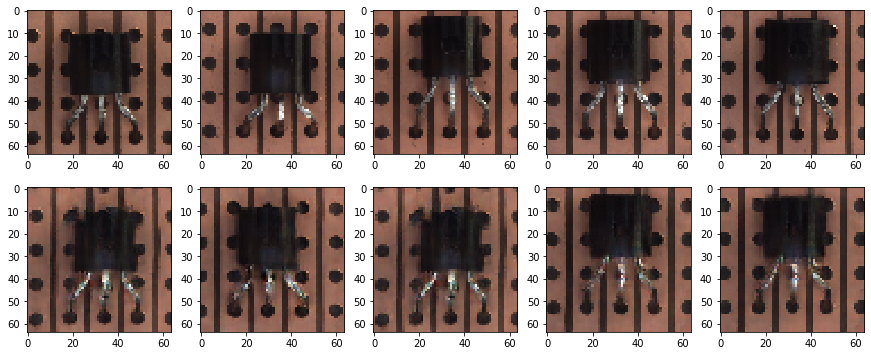

In [16]:
# 生成画像と訓練データを可視化する

def visualize():
    # 入力の乱数生成
    batch_size = 8
    z_dim = 20
    fixed_z = torch.randn(batch_size, z_dim)
    fake_images = G_update(fixed_z.to(device))

    # 訓練データ
    batch_iterator = iter(train_dataloader)  # イテレータに変換
    imges = next(batch_iterator)  # 1番目の要素を取り出す


    # 出力
    fig = plt.figure(figsize=(15, 6))
    for i in range(0, 5):
        # 上段に訓練データを
        plt.subplot(2, 5, i+1)
        plt.imshow(to_raw_image(imges[i].cpu().detach()))

        # 下段に生成データを表示する
        plt.subplot(2, 5, 5+i+1)
        plt.imshow(to_raw_image(fake_images[i].cpu().detach()))
        
visualize()

In [17]:
%%time
# 学習・検証を実行する 10分ほどかかる

num_epochs = 1500
G_update, D_update, E_update = train_model(
    G, D, E, dataloader=train_dataloader, num_epochs=num_epochs)

Epoch 0/1500
epoch 0 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0911 ||Epoch_E_Loss:0.1913
timer:  0.2569 sec.
Epoch 1/1500
epoch 1 || Epoch_D_Loss:0.0530 ||Epoch_G_Loss:0.0895 ||Epoch_E_Loss:0.1730
timer:  0.2550 sec.
Epoch 2/1500
epoch 2 || Epoch_D_Loss:0.0424 ||Epoch_G_Loss:0.1090 ||Epoch_E_Loss:0.1838
timer:  0.2542 sec.
Epoch 3/1500
epoch 3 || Epoch_D_Loss:0.0446 ||Epoch_G_Loss:0.0986 ||Epoch_E_Loss:0.1836
timer:  0.2541 sec.
Epoch 4/1500
epoch 4 || Epoch_D_Loss:0.0559 ||Epoch_G_Loss:0.0911 ||Epoch_E_Loss:0.1649
timer:  0.2542 sec.
Epoch 5/1500
epoch 5 || Epoch_D_Loss:0.0470 ||Epoch_G_Loss:0.1024 ||Epoch_E_Loss:0.1854
timer:  0.2531 sec.
Epoch 6/1500
epoch 6 || Epoch_D_Loss:0.0435 ||Epoch_G_Loss:0.0994 ||Epoch_E_Loss:0.1743
timer:  0.2537 sec.
Epoch 7/1500
epoch 7 || Epoch_D_Loss:0.0560 ||Epoch_G_Loss:0.0919 ||Epoch_E_Loss:0.1759
timer:  0.2551 sec.
Epoch 8/1500
epoch 8 || Epoch_D_Loss:0.0556 ||Epoch_G_Loss:0.0942 ||Epoch_E_Loss:0.1614
timer:  0.2533 sec.
Epoch 9/1500
epoch 9 || Epoc

epoch 75 || Epoch_D_Loss:0.0475 ||Epoch_G_Loss:0.1098 ||Epoch_E_Loss:0.2017
timer:  0.2529 sec.
Epoch 76/1500
epoch 76 || Epoch_D_Loss:0.0429 ||Epoch_G_Loss:0.1096 ||Epoch_E_Loss:0.2317
timer:  0.2530 sec.
Epoch 77/1500
epoch 77 || Epoch_D_Loss:0.0457 ||Epoch_G_Loss:0.1087 ||Epoch_E_Loss:0.2357
timer:  0.2530 sec.
Epoch 78/1500
epoch 78 || Epoch_D_Loss:0.0523 ||Epoch_G_Loss:0.1036 ||Epoch_E_Loss:0.2112
timer:  0.2532 sec.
Epoch 79/1500
epoch 79 || Epoch_D_Loss:0.0508 ||Epoch_G_Loss:0.1180 ||Epoch_E_Loss:0.2242
timer:  0.2532 sec.
Epoch 80/1500
epoch 80 || Epoch_D_Loss:0.0434 ||Epoch_G_Loss:0.1229 ||Epoch_E_Loss:0.2288
timer:  0.2529 sec.
Epoch 81/1500
epoch 81 || Epoch_D_Loss:0.0444 ||Epoch_G_Loss:0.1213 ||Epoch_E_Loss:0.2509
timer:  0.2529 sec.
Epoch 82/1500
epoch 82 || Epoch_D_Loss:0.0384 ||Epoch_G_Loss:0.1180 ||Epoch_E_Loss:0.2704
timer:  0.2532 sec.
Epoch 83/1500
epoch 83 || Epoch_D_Loss:0.0467 ||Epoch_G_Loss:0.1131 ||Epoch_E_Loss:0.2588
timer:  0.2535 sec.
Epoch 84/1500
epoch 84 |

epoch 149 || Epoch_D_Loss:0.0419 ||Epoch_G_Loss:0.0966 ||Epoch_E_Loss:0.2073
timer:  0.2541 sec.
Epoch 150/1500
epoch 150 || Epoch_D_Loss:0.0546 ||Epoch_G_Loss:0.0892 ||Epoch_E_Loss:0.1660
timer:  0.2540 sec.
Epoch 151/1500
epoch 151 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0847 ||Epoch_E_Loss:0.1727
timer:  0.2544 sec.
Epoch 152/1500
epoch 152 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.1067 ||Epoch_E_Loss:0.1693
timer:  0.2535 sec.
Epoch 153/1500
epoch 153 || Epoch_D_Loss:0.0531 ||Epoch_G_Loss:0.1139 ||Epoch_E_Loss:0.1847
timer:  0.2535 sec.
Epoch 154/1500
epoch 154 || Epoch_D_Loss:0.0401 ||Epoch_G_Loss:0.1102 ||Epoch_E_Loss:0.2013
timer:  0.2537 sec.
Epoch 155/1500
epoch 155 || Epoch_D_Loss:0.0379 ||Epoch_G_Loss:0.1073 ||Epoch_E_Loss:0.2012
timer:  0.2535 sec.
Epoch 156/1500
epoch 156 || Epoch_D_Loss:0.0523 ||Epoch_G_Loss:0.0934 ||Epoch_E_Loss:0.1987
timer:  0.2536 sec.
Epoch 157/1500
epoch 157 || Epoch_D_Loss:0.0443 ||Epoch_G_Loss:0.0992 ||Epoch_E_Loss:0.1809
timer:  0.2539 sec.
Epoch 1

epoch 223 || Epoch_D_Loss:0.0413 ||Epoch_G_Loss:0.1292 ||Epoch_E_Loss:0.2589
timer:  0.2537 sec.
Epoch 224/1500
epoch 224 || Epoch_D_Loss:0.0546 ||Epoch_G_Loss:0.1023 ||Epoch_E_Loss:0.2584
timer:  0.2539 sec.
Epoch 225/1500
epoch 225 || Epoch_D_Loss:0.0496 ||Epoch_G_Loss:0.1180 ||Epoch_E_Loss:0.2490
timer:  0.2545 sec.
Epoch 226/1500
epoch 226 || Epoch_D_Loss:0.0415 ||Epoch_G_Loss:0.1051 ||Epoch_E_Loss:0.2528
timer:  0.2537 sec.
Epoch 227/1500
epoch 227 || Epoch_D_Loss:0.0386 ||Epoch_G_Loss:0.1035 ||Epoch_E_Loss:0.2770
timer:  0.2535 sec.
Epoch 228/1500
epoch 228 || Epoch_D_Loss:0.0435 ||Epoch_G_Loss:0.1233 ||Epoch_E_Loss:0.2610
timer:  0.2540 sec.
Epoch 229/1500
epoch 229 || Epoch_D_Loss:0.0399 ||Epoch_G_Loss:0.1203 ||Epoch_E_Loss:0.2262
timer:  0.2539 sec.
Epoch 230/1500
epoch 230 || Epoch_D_Loss:0.0510 ||Epoch_G_Loss:0.1067 ||Epoch_E_Loss:0.2110
timer:  0.2537 sec.
Epoch 231/1500
epoch 231 || Epoch_D_Loss:0.0549 ||Epoch_G_Loss:0.0931 ||Epoch_E_Loss:0.2142
timer:  0.2541 sec.
Epoch 2

epoch 297 || Epoch_D_Loss:0.0447 ||Epoch_G_Loss:0.0921 ||Epoch_E_Loss:0.2114
timer:  0.2541 sec.
Epoch 298/1500
epoch 298 || Epoch_D_Loss:0.0490 ||Epoch_G_Loss:0.1032 ||Epoch_E_Loss:0.1953
timer:  0.2539 sec.
Epoch 299/1500
epoch 299 || Epoch_D_Loss:0.0488 ||Epoch_G_Loss:0.0987 ||Epoch_E_Loss:0.1920
timer:  0.2538 sec.
Epoch 300/1500
epoch 300 || Epoch_D_Loss:0.0461 ||Epoch_G_Loss:0.1052 ||Epoch_E_Loss:0.2080
timer:  0.2534 sec.
Epoch 301/1500
epoch 301 || Epoch_D_Loss:0.0515 ||Epoch_G_Loss:0.0951 ||Epoch_E_Loss:0.2023
timer:  0.2535 sec.
Epoch 302/1500
epoch 302 || Epoch_D_Loss:0.0518 ||Epoch_G_Loss:0.0978 ||Epoch_E_Loss:0.2085
timer:  0.2542 sec.
Epoch 303/1500
epoch 303 || Epoch_D_Loss:0.0531 ||Epoch_G_Loss:0.0940 ||Epoch_E_Loss:0.1901
timer:  0.2539 sec.
Epoch 304/1500
epoch 304 || Epoch_D_Loss:0.0531 ||Epoch_G_Loss:0.1047 ||Epoch_E_Loss:0.1894
timer:  0.2537 sec.
Epoch 305/1500
epoch 305 || Epoch_D_Loss:0.0562 ||Epoch_G_Loss:0.0971 ||Epoch_E_Loss:0.1856
timer:  0.2545 sec.
Epoch 3

epoch 371 || Epoch_D_Loss:0.0513 ||Epoch_G_Loss:0.1000 ||Epoch_E_Loss:0.1749
timer:  0.2539 sec.
Epoch 372/1500
epoch 372 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0811 ||Epoch_E_Loss:0.1528
timer:  0.2536 sec.
Epoch 373/1500
epoch 373 || Epoch_D_Loss:0.0589 ||Epoch_G_Loss:0.0849 ||Epoch_E_Loss:0.1447
timer:  0.2538 sec.
Epoch 374/1500
epoch 374 || Epoch_D_Loss:0.0472 ||Epoch_G_Loss:0.0901 ||Epoch_E_Loss:0.1744
timer:  0.2538 sec.
Epoch 375/1500
epoch 375 || Epoch_D_Loss:0.0479 ||Epoch_G_Loss:0.1129 ||Epoch_E_Loss:0.1740
timer:  0.2543 sec.
Epoch 376/1500
epoch 376 || Epoch_D_Loss:0.0470 ||Epoch_G_Loss:0.1016 ||Epoch_E_Loss:0.1822
timer:  0.2538 sec.
Epoch 377/1500
epoch 377 || Epoch_D_Loss:0.0464 ||Epoch_G_Loss:0.0944 ||Epoch_E_Loss:0.1704
timer:  0.2543 sec.
Epoch 378/1500
epoch 378 || Epoch_D_Loss:0.0429 ||Epoch_G_Loss:0.0952 ||Epoch_E_Loss:0.1834
timer:  0.2540 sec.
Epoch 379/1500
epoch 379 || Epoch_D_Loss:0.0563 ||Epoch_G_Loss:0.0879 ||Epoch_E_Loss:0.1486
timer:  0.2535 sec.
Epoch 3

epoch 445 || Epoch_D_Loss:0.0432 ||Epoch_G_Loss:0.1034 ||Epoch_E_Loss:0.2314
timer:  0.2534 sec.
Epoch 446/1500
epoch 446 || Epoch_D_Loss:0.0423 ||Epoch_G_Loss:0.0990 ||Epoch_E_Loss:0.2102
timer:  0.2533 sec.
Epoch 447/1500
epoch 447 || Epoch_D_Loss:0.0433 ||Epoch_G_Loss:0.1091 ||Epoch_E_Loss:0.2153
timer:  0.2537 sec.
Epoch 448/1500
epoch 448 || Epoch_D_Loss:0.0444 ||Epoch_G_Loss:0.0967 ||Epoch_E_Loss:0.2142
timer:  0.2539 sec.
Epoch 449/1500
epoch 449 || Epoch_D_Loss:0.0603 ||Epoch_G_Loss:0.0995 ||Epoch_E_Loss:0.1781
timer:  0.2538 sec.
Epoch 450/1500
epoch 450 || Epoch_D_Loss:0.0548 ||Epoch_G_Loss:0.0982 ||Epoch_E_Loss:0.1933
timer:  0.2538 sec.
Epoch 451/1500
epoch 451 || Epoch_D_Loss:0.0464 ||Epoch_G_Loss:0.1190 ||Epoch_E_Loss:0.1951
timer:  0.2538 sec.
Epoch 452/1500
epoch 452 || Epoch_D_Loss:0.0410 ||Epoch_G_Loss:0.1141 ||Epoch_E_Loss:0.1986
timer:  0.2539 sec.
Epoch 453/1500
epoch 453 || Epoch_D_Loss:0.0462 ||Epoch_G_Loss:0.0986 ||Epoch_E_Loss:0.1974
timer:  0.2547 sec.
Epoch 4

epoch 519 || Epoch_D_Loss:0.0505 ||Epoch_G_Loss:0.1141 ||Epoch_E_Loss:0.1953
timer:  0.2535 sec.
Epoch 520/1500
epoch 520 || Epoch_D_Loss:0.0442 ||Epoch_G_Loss:0.1030 ||Epoch_E_Loss:0.2361
timer:  0.2537 sec.
Epoch 521/1500
epoch 521 || Epoch_D_Loss:0.0494 ||Epoch_G_Loss:0.0941 ||Epoch_E_Loss:0.2099
timer:  0.2538 sec.
Epoch 522/1500
epoch 522 || Epoch_D_Loss:0.0479 ||Epoch_G_Loss:0.0942 ||Epoch_E_Loss:0.2105
timer:  0.2534 sec.
Epoch 523/1500
epoch 523 || Epoch_D_Loss:0.0448 ||Epoch_G_Loss:0.0966 ||Epoch_E_Loss:0.2291
timer:  0.2535 sec.
Epoch 524/1500
epoch 524 || Epoch_D_Loss:0.0518 ||Epoch_G_Loss:0.0865 ||Epoch_E_Loss:0.2158
timer:  0.2535 sec.
Epoch 525/1500
epoch 525 || Epoch_D_Loss:0.0597 ||Epoch_G_Loss:0.0996 ||Epoch_E_Loss:0.2022
timer:  0.2535 sec.
Epoch 526/1500
epoch 526 || Epoch_D_Loss:0.0600 ||Epoch_G_Loss:0.0979 ||Epoch_E_Loss:0.1939
timer:  0.2540 sec.
Epoch 527/1500
epoch 527 || Epoch_D_Loss:0.0478 ||Epoch_G_Loss:0.0921 ||Epoch_E_Loss:0.2256
timer:  0.2541 sec.
Epoch 5

epoch 593 || Epoch_D_Loss:0.0520 ||Epoch_G_Loss:0.0921 ||Epoch_E_Loss:0.2309
timer:  0.2545 sec.
Epoch 594/1500
epoch 594 || Epoch_D_Loss:0.0417 ||Epoch_G_Loss:0.1307 ||Epoch_E_Loss:0.2596
timer:  0.2547 sec.
Epoch 595/1500
epoch 595 || Epoch_D_Loss:0.0460 ||Epoch_G_Loss:0.1038 ||Epoch_E_Loss:0.2624
timer:  0.2546 sec.
Epoch 596/1500
epoch 596 || Epoch_D_Loss:0.0481 ||Epoch_G_Loss:0.1004 ||Epoch_E_Loss:0.2657
timer:  0.2538 sec.
Epoch 597/1500
epoch 597 || Epoch_D_Loss:0.0477 ||Epoch_G_Loss:0.1100 ||Epoch_E_Loss:0.2469
timer:  0.2538 sec.
Epoch 598/1500
epoch 598 || Epoch_D_Loss:0.0463 ||Epoch_G_Loss:0.1097 ||Epoch_E_Loss:0.2395
timer:  0.2539 sec.
Epoch 599/1500
epoch 599 || Epoch_D_Loss:0.0505 ||Epoch_G_Loss:0.0999 ||Epoch_E_Loss:0.2095
timer:  0.2540 sec.
Epoch 600/1500
epoch 600 || Epoch_D_Loss:0.0557 ||Epoch_G_Loss:0.1000 ||Epoch_E_Loss:0.2121
timer:  0.2539 sec.
Epoch 601/1500
epoch 601 || Epoch_D_Loss:0.0631 ||Epoch_G_Loss:0.0955 ||Epoch_E_Loss:0.2175
timer:  0.2541 sec.
Epoch 6

epoch 667 || Epoch_D_Loss:0.0509 ||Epoch_G_Loss:0.0877 ||Epoch_E_Loss:0.1549
timer:  0.2537 sec.
Epoch 668/1500
epoch 668 || Epoch_D_Loss:0.0479 ||Epoch_G_Loss:0.0838 ||Epoch_E_Loss:0.1584
timer:  0.2538 sec.
Epoch 669/1500
epoch 669 || Epoch_D_Loss:0.0448 ||Epoch_G_Loss:0.1023 ||Epoch_E_Loss:0.1528
timer:  0.2537 sec.
Epoch 670/1500
epoch 670 || Epoch_D_Loss:0.0480 ||Epoch_G_Loss:0.0889 ||Epoch_E_Loss:0.1473
timer:  0.2536 sec.
Epoch 671/1500
epoch 671 || Epoch_D_Loss:0.0485 ||Epoch_G_Loss:0.0934 ||Epoch_E_Loss:0.1567
timer:  0.2545 sec.
Epoch 672/1500
epoch 672 || Epoch_D_Loss:0.0478 ||Epoch_G_Loss:0.0840 ||Epoch_E_Loss:0.1720
timer:  0.2539 sec.
Epoch 673/1500
epoch 673 || Epoch_D_Loss:0.0634 ||Epoch_G_Loss:0.0810 ||Epoch_E_Loss:0.1407
timer:  0.2548 sec.
Epoch 674/1500
epoch 674 || Epoch_D_Loss:0.0543 ||Epoch_G_Loss:0.0846 ||Epoch_E_Loss:0.1495
timer:  0.2543 sec.
Epoch 675/1500
epoch 675 || Epoch_D_Loss:0.0461 ||Epoch_G_Loss:0.0862 ||Epoch_E_Loss:0.1549
timer:  0.2537 sec.
Epoch 6

epoch 741 || Epoch_D_Loss:0.0448 ||Epoch_G_Loss:0.1047 ||Epoch_E_Loss:0.1638
timer:  0.2539 sec.
Epoch 742/1500
epoch 742 || Epoch_D_Loss:0.0480 ||Epoch_G_Loss:0.0977 ||Epoch_E_Loss:0.1640
timer:  0.2541 sec.
Epoch 743/1500
epoch 743 || Epoch_D_Loss:0.0499 ||Epoch_G_Loss:0.0977 ||Epoch_E_Loss:0.1754
timer:  0.2547 sec.
Epoch 744/1500
epoch 744 || Epoch_D_Loss:0.0468 ||Epoch_G_Loss:0.1091 ||Epoch_E_Loss:0.1556
timer:  0.2537 sec.
Epoch 745/1500
epoch 745 || Epoch_D_Loss:0.0472 ||Epoch_G_Loss:0.0998 ||Epoch_E_Loss:0.1641
timer:  0.2538 sec.
Epoch 746/1500
epoch 746 || Epoch_D_Loss:0.0554 ||Epoch_G_Loss:0.0930 ||Epoch_E_Loss:0.1588
timer:  0.2540 sec.
Epoch 747/1500
epoch 747 || Epoch_D_Loss:0.0606 ||Epoch_G_Loss:0.0781 ||Epoch_E_Loss:0.1502
timer:  0.2539 sec.
Epoch 748/1500
epoch 748 || Epoch_D_Loss:0.0590 ||Epoch_G_Loss:0.0928 ||Epoch_E_Loss:0.1426
timer:  0.2538 sec.
Epoch 749/1500
epoch 749 || Epoch_D_Loss:0.0509 ||Epoch_G_Loss:0.0914 ||Epoch_E_Loss:0.1547
timer:  0.2537 sec.
Epoch 7

epoch 815 || Epoch_D_Loss:0.0560 ||Epoch_G_Loss:0.0777 ||Epoch_E_Loss:0.1235
timer:  0.2544 sec.
Epoch 816/1500
epoch 816 || Epoch_D_Loss:0.0506 ||Epoch_G_Loss:0.0920 ||Epoch_E_Loss:0.1391
timer:  0.2538 sec.
Epoch 817/1500
epoch 817 || Epoch_D_Loss:0.0550 ||Epoch_G_Loss:0.0926 ||Epoch_E_Loss:0.1366
timer:  0.2547 sec.
Epoch 818/1500
epoch 818 || Epoch_D_Loss:0.0465 ||Epoch_G_Loss:0.1126 ||Epoch_E_Loss:0.1307
timer:  0.2539 sec.
Epoch 819/1500
epoch 819 || Epoch_D_Loss:0.0456 ||Epoch_G_Loss:0.0848 ||Epoch_E_Loss:0.1560
timer:  0.2535 sec.
Epoch 820/1500
epoch 820 || Epoch_D_Loss:0.0446 ||Epoch_G_Loss:0.0957 ||Epoch_E_Loss:0.1570
timer:  0.2538 sec.
Epoch 821/1500
epoch 821 || Epoch_D_Loss:0.0419 ||Epoch_G_Loss:0.1055 ||Epoch_E_Loss:0.1650
timer:  0.2541 sec.
Epoch 822/1500
epoch 822 || Epoch_D_Loss:0.0421 ||Epoch_G_Loss:0.1041 ||Epoch_E_Loss:0.1705
timer:  0.2538 sec.
Epoch 823/1500
epoch 823 || Epoch_D_Loss:0.0447 ||Epoch_G_Loss:0.0937 ||Epoch_E_Loss:0.1557
timer:  0.2537 sec.
Epoch 8

epoch 889 || Epoch_D_Loss:0.0602 ||Epoch_G_Loss:0.0906 ||Epoch_E_Loss:0.1767
timer:  0.2542 sec.
Epoch 890/1500
epoch 890 || Epoch_D_Loss:0.0567 ||Epoch_G_Loss:0.0819 ||Epoch_E_Loss:0.1737
timer:  0.2540 sec.
Epoch 891/1500
epoch 891 || Epoch_D_Loss:0.0535 ||Epoch_G_Loss:0.1079 ||Epoch_E_Loss:0.1748
timer:  0.2540 sec.
Epoch 892/1500
epoch 892 || Epoch_D_Loss:0.0504 ||Epoch_G_Loss:0.0875 ||Epoch_E_Loss:0.1806
timer:  0.2539 sec.
Epoch 893/1500
epoch 893 || Epoch_D_Loss:0.0555 ||Epoch_G_Loss:0.1025 ||Epoch_E_Loss:0.1694
timer:  0.2540 sec.
Epoch 894/1500
epoch 894 || Epoch_D_Loss:0.0506 ||Epoch_G_Loss:0.0970 ||Epoch_E_Loss:0.1710
timer:  0.2544 sec.
Epoch 895/1500
epoch 895 || Epoch_D_Loss:0.0510 ||Epoch_G_Loss:0.0915 ||Epoch_E_Loss:0.1720
timer:  0.2538 sec.
Epoch 896/1500
epoch 896 || Epoch_D_Loss:0.0544 ||Epoch_G_Loss:0.0907 ||Epoch_E_Loss:0.1754
timer:  0.2541 sec.
Epoch 897/1500
epoch 897 || Epoch_D_Loss:0.0553 ||Epoch_G_Loss:0.1094 ||Epoch_E_Loss:0.1812
timer:  0.2538 sec.
Epoch 8

epoch 963 || Epoch_D_Loss:0.0560 ||Epoch_G_Loss:0.0788 ||Epoch_E_Loss:0.1545
timer:  0.2537 sec.
Epoch 964/1500
epoch 964 || Epoch_D_Loss:0.0514 ||Epoch_G_Loss:0.0929 ||Epoch_E_Loss:0.1639
timer:  0.2538 sec.
Epoch 965/1500
epoch 965 || Epoch_D_Loss:0.0579 ||Epoch_G_Loss:0.0892 ||Epoch_E_Loss:0.1628
timer:  0.2536 sec.
Epoch 966/1500
epoch 966 || Epoch_D_Loss:0.0457 ||Epoch_G_Loss:0.0923 ||Epoch_E_Loss:0.1648
timer:  0.2537 sec.
Epoch 967/1500
epoch 967 || Epoch_D_Loss:0.0549 ||Epoch_G_Loss:0.0897 ||Epoch_E_Loss:0.1479
timer:  0.2544 sec.
Epoch 968/1500
epoch 968 || Epoch_D_Loss:0.0523 ||Epoch_G_Loss:0.0812 ||Epoch_E_Loss:0.1515
timer:  0.2541 sec.
Epoch 969/1500
epoch 969 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.0914 ||Epoch_E_Loss:0.1760
timer:  0.2536 sec.
Epoch 970/1500
epoch 970 || Epoch_D_Loss:0.0533 ||Epoch_G_Loss:0.0763 ||Epoch_E_Loss:0.1690
timer:  0.2538 sec.
Epoch 971/1500
epoch 971 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.0919 ||Epoch_E_Loss:0.1596
timer:  0.2536 sec.
Epoch 9

epoch 1036 || Epoch_D_Loss:0.0449 ||Epoch_G_Loss:0.1238 ||Epoch_E_Loss:0.1819
timer:  0.2542 sec.
Epoch 1037/1500
epoch 1037 || Epoch_D_Loss:0.0480 ||Epoch_G_Loss:0.0937 ||Epoch_E_Loss:0.1594
timer:  0.2542 sec.
Epoch 1038/1500
epoch 1038 || Epoch_D_Loss:0.0508 ||Epoch_G_Loss:0.0943 ||Epoch_E_Loss:0.1542
timer:  0.2545 sec.
Epoch 1039/1500
epoch 1039 || Epoch_D_Loss:0.0599 ||Epoch_G_Loss:0.0900 ||Epoch_E_Loss:0.1574
timer:  0.2542 sec.
Epoch 1040/1500
epoch 1040 || Epoch_D_Loss:0.0529 ||Epoch_G_Loss:0.0905 ||Epoch_E_Loss:0.1707
timer:  0.2550 sec.
Epoch 1041/1500
epoch 1041 || Epoch_D_Loss:0.0544 ||Epoch_G_Loss:0.0918 ||Epoch_E_Loss:0.1610
timer:  0.2546 sec.
Epoch 1042/1500
epoch 1042 || Epoch_D_Loss:0.0529 ||Epoch_G_Loss:0.0886 ||Epoch_E_Loss:0.1646
timer:  0.2546 sec.
Epoch 1043/1500
epoch 1043 || Epoch_D_Loss:0.0591 ||Epoch_G_Loss:0.0920 ||Epoch_E_Loss:0.1490
timer:  0.2546 sec.
Epoch 1044/1500
epoch 1044 || Epoch_D_Loss:0.0564 ||Epoch_G_Loss:0.0932 ||Epoch_E_Loss:0.1585
timer:  0.

epoch 1108 || Epoch_D_Loss:0.0563 ||Epoch_G_Loss:0.1037 ||Epoch_E_Loss:0.1664
timer:  0.2542 sec.
Epoch 1109/1500
epoch 1109 || Epoch_D_Loss:0.0532 ||Epoch_G_Loss:0.0986 ||Epoch_E_Loss:0.1698
timer:  0.2544 sec.
Epoch 1110/1500
epoch 1110 || Epoch_D_Loss:0.0570 ||Epoch_G_Loss:0.1047 ||Epoch_E_Loss:0.1532
timer:  0.2540 sec.
Epoch 1111/1500
epoch 1111 || Epoch_D_Loss:0.0564 ||Epoch_G_Loss:0.0931 ||Epoch_E_Loss:0.1745
timer:  0.2540 sec.
Epoch 1112/1500
epoch 1112 || Epoch_D_Loss:0.0528 ||Epoch_G_Loss:0.1059 ||Epoch_E_Loss:0.1709
timer:  0.2540 sec.
Epoch 1113/1500
epoch 1113 || Epoch_D_Loss:0.0562 ||Epoch_G_Loss:0.0813 ||Epoch_E_Loss:0.1917
timer:  0.2542 sec.
Epoch 1114/1500
epoch 1114 || Epoch_D_Loss:0.0541 ||Epoch_G_Loss:0.1146 ||Epoch_E_Loss:0.1766
timer:  0.2543 sec.
Epoch 1115/1500
epoch 1115 || Epoch_D_Loss:0.0550 ||Epoch_G_Loss:0.0873 ||Epoch_E_Loss:0.1664
timer:  0.2543 sec.
Epoch 1116/1500
epoch 1116 || Epoch_D_Loss:0.0560 ||Epoch_G_Loss:0.0951 ||Epoch_E_Loss:0.1896
timer:  0.

epoch 1180 || Epoch_D_Loss:0.0448 ||Epoch_G_Loss:0.1015 ||Epoch_E_Loss:0.2241
timer:  0.2541 sec.
Epoch 1181/1500
epoch 1181 || Epoch_D_Loss:0.0409 ||Epoch_G_Loss:0.0952 ||Epoch_E_Loss:0.2278
timer:  0.2543 sec.
Epoch 1182/1500
epoch 1182 || Epoch_D_Loss:0.0509 ||Epoch_G_Loss:0.1028 ||Epoch_E_Loss:0.2166
timer:  0.2546 sec.
Epoch 1183/1500
epoch 1183 || Epoch_D_Loss:0.0474 ||Epoch_G_Loss:0.1085 ||Epoch_E_Loss:0.2184
timer:  0.2543 sec.
Epoch 1184/1500
epoch 1184 || Epoch_D_Loss:0.0475 ||Epoch_G_Loss:0.0932 ||Epoch_E_Loss:0.2302
timer:  0.2543 sec.
Epoch 1185/1500
epoch 1185 || Epoch_D_Loss:0.0390 ||Epoch_G_Loss:0.1133 ||Epoch_E_Loss:0.2591
timer:  0.2544 sec.
Epoch 1186/1500
epoch 1186 || Epoch_D_Loss:0.0445 ||Epoch_G_Loss:0.1076 ||Epoch_E_Loss:0.2491
timer:  0.2546 sec.
Epoch 1187/1500
epoch 1187 || Epoch_D_Loss:0.0451 ||Epoch_G_Loss:0.1130 ||Epoch_E_Loss:0.2187
timer:  0.2548 sec.
Epoch 1188/1500
epoch 1188 || Epoch_D_Loss:0.0507 ||Epoch_G_Loss:0.0886 ||Epoch_E_Loss:0.2296
timer:  0.

epoch 1252 || Epoch_D_Loss:0.0435 ||Epoch_G_Loss:0.1054 ||Epoch_E_Loss:0.1657
timer:  0.2547 sec.
Epoch 1253/1500
epoch 1253 || Epoch_D_Loss:0.0560 ||Epoch_G_Loss:0.0947 ||Epoch_E_Loss:0.1448
timer:  0.2546 sec.
Epoch 1254/1500
epoch 1254 || Epoch_D_Loss:0.0532 ||Epoch_G_Loss:0.0871 ||Epoch_E_Loss:0.1454
timer:  0.2546 sec.
Epoch 1255/1500
epoch 1255 || Epoch_D_Loss:0.0567 ||Epoch_G_Loss:0.0894 ||Epoch_E_Loss:0.1264
timer:  0.2549 sec.
Epoch 1256/1500
epoch 1256 || Epoch_D_Loss:0.0664 ||Epoch_G_Loss:0.0865 ||Epoch_E_Loss:0.1326
timer:  0.2549 sec.
Epoch 1257/1500
epoch 1257 || Epoch_D_Loss:0.0598 ||Epoch_G_Loss:0.0734 ||Epoch_E_Loss:0.1387
timer:  0.2546 sec.
Epoch 1258/1500
epoch 1258 || Epoch_D_Loss:0.0693 ||Epoch_G_Loss:0.0848 ||Epoch_E_Loss:0.1309
timer:  0.2550 sec.
Epoch 1259/1500
epoch 1259 || Epoch_D_Loss:0.0509 ||Epoch_G_Loss:0.1042 ||Epoch_E_Loss:0.1531
timer:  0.2547 sec.
Epoch 1260/1500
epoch 1260 || Epoch_D_Loss:0.0565 ||Epoch_G_Loss:0.0866 ||Epoch_E_Loss:0.1477
timer:  0.

epoch 1324 || Epoch_D_Loss:0.0483 ||Epoch_G_Loss:0.0944 ||Epoch_E_Loss:0.1741
timer:  0.2548 sec.
Epoch 1325/1500
epoch 1325 || Epoch_D_Loss:0.0463 ||Epoch_G_Loss:0.1029 ||Epoch_E_Loss:0.1708
timer:  0.2544 sec.
Epoch 1326/1500
epoch 1326 || Epoch_D_Loss:0.0459 ||Epoch_G_Loss:0.0983 ||Epoch_E_Loss:0.1818
timer:  0.2542 sec.
Epoch 1327/1500
epoch 1327 || Epoch_D_Loss:0.0415 ||Epoch_G_Loss:0.1114 ||Epoch_E_Loss:0.1977
timer:  0.2542 sec.
Epoch 1328/1500
epoch 1328 || Epoch_D_Loss:0.0484 ||Epoch_G_Loss:0.0992 ||Epoch_E_Loss:0.1888
timer:  0.2544 sec.
Epoch 1329/1500
epoch 1329 || Epoch_D_Loss:0.0506 ||Epoch_G_Loss:0.0969 ||Epoch_E_Loss:0.1783
timer:  0.2546 sec.
Epoch 1330/1500
epoch 1330 || Epoch_D_Loss:0.0457 ||Epoch_G_Loss:0.0890 ||Epoch_E_Loss:0.1737
timer:  0.2544 sec.
Epoch 1331/1500
epoch 1331 || Epoch_D_Loss:0.0460 ||Epoch_G_Loss:0.1012 ||Epoch_E_Loss:0.1663
timer:  0.2544 sec.
Epoch 1332/1500
epoch 1332 || Epoch_D_Loss:0.0482 ||Epoch_G_Loss:0.1010 ||Epoch_E_Loss:0.1576
timer:  0.

epoch 1396 || Epoch_D_Loss:0.0505 ||Epoch_G_Loss:0.1390 ||Epoch_E_Loss:0.2273
timer:  0.2546 sec.
Epoch 1397/1500
epoch 1397 || Epoch_D_Loss:0.0428 ||Epoch_G_Loss:0.1194 ||Epoch_E_Loss:0.2502
timer:  0.2549 sec.
Epoch 1398/1500
epoch 1398 || Epoch_D_Loss:0.0545 ||Epoch_G_Loss:0.0972 ||Epoch_E_Loss:0.2071
timer:  0.2550 sec.
Epoch 1399/1500
epoch 1399 || Epoch_D_Loss:0.0407 ||Epoch_G_Loss:0.1148 ||Epoch_E_Loss:0.2461
timer:  0.2549 sec.
Epoch 1400/1500
epoch 1400 || Epoch_D_Loss:0.0451 ||Epoch_G_Loss:0.1056 ||Epoch_E_Loss:0.2803
timer:  0.2555 sec.
Epoch 1401/1500
epoch 1401 || Epoch_D_Loss:0.0531 ||Epoch_G_Loss:0.0962 ||Epoch_E_Loss:0.2270
timer:  0.2546 sec.
Epoch 1402/1500
epoch 1402 || Epoch_D_Loss:0.0413 ||Epoch_G_Loss:0.0966 ||Epoch_E_Loss:0.2632
timer:  0.2549 sec.
Epoch 1403/1500
epoch 1403 || Epoch_D_Loss:0.0496 ||Epoch_G_Loss:0.1087 ||Epoch_E_Loss:0.2549
timer:  0.2549 sec.
Epoch 1404/1500
epoch 1404 || Epoch_D_Loss:0.0585 ||Epoch_G_Loss:0.1021 ||Epoch_E_Loss:0.2476
timer:  0.

epoch 1468 || Epoch_D_Loss:0.0650 ||Epoch_G_Loss:0.0985 ||Epoch_E_Loss:0.1654
timer:  0.2548 sec.
Epoch 1469/1500
epoch 1469 || Epoch_D_Loss:0.0510 ||Epoch_G_Loss:0.0905 ||Epoch_E_Loss:0.1846
timer:  0.2542 sec.
Epoch 1470/1500
epoch 1470 || Epoch_D_Loss:0.0493 ||Epoch_G_Loss:0.0818 ||Epoch_E_Loss:0.1789
timer:  0.2548 sec.
Epoch 1471/1500
epoch 1471 || Epoch_D_Loss:0.0563 ||Epoch_G_Loss:0.0918 ||Epoch_E_Loss:0.1887
timer:  0.2542 sec.
Epoch 1472/1500
epoch 1472 || Epoch_D_Loss:0.0555 ||Epoch_G_Loss:0.0991 ||Epoch_E_Loss:0.1915
timer:  0.2544 sec.
Epoch 1473/1500
epoch 1473 || Epoch_D_Loss:0.0506 ||Epoch_G_Loss:0.1107 ||Epoch_E_Loss:0.1947
timer:  0.2545 sec.
Epoch 1474/1500
epoch 1474 || Epoch_D_Loss:0.0498 ||Epoch_G_Loss:0.0869 ||Epoch_E_Loss:0.1898
timer:  0.2548 sec.
Epoch 1475/1500
epoch 1475 || Epoch_D_Loss:0.0540 ||Epoch_G_Loss:0.0905 ||Epoch_E_Loss:0.1709
timer:  0.2549 sec.
Epoch 1476/1500
epoch 1476 || Epoch_D_Loss:0.0446 ||Epoch_G_Loss:0.1004 ||Epoch_E_Loss:0.2070
timer:  0.

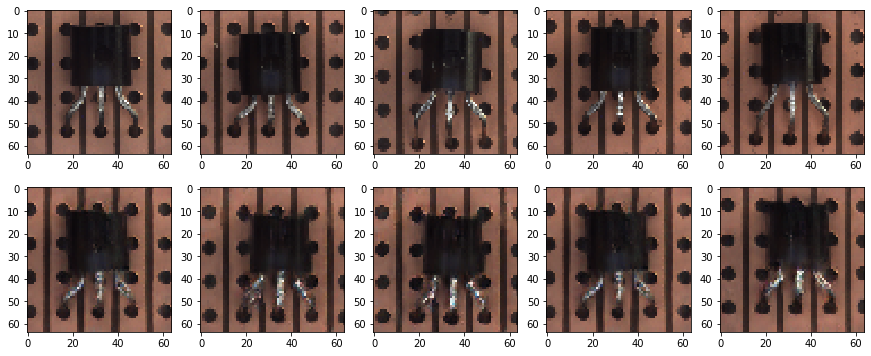

In [18]:
visualize()

# テスト画像で異常検知する

In [19]:
# テスト用のDataLoaderの作成

def make_test_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    # 画像ファイルパスを格納
    train_img_list = sorted(DATA_ROOT.glob(f'test/*/*{SUFFIX}'))

    return train_img_list


# ファイルリストを作成
test_img_list = make_test_datapath_list()

prep.prepare_test(test_img_list,
                  # skip_file_creation=True
                 )

# Datasetを作成
test_dataset = GAN_Img_Dataset(file_list=prep.test_files, load_size=SIZE + 4, crop_size=SIZE,
                               transform=ImageTransform(), random=False, #debug='test_ds'
                              )

# DataLoaderを作成
batch_size = 100

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
test_list = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
[prep.test_files[i] for i in test_list]

['tmp/effgan-mvtrans64/test/bent_lead-000.png',
 'tmp/effgan-mvtrans64/test/cut_lead-000.png',
 'tmp/effgan-mvtrans64/test/damaged_case-000.png',
 'tmp/effgan-mvtrans64/test/good-000.png',
 'tmp/effgan-mvtrans64/test/good-010.png',
 'tmp/effgan-mvtrans64/test/good-020.png',
 'tmp/effgan-mvtrans64/test/good-030.png',
 'tmp/effgan-mvtrans64/test/good-040.png',
 'tmp/effgan-mvtrans64/test/good-050.png',
 'tmp/effgan-mvtrans64/test/misplaced-000.png']

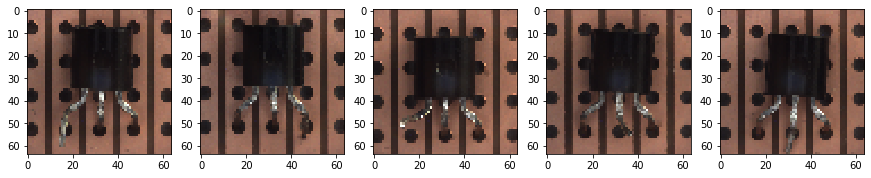

In [21]:
# テストデータの確認
batch_iterator = iter(test_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(to_raw_image(imges[i].cpu().detach()))

In [23]:
def Anomaly_score(x, fake_img, z_out_real, D, Lambda=0.1):
    print(x.shape, fake_img.shape, z_out_real.shape)

    # テスト画像xと生成画像fake_imgのピクセルレベルの差の絶対値を求めて、ミニバッチごとに和を求める
    residual_loss = torch.abs(x.mean(1)-fake_img.mean(1))
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)

    # テスト画像xと生成画像fake_imgを識別器Dに入力し、特徴量マップを取り出す

    _, x_feature = D(x, z_out_real)
    _, G_feature = D(fake_img, z_out_real)

    # テスト画像xと生成画像fake_imgの特徴量の差の絶対値を求めて、ミニバッチごとに和を求める
    discrimination_loss = torch.abs(x_feature-G_feature)
    discrimination_loss = discrimination_loss.view(discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)

    # ミニバッチごとに2種類の損失を足し算する
    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss

    # ミニバッチ全部の損失を求める
    total_loss = torch.sum(loss_each)

    return total_loss, loss_each, residual_loss

torch.Size([10, 3, 64, 64]) torch.Size([10, 3, 64, 64]) torch.Size([10, 20])
total loss： [ 902. 1048.  910.  497. 1089.  671.  720.  593.  385.  945.]


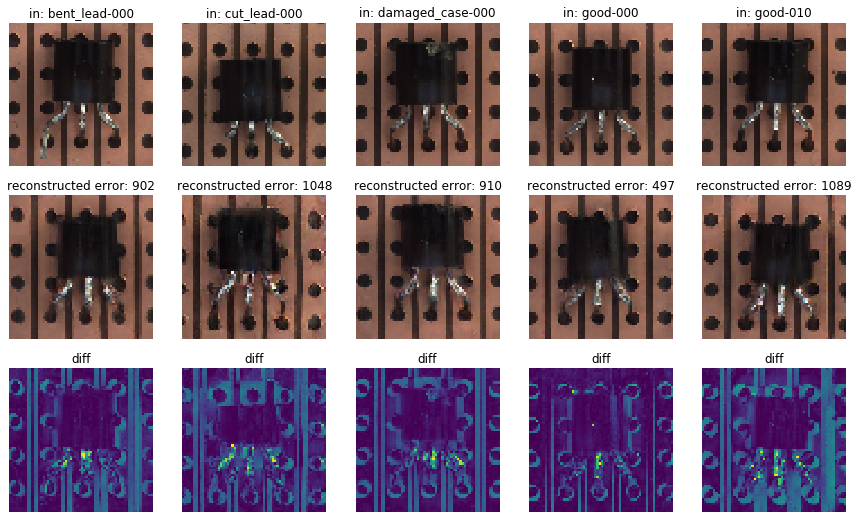

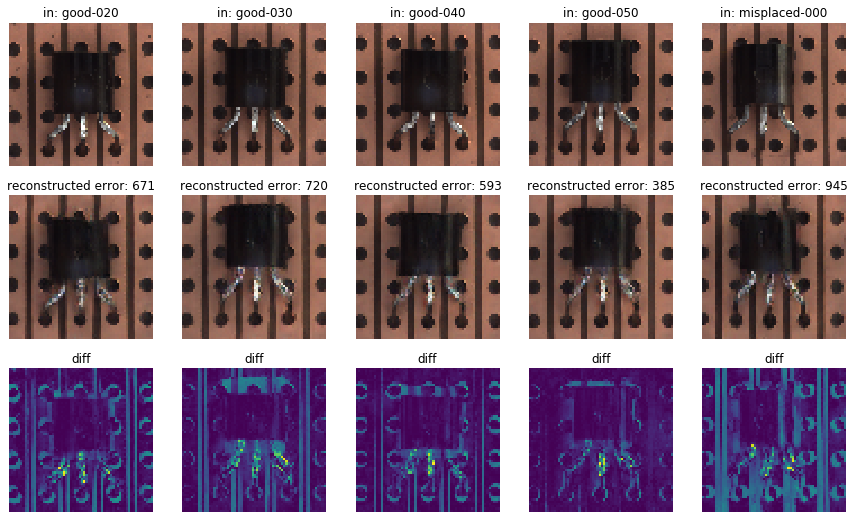

In [45]:
# 教師データの画像をエンコードしてzにしてから、Gで生成
z_out_real = E_update(imges.to(device))
imges_reconstract = G_update(z_out_real)

# 損失を求める
loss, loss_each, residual_loss_each = Anomaly_score(
    imges[test_list].to(device), imges_reconstract[test_list], z_out_real[test_list],
    D_update, Lambda=0.1)

# 損失の計算。トータルの損失
loss_each = loss_each.cpu().detach().numpy()
print("total loss：", np.round(loss_each, 0))

# 画像を可視化
for j in range(len(test_list) // 5):
    fig = plt.figure(figsize=(15, 9))
    for i in range(5):
        idx = j * 5 + i
        img_idx = test_list[idx]
        # 上段に訓練データを
        plt.subplot(3, 5, i+1)
        org_img = to_raw_image(imges[img_idx].cpu().detach())
        plt.imshow(org_img)
        plt.title(f'in: {Path(prep.test_files[img_idx]).stem}')
        plt.axis('off')

        # 中段に生成データを表示する
        plt.subplot(3, 5, 5+i+1)
        reconst_img = to_raw_image(imges_reconstract[img_idx].cpu().detach())
        plt.imshow(reconst_img)
        plt.title(f'reconstructed error: {loss_each[idx]:.0f}')
        plt.axis('off')

        # 下段に差分を表示する
        plt.subplot(3, 5, 5+5+i+1)
        diff_img = np.abs(org_img.mean(axis=-1) - reconst_img.mean(axis=-1)) / 255.
        plt.imshow(diff_img)
        plt.title('diff')
        plt.axis('off')
    plt.show()

以上